In [ ]:
from IPython.display import clear_output
!pip install tashaphyne fasttext keras
!pip install arabic-reshaper python-bidi
clear_output()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import word_tokenize
from tashaphyne.stemming import ArabicLightStemmer
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
nltk.download('punkt')
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tqdm import tqdm
import fasttext
from bidi.algorithm import get_display
import arabic_reshaper

In [ ]:
dataset=pd.read_csv('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_training_set.csv').drop(columns=['Unnamed: 0'])
testing_set=pd.read_csv('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_testing_set.csv').drop(columns=['Unnamed: 0'])
dataset

Tweet     Class
0     حرصا سلامة المدنين الرجاء الجميع إكسبو دبي رجا...  negative
1     عبدالله زايد وزير خارجية الإمارات يزور الجناح ...  negative
2     بدون مبالغة تنظيم أسبوع المهندس الجامعة أيام ز...  negative
3     جناح المغرب يفوز بجائزة افضل تصميم داخلي إكسبو...  negative
4     نسلط الضوء مرة رواق ممل فارغ إكسبو دبي رواق ال...  negative
...                                                 ...       ...
7495  توقف   اختارت فرقة دبي لاستءناف جولاتها العالم...   neutral
7496  اكسبو دبي يقترب  اخبار الامارات اكسبو دبي   را...   neutral
7497                        مجموعة اصدارات جواز اكسبو     neutral
7498     محمد راشد اثناء حضوري تمرين حصن الاتحاد اكس...   neutral
7499  بهدف تعزيز التعاون دولة الامارات كندا استضافت ...   neutral

[7500 rows x 2 columns]

In [ ]:
dataset.dropna(inplace=True)

In [ ]:
def stem(text):
  text=str(text)
  stemmer=ArabicLightStemmer()
  tokens=word_tokenize(text)
  tokens
  stemmized=[]
  for t in tokens:
    stem=stemmer.light_stem(t)
    stemmized.append(stem)

  return ' '.join(stemmized)

#all_texts=pd.concat([dataset['Tweet'],testing_set['Tweet']])
all_texts=dataset['Tweet']
all_texts.apply(stem)

0       حرص سلام مدن رجاء جميع إكسب دب رجاء بق مساف اف...
1       عبدالل زايد زير خارج إمار زور جناح سور إكسب دب...
2       دون مبالغ نظيم سبوع مهندس جامع يام زم حس نظيم ...
3       جناح مغرب فوز جائز فضل صميم داخل إكسب دب جناح ...
4       سلط ضوء مرة رواق ممل رغ إكسب دب رواق جزائر اضح...
                              ...                        
7495    وقف اختار رق دب استءناف جول عالم ما سب علاق كس...
7496     كسبو دب قترب خبار امار كسبو دب رادار يوز مرا خبر
7497                                مجموع اصدار جواز كسبو
7498    محمد راشد اثناء حضور مر حص اتحاد كسبو دب مر ظه...
7499    هدف عزيز تعا دول امار ندا استضاف قنصل عام كند ...
Name: Tweet, Length: 7491, dtype: object

In [ ]:
ExpoTokenizer=Tokenizer()
ExpoTokenizer.fit_on_texts(all_texts)
# save tokenizer model
#import pickle
#with open('/content/drive/MyDrive/SeniorProject1/models/ExpoTokenizer.pickle', 'wb') as handle:
#    pickle.dump(ExpoTokenizer,handle)

# load tokenizer model
#with open('/content/drive/MyDrive/SeniorProject1/models/ExpoTokenizer.pickle', 'rb') as handle:
#    ExpoTokenizer = pickle.load(handle)
print("Number of total vocabulary of train and test =",len(ExpoTokenizer.word_index))

Number of total vocabulary of train and test = 25291


In [ ]:
onehotencoder=OneHotEncoder().fit(np.array(dataset['Class']).reshape(-1,1))


In [ ]:
sents_len=[]
for text in dataset['Tweet']:
  tokens=word_tokenize(text)
  sents_len.append(len(tokens))


#highest 2 sequence len
sorted(sents_len,reverse=True)[:2]

[44, 44]

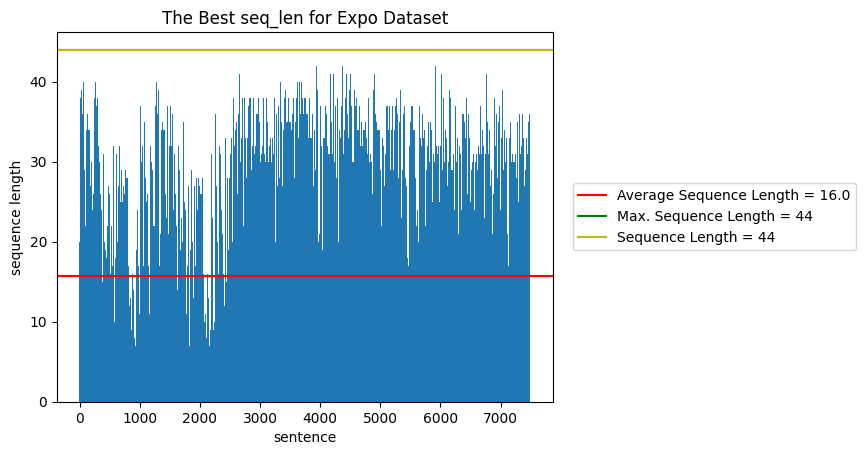

In [ ]:
plt.bar(range(len(sents_len)),sents_len,width=10)
plt.ylabel('sequence length')
plt.xlabel('sentence')
plt.axhline(y=np.mean(sents_len), color='r',label=f'Average Sequence Length = {np.mean(sents_len).round()}')
plt.axhline(y=max(sents_len), color='g',label=f'Max. Sequence Length = {max(sents_len)}')
plt.axhline(y=44, color='y',label='Sequence Length = 44')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title('The Best seq_len for Expo Dataset')
plt.show()

### Dataset Construction

In [ ]:
class ExpoDataset(Dataset):
  def __init__(self,df,tokenizer,onehotencoder,max_len=44):
    self.text=df['Tweet'].apply(self.stem)
    self.tokenizer=tokenizer
    #self.tokenizer.fit_on_texts(self.text)
    self.text=self.tokenizer.texts_to_sequences(self.text)
    self.text=pad_sequences(self.text,maxlen=max_len)
    self.df=df['Class']
    self.df=onehotencoder.fit_transform(np.array(self.df).reshape(-1,1)).toarray()

  def stem(self, text):
    stemmer=ArabicLightStemmer()
    tokens=word_tokenize(text)
    tokens
    stemmized=[]
    for t in tokens:
      stem=stemmer.light_stem(t)
      stemmized.append(stem)

    return ' '.join(stemmized)

  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    text=self.text[idx]
    label=self.df[idx]
    return text,label


In [ ]:
expo_dataset=ExpoDataset(dataset,ExpoTokenizer,onehotencoder,44)
expo_dataset[0]

(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,  2340,  5381,
         2937, 23758,  2937, 24406,  1182,   271,  3643,  2111],
       dtype=int32),
 array([1., 0., 0.]))

In [ ]:
len(expo_dataset.tokenizer.word_index)

25291

In [ ]:
seed = torch.Generator().manual_seed(42)
train_set,val_set=torch.utils.data.random_split(expo_dataset,[0.85,0.15], generator=seed)
len(train_set),len(val_set)

(6368, 1123)

In [ ]:
full_dataloader=DataLoader(expo_dataset,batch_size=64,shuffle=True)
train_loader=DataLoader(train_set,batch_size=64,shuffle=True)
val_loader=DataLoader(val_set,batch_size=64,shuffle=False)

In [ ]:
test_loader=DataLoader(ExpoDataset(testing_set,ExpoTokenizer,onehotencoder),batch_size=64,shuffle=False)

# Models

# FastText Embeddings

In [ ]:
#Load the Arabic Fasttext model
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.bin.gz
!gunzip cc.ar.300.bin.gz

--2024-10-15 14:20:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.18.102, 13.35.18.15, 13.35.18.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.18.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4500982519 (4.2G) [application/octet-stream]
Saving to: ‘cc.ar.300.bin.gz’

cc.ar.300.bin.gz    100%[===================>]   4.19G  62.9MB/s    in 38s     

2024-10-15 14:20:57 (112 MB/s) - ‘cc.ar.300.bin.gz’ saved [4500982519/4500982519]



In [ ]:
# Extract the Model Embeddings
#model = fasttext.load_model("cc.ar.300.bin")
#fasttext_weights=np.zeros((len(expo_dataset.tokenizer.word_index)+1,model.get_dimension()))
#for word, index in tqdm(expo_dataset.tokenizer.word_index.items()):
#    fasttext_weights[index]=model.get_word_vector(word)

#np.save('/content/drive/MyDrive/SeniorProject1/models/fasttext_embeddings.npy',fasttext_weights)

In [ ]:
#np.save('/content/drive/MyDrive/SeniorProject1/models/fasttext_embeddings.npy',fasttext_weights)

In [ ]:
# Re-Load the fasttext_weغights (you can find it in the project google drive)
fasttext_weights=np.load('/content/drive/MyDrive/SeniorProject1/models/fasttext_embeddings.npy')

In [ ]:
print('The embedding shape = ',fasttext_weights.shape)

The embedding shape =  (25292, 300)


### DL models

In [ ]:
class RNN(nn.Module):
  def __init__(self,fasttext_weights,hidden_size1,hidden_size2,freeze_embedding=True,droprate=0.5,num_layers=1,num_classes=3,dider=True):
    super(RNN,self).__init__()
    self.embedding=nn.Embedding.from_pretrained(torch.FloatTensor(fasttext_weights),freeze=freeze_embedding)
    self.rnn=nn.RNN(self.embedding.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    self.dropout=nn.Dropout(droprate)
    self.d=2 if dider else 1
    self.fc1=nn.Linear(hidden_size1*self.d,hidden_size2)
    self.fc2=nn.Linear(hidden_size2,num_classes)

    #torch.nn.init.xavier_uniform_(self.fc1.weight)
    #torch.nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self,x):
    x=self.embedding(x)
    x,h=self.rnn(x)
    x=self.fc1(x[:,-1,:])
    x=F.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    return x

In [ ]:
def visualize(text_ids,weights,predictions,labels):

  positives_weights = weights[labels == 2]
  negatives_weights = weights[labels == 0]
  neutrals_weights = weights[labels == 1]

  positives_text_ids = text_ids[labels == 2]
  negatives_text_ids = text_ids[labels == 0]
  neutrals_text_ids = text_ids[labels == 1]

  # Randomly selecting indices for each class
  positive_indices = np.random.choice(np.arange(len(positives_weights)), size=1)
  negative_indices = np.random.choice(np.arange(len(negatives_weights)), size=1)
  neutral_indices = np.random.choice(np.arange(len(neutrals_weights)), size=1)

  fig, axs = plt.subplots(3, figsize=(10, 6))
  #axs = [axs]  # Ensure axs is iterable if there's only one plot
  #print('axs=',type(axs[0]),axs[0])
  # Function to plot heatmaps for a given class
  def plot_heatmaps(indecies, text_ids_, weights_, ax_row):
      for index in indecies:
          num_paddings=sum(text_ids_[index]==0)
          text = " ".join(ExpoTokenizer.sequences_to_texts([text_ids_[index]])).split(' ')
          reshaped_text = [arabic_reshaper.reshape(token) for token in text]
          bidi_text = (['[PAD]']*num_paddings)+[get_display(token) for token in reshaped_text]
          correct_weight = weights_[index]

          # Create the heatmap for the current index
          heatmap = axs[ax_row].imshow([correct_weight], cmap='YlGnBu', aspect='auto')

          # Set the tokens as x-ticks
          axs[ax_row].set_xticks(np.arange(len(bidi_text)))
          axs[ax_row].set_xticklabels(bidi_text, rotation=90)

          # Remove y-ticks
          axs[ax_row].set_yticks([])
      plt.tight_layout()
      return heatmap

  # Plot heatmaps for positive, negative, and neutral predictions
  heatmap=plot_heatmaps(negative_indices, negatives_text_ids, negatives_weights, 0)  # Row 0 for negative
  heatmap=plot_heatmaps(neutral_indices, neutrals_text_ids, neutrals_weights, 1)  # Row 1 for neutral
  heatmap=plot_heatmaps(positive_indices, positives_text_ids, positives_weights, 2)     # Row 2 for positive

  # Set overall titles for each row
  axs[0].set_ylabel('Negative', rotation=0, labelpad=50, fontsize=12)
  axs[1].set_ylabel('Neutral', rotation=0, labelpad=50, fontsize=12)
  axs[2].set_ylabel('Positive', rotation=0, labelpad=50, fontsize=12)

  # Create a single color bar for the entire figure
  cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.8])  # [left, bottom, width, height]
  plt.colorbar(heatmap, cax=cbar_ax)

  plt.suptitle('Attention Weights', fontsize=16, x=0.5, y=1.02)  # Adjust the y-position for the title
  #plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
  plt.show()

In [ ]:
#helper function to automate the loss and accuracy plots

def plot_loss_accuracy(train_total_loss, val_total_loss, train_accuracies, val_accuracies):
    plt.subplots(figsize=(12, 4))

    plt.subplot(121)
    plt.plot(train_total_loss, label='train')
    if len(val_total_loss) != 0:
        plt.plot(val_total_loss, label='val')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(train_accuracies, label='train')
    if len(val_accuracies) != 0:
        plt.plot(val_accuracies, label='val')
    plt.title('Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
# Test on the test_loader
def test_and_report(model,test_loader,model_name,attention_added=False):
  model.eval()
  predictions=[]
  labels=[]
  test_total_dataitem=0
  test_correct=0
  input_ids_list=[]
  attention_weights=[]
  correct_answers=[]
  all_labels=[]
  with torch.no_grad():
      for batch in test_loader:
          text,label=batch[0].to(device),batch[1].to(device)
          output=model(text)
          if attention_added:
            attention_weights.extend(output[1].cpu().numpy())
            output=output[0]



          # Compute the accuracy
          y_pred=F.softmax(output,dim=1)
          predicted = y_pred.argmax(axis=1)
          test_total_dataitem += label.size(0)
          test_correct += (predicted == label.argmax(axis=1)).sum()
          predictions.extend(predicted.cpu().numpy())
          labels.extend(label.argmax(axis=1).cpu().numpy())
          input_ids_list.extend(text.cpu().numpy())
          all_labels.extend(label.argmax(axis=1).cpu().numpy())
          correct_answers.extend((predicted == label.argmax(axis=1)).cpu().numpy())


  test_accuracy = test_correct/test_total_dataitem
  print(f'Test correct = {test_correct}\n')
  print(f'Test total dataitem = {test_total_dataitem}\n')
  print(f'Test Accuracy = {test_accuracy}\n')
  print(classification_report(labels,predictions,target_names=['negative','neutral','positive']))
  fig,ax=plt.subplots(figsize=(5, 5))
  ConfusionMatrixDisplay.from_predictions(labels,predictions,display_labels=['negative','neutral','positive'],normalize='pred',cmap=plt.cm.Blues, xticks_rotation='vertical',ax=ax)
  plt.title(f'Confusion Matrix of {model_name}')
  plt.show()
  if attention_added:
    visualize(np.array(input_ids_list),np.array(attention_weights),correct_answers,np.array(all_labels))

In [ ]:
#helper function to automate the training loop
def train(model,epochs,optimizer,criterion,train_loader,val_loader=None,attention_added=False):
  train_total_loss=[]
  val_total_loss=[]
  train_accuracies=[]
  val_accuracies=[]
  for epoch in range(epochs):
    train_losses=0
    val_losses=0
    train_total_dataitem=0
    train_correct=0
    tqdm_par=tqdm(train_loader,desc=f'Epoch {epoch+1}')
    #tqdm_par.set_description(f'Epoch {epoch+1}')
    model.train() #training mode
    for batch in tqdm_par:
      text,label=batch[0].to(device),batch[1].to(device)
      output=model(text)
      if attention_added:
        output=output[0]
      train_loss=criterion(output,label)
      optimizer.zero_grad()
      train_losses+=train_loss.item()
      train_loss.backward()
      optimizer.step()
      # Compute the accuracy
      y_pred=F.softmax(output,dim=1)
      predicted = y_pred.argmax(axis=1)
      train_total_dataitem += label.size(0)
      train_correct += (predicted == label.argmax(axis=1)).sum()
    train_accuracy = train_correct / train_total_dataitem

    if val_loader:
      model.eval() #evaluation mode
      with torch.no_grad():
        val_total_dataitem=0
        val_correct=0
        for batch in val_loader:
          text,label=batch[0].to(device),batch[1].to(device)
          output=model(text)
          if attention_added:
            output=output[0]
          val_loss=criterion(output,label)
          val_losses+=val_loss.item()
          # Compute the accuracy
          y_pred=F.softmax(output,dim=1)
          predicted = y_pred.argmax(axis=1)
          val_total_dataitem += label.size(0)
          val_correct += (predicted == label.argmax(axis=1)).sum()
        val_accuracy = val_correct/val_total_dataitem

    tqdm_par.refresh()
    train_total_loss.append(train_losses/len(train_loader))
    train_accuracies.append(train_accuracy.cpu())
    if val_loader:
      val_total_loss.append(val_losses/len(val_loader))
      val_accuracies.append(val_accuracy.cpu())
      print(f'loss = {train_losses/len(train_loader)}, val_loss ={val_losses/len(val_loader)}, accuracy = {train_accuracy}, val_accuracy = {val_accuracy}')
    else:
      print(f'loss = {train_losses/len(train_loader)}, accuracy = {train_accuracy}')

  plot_loss_accuracy(train_total_loss,val_total_loss,train_accuracies,val_accuracies)

You're on a cuda


Epoch 1: 100%|██████████| 100/100 [00:02<00:00, 42.06it/s]


loss = 1.0976384021993726, val_loss =1.0907543560711757, accuracy = 0.34908920526504517, val_accuracy = 0.37399822473526


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 230.59it/s]


loss = 1.0801970867440105, val_loss =1.0554064141231632, accuracy = 0.4184987246990204, val_accuracy = 0.49866431951522827


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 253.33it/s]


loss = 1.0176554935006425, val_loss =0.9641512149915337, accuracy = 0.5144472122192383, val_accuracy = 0.5440783500671387


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 234.96it/s]


loss = 0.9336117310205009, val_loss =0.893191464208362, accuracy = 0.5560615658760071, val_accuracy = 0.5930543541908264


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 257.02it/s]


loss = 0.8769242172598024, val_loss =0.8696608655886459, accuracy = 0.591865599155426, val_accuracy = 0.5823686718940735


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 236.67it/s]


loss = 0.8399463647557422, val_loss =0.8326189114237278, accuracy = 0.6168341636657715, val_accuracy = 0.6251113414764404


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 240.36it/s]


loss = 0.8043317468833994, val_loss =0.7976805911399425, accuracy = 0.6447864174842834, val_accuracy = 0.6536064147949219


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 251.89it/s]


loss = 0.7611944914388005, val_loss =0.7770940798021564, accuracy = 0.6722675561904907, val_accuracy = 0.658058762550354


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 230.46it/s]


loss = 0.7420560798406223, val_loss =0.759200820666165, accuracy = 0.67902010679245, val_accuracy = 0.6642920970916748


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 254.30it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7152459652948892, val_loss =0.7659519091299328, accuracy = 0.6923680901527405, val_accuracy = 0.6696349382400513


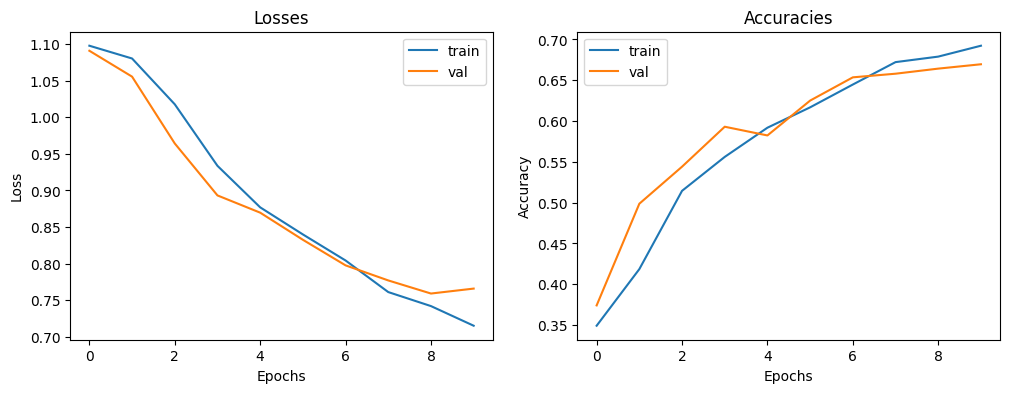

Test correct = 448

Test total dataitem = 750

Test Accuracy = 0.5973333120346069

              precision    recall  f1-score   support

    negative       0.57      0.70      0.63       250
     neutral       0.66      0.50      0.57       250
    positive       0.58      0.59      0.59       250

    accuracy                           0.60       750
   macro avg       0.60      0.60      0.60       750
weighted avg       0.60      0.60      0.60       750



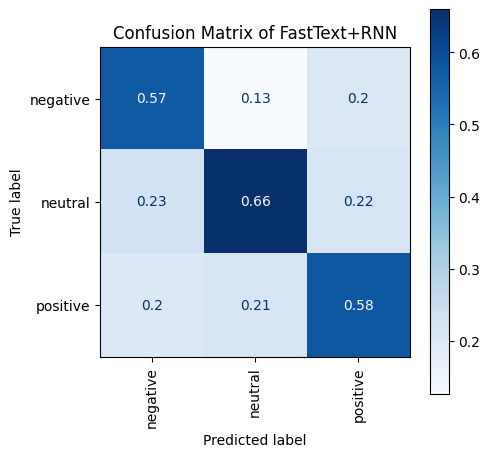

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You're on a {device}")
#hyperparameter
hidden_size1=128
hidden_size2=64
num_layers=1
bidirectional=True
freeze_embedding=True
droprate=0.5
learning_rate=0.0001
epoch=10
model=RNN(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
optimizer=optim.Adam(model.parameters(),lr=learning_rate) # play around this also
criterion=nn.CrossEntropyLoss()
train(model,epoch,optimizer,criterion,train_loader,val_loader)
model_name='FastText+RNN'
test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 72.97it/s]


loss = 1.0622528307442554, val_loss =0.9398648887392252, accuracy = 0.41221731901168823, val_accuracy = 0.5182546973228455


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 79.16it/s]


loss = 0.8923190926513053, val_loss =0.8091109699674971, accuracy = 0.5915514826774597, val_accuracy = 0.651825487613678


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 79.46it/s]


loss = 0.7949509353819303, val_loss =0.7587224645468051, accuracy = 0.6494975090026855, val_accuracy = 0.6598397493362427


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 78.84it/s]


loss = 0.738590632419473, val_loss =0.7761289526337928, accuracy = 0.6857725977897644, val_accuracy = 0.6464826464653015


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 76.36it/s]


loss = 0.70946447141725, val_loss =0.7245355405884939, accuracy = 0.7043027281761169, val_accuracy = 0.690115749835968


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 76.06it/s]


loss = 0.6841394597621183, val_loss =0.7467283952053144, accuracy = 0.715452253818512, val_accuracy = 0.6785396337509155


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 74.34it/s]


loss = 0.664218523947111, val_loss =0.7533527200339853, accuracy = 0.7244032621383667, val_accuracy = 0.6874443888664246


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 78.28it/s]


loss = 0.6234111534354906, val_loss =0.7456567262502162, accuracy = 0.7468593120574951, val_accuracy = 0.683882474899292


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 77.71it/s]


loss = 0.6081555303946061, val_loss =0.7537862213219457, accuracy = 0.7575376629829407, val_accuracy = 0.6918967366218567


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 78.04it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.5818525648257628, val_loss =0.7705804509712689, accuracy = 0.7635050415992737, val_accuracy = 0.6803205609321594


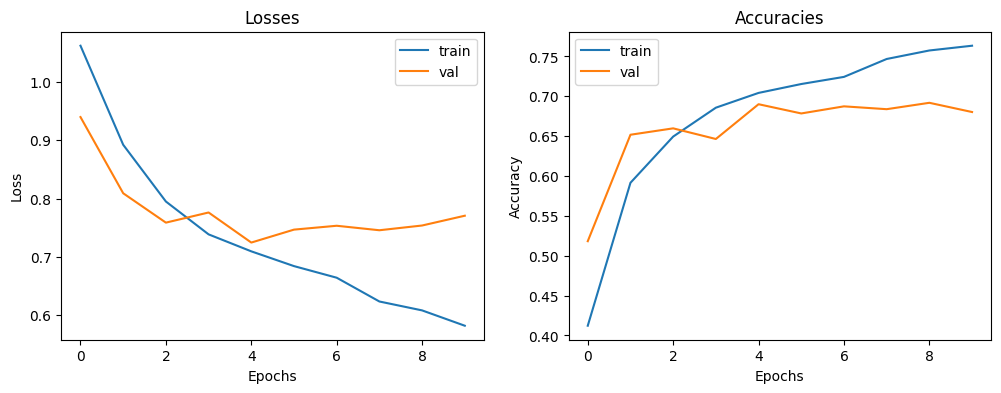

bidirectional = True
Test correct = 455

Test total dataitem = 750

Test Accuracy = 0.6066666841506958

              precision    recall  f1-score   support

    negative       0.61      0.66      0.63       250
     neutral       0.57      0.64      0.60       250
    positive       0.65      0.52      0.58       250

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



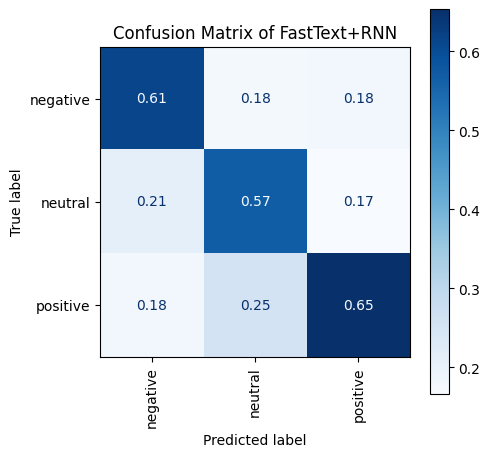

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 164.65it/s]


loss = 1.0968727970402687, val_loss =1.0769685657739285, accuracy = 0.3564698398113251, val_accuracy = 0.4336598515510559


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 163.45it/s]


loss = 1.0043036949296948, val_loss =0.9148980551757775, accuracy = 0.49324747920036316, val_accuracy = 0.5592163801193237


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 165.84it/s]


loss = 0.8795510017394554, val_loss =0.8390693364535562, accuracy = 0.5994032621383667, val_accuracy = 0.6099733114242554


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 164.72it/s]


loss = 0.8024359987539356, val_loss =0.7854361064769032, accuracy = 0.6501256227493286, val_accuracy = 0.6553874015808105


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 165.57it/s]


loss = 0.7603090608022103, val_loss =0.7641358223468405, accuracy = 0.6774497628211975, val_accuracy = 0.6598397493362427


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 166.06it/s]


loss = 0.7238063266682366, val_loss =0.7337662170110788, accuracy = 0.6970791220664978, val_accuracy = 0.6785396337509155


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 163.38it/s]


loss = 0.6956703310233298, val_loss =0.7271631885962543, accuracy = 0.7129396796226501, val_accuracy = 0.6856634020805359


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 156.37it/s]


loss = 0.6675789599715426, val_loss =0.7118805782260126, accuracy = 0.7275439500808716, val_accuracy = 0.6910062432289124


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 136.02it/s]


loss = 0.652396765336216, val_loss =0.7108571285745711, accuracy = 0.7368090152740479, val_accuracy = 0.699020504951477


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 138.11it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.635371252087998, val_loss =0.721408124482199, accuracy = 0.7470163106918335, val_accuracy = 0.6954585909843445


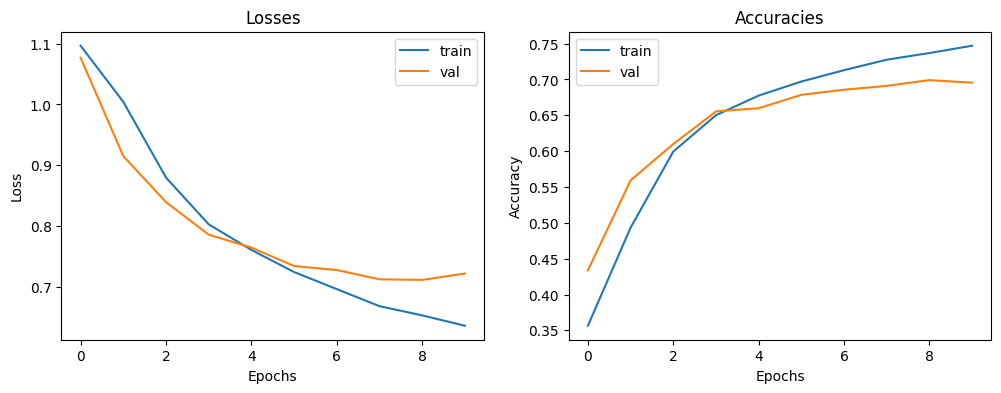

bidirectional = False
Test correct = 450

Test total dataitem = 750

Test Accuracy = 0.5999999642372131

              precision    recall  f1-score   support

    negative       0.59      0.65      0.62       250
     neutral       0.58      0.66      0.62       250
    positive       0.64      0.49      0.55       250

    accuracy                           0.60       750
   macro avg       0.60      0.60      0.60       750
weighted avg       0.60      0.60      0.60       750



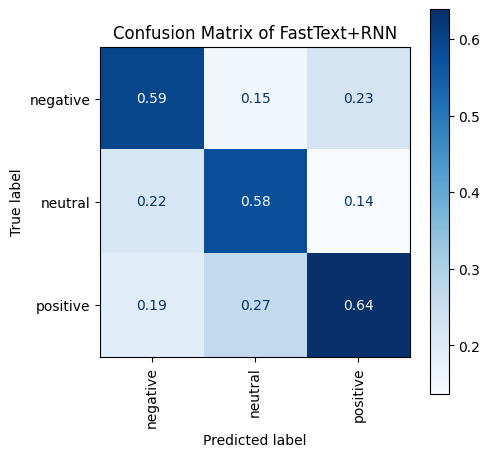

In [ ]:
#Experiment 1
#hyperparameter
bidirectional_options=[True,False]
for bidirectional1 in bidirectional_options:
  model=RNN(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional1).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+RNN'
  print(f'bidirectional = {bidirectional1}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 109.05it/s]


loss = 1.0923347052466124, val_loss =1.0789600627615101, accuracy = 0.37829774618148804, val_accuracy = 0.42297419905662537


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 234.60it/s]


loss = 1.032040103301406, val_loss =0.962185024699965, accuracy = 0.48413944244384766, val_accuracy = 0.5209261178970337


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 243.79it/s]


loss = 0.9459395390294958, val_loss =0.8939257996544863, accuracy = 0.5532349348068237, val_accuracy = 0.609082818031311


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 245.40it/s]


loss = 0.8843955870263744, val_loss =0.8643115478652781, accuracy = 0.6014447212219238, val_accuracy = 0.6064113974571228


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 236.30it/s]


loss = 0.8342971078767732, val_loss =0.8172021325337626, accuracy = 0.6289258599281311, val_accuracy = 0.6313446164131165


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 242.34it/s]


loss = 0.7969165284726478, val_loss =0.8031593070696256, accuracy = 0.6523241400718689, val_accuracy = 0.6331255435943604


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 234.43it/s]


loss = 0.7640101415316167, val_loss =0.7664502436777444, accuracy = 0.6697550415992737, val_accuracy = 0.6625111699104309


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 245.30it/s]


loss = 0.7498825904643308, val_loss =0.7582035789198319, accuracy = 0.6802763938903809, val_accuracy = 0.6767587065696716


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 231.46it/s]


loss = 0.7251067405796857, val_loss =0.7439985779387089, accuracy = 0.692054033279419, val_accuracy = 0.6740872859954834


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 244.34it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7049426793892689, val_loss =0.7399502256970866, accuracy = 0.7027323842048645, val_accuracy = 0.6767587065696716


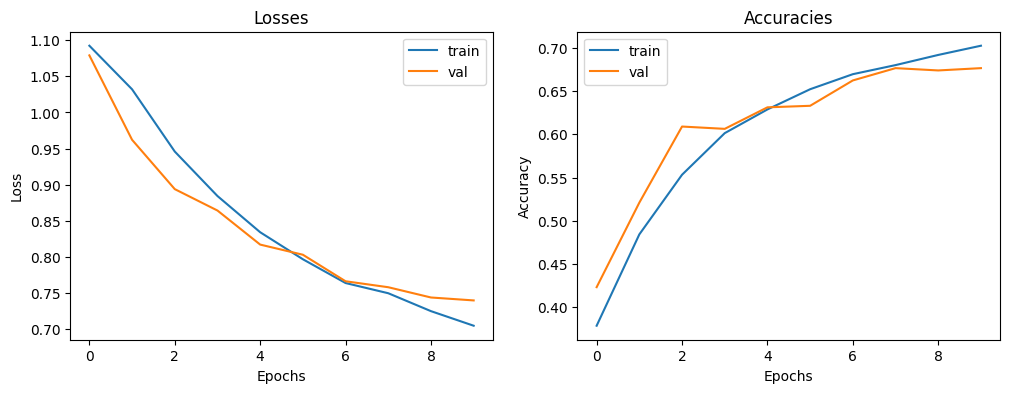

rnn_layers = 1
Test correct = 442

Test total dataitem = 750

Test Accuracy = 0.5893333554267883

              precision    recall  f1-score   support

    negative       0.70      0.54      0.61       250
     neutral       0.62      0.59      0.60       250
    positive       0.50      0.64      0.56       250

    accuracy                           0.59       750
   macro avg       0.61      0.59      0.59       750
weighted avg       0.61      0.59      0.59       750



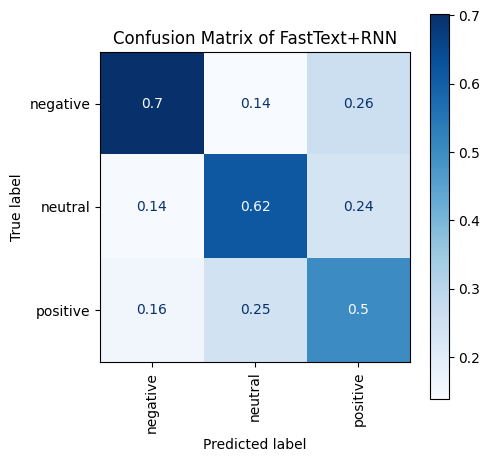

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 151.79it/s]


loss = 1.0893191312905401, val_loss =1.0637304673163546, accuracy = 0.38096731901168823, val_accuracy = 0.46215495467185974


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 142.70it/s]


loss = 0.9641985677037155, val_loss =0.8489457977067176, accuracy = 0.5538630485534668, val_accuracy = 0.6251113414764404


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 136.96it/s]


loss = 0.832400001190108, val_loss =0.8125059428637744, accuracy = 0.6367776393890381, val_accuracy = 0.6366874575614929


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 133.36it/s]


loss = 0.7733741645003829, val_loss =0.7737510689036248, accuracy = 0.6754083037376404, val_accuracy = 0.6625111699104309


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 133.72it/s]


loss = 0.727416192013643, val_loss =0.745903685378162, accuracy = 0.7047738432884216, val_accuracy = 0.6847729682922363


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 125.69it/s]


loss = 0.7053584334140396, val_loss =0.7220284667410721, accuracy = 0.7126256227493286, val_accuracy = 0.6936776638031006


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 143.29it/s]


loss = 0.6782450941208481, val_loss =0.7151766766607853, accuracy = 0.7289572954177856, val_accuracy = 0.6927871704101562


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 150.04it/s]


loss = 0.6700679733861443, val_loss =0.7117561345586196, accuracy = 0.7251884341239929, val_accuracy = 0.690115749835968


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 149.74it/s]


loss = 0.6426914914850431, val_loss =0.708959121250888, accuracy = 0.7474874258041382, val_accuracy = 0.699020504951477


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 149.95it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6408560844639988, val_loss =0.7069116658004027, accuracy = 0.7427763938903809, val_accuracy = 0.6999109983444214


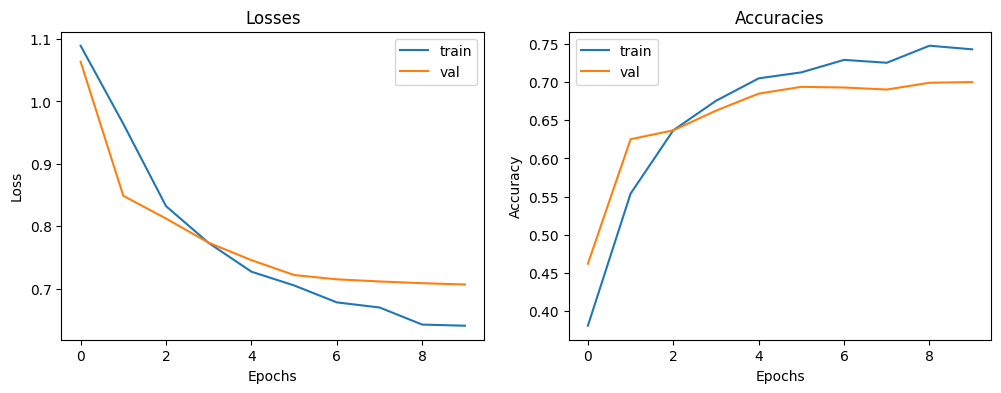

rnn_layers = 2
Test correct = 452

Test total dataitem = 750

Test Accuracy = 0.6026666760444641

              precision    recall  f1-score   support

    negative       0.64      0.58      0.61       250
     neutral       0.55      0.72      0.62       250
    positive       0.65      0.51      0.57       250

    accuracy                           0.60       750
   macro avg       0.61      0.60      0.60       750
weighted avg       0.61      0.60      0.60       750



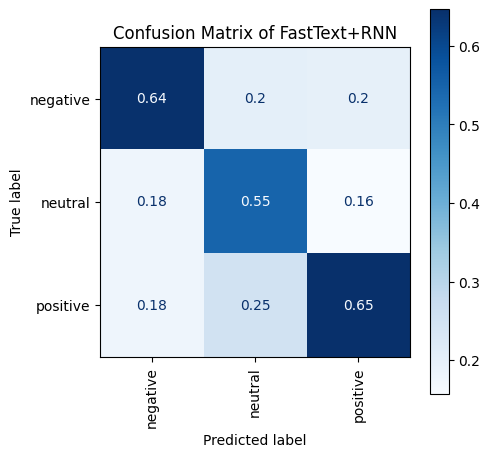

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 102.58it/s]


loss = 1.0778133768728002, val_loss =0.9829697323822608, accuracy = 0.4057788848876953, val_accuracy = 0.5235975384712219


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 102.69it/s]


loss = 0.9122319131215044, val_loss =0.8663816990565494, accuracy = 0.5871545076370239, val_accuracy = 0.5966162085533142


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 102.74it/s]


loss = 0.7946680321071472, val_loss =0.776931471011642, accuracy = 0.6559359431266785, val_accuracy = 0.6634016036987305


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 102.40it/s]


loss = 0.7543177173990625, val_loss =0.7623020202580225, accuracy = 0.6816896796226501, val_accuracy = 0.6589492559432983


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 102.12it/s]


loss = 0.7160600543508917, val_loss =0.7500311954650521, accuracy = 0.7043027281761169, val_accuracy = 0.6687444448471069


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 102.28it/s]


loss = 0.6813167630710495, val_loss =0.7226382600263893, accuracy = 0.7198492288589478, val_accuracy = 0.6794301271438599


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 97.18it/s]


loss = 0.6673551499386849, val_loss =0.7235164608804986, accuracy = 0.7278580069541931, val_accuracy = 0.6794301271438599


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 96.18it/s]


loss = 0.6453033326081413, val_loss =0.7253942789737642, accuracy = 0.7377512454986572, val_accuracy = 0.6847729682922363


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 97.11it/s]


loss = 0.6279879726957983, val_loss =0.7703286225538509, accuracy = 0.7509422302246094, val_accuracy = 0.6651825904846191


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 97.18it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.615551842645024, val_loss =0.7259286375731919, accuracy = 0.7539258599281311, val_accuracy = 0.6803205609321594


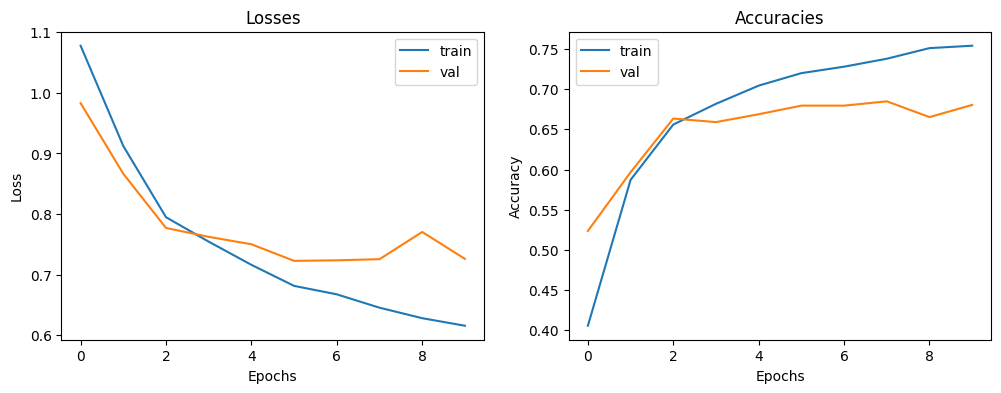

rnn_layers = 3
Test correct = 451

Test total dataitem = 750

Test Accuracy = 0.6013333201408386

              precision    recall  f1-score   support

    negative       0.64      0.57      0.60       250
     neutral       0.55      0.73      0.63       250
    positive       0.65      0.50      0.57       250

    accuracy                           0.60       750
   macro avg       0.61      0.60      0.60       750
weighted avg       0.61      0.60      0.60       750



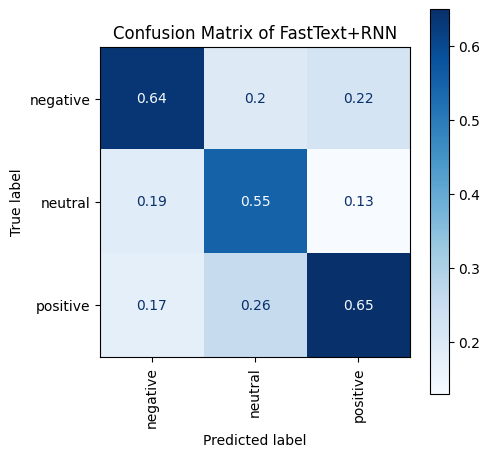

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 77.62it/s]


loss = 1.0708329994697123, val_loss =1.0012340479885184, accuracy = 0.42116832733154297, val_accuracy = 0.5342831611633301


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 77.44it/s]


loss = 0.8857815884356387, val_loss =0.8144150324971489, accuracy = 0.6072550415992737, val_accuracy = 0.6331255435943604


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 77.20it/s]


loss = 0.7966495017264242, val_loss =0.8185568091168534, accuracy = 0.6684987545013428, val_accuracy = 0.6366874575614929


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 77.19it/s]


loss = 0.7484778516023289, val_loss =0.7617823597899313, accuracy = 0.6873429417610168, val_accuracy = 0.6767587065696716


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 77.76it/s]


loss = 0.7042947557046136, val_loss =0.752629881384108, accuracy = 0.716865599155426, val_accuracy = 0.6758682131767273


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 77.80it/s]


loss = 0.683213535842724, val_loss =0.7606812784217052, accuracy = 0.7231469750404358, val_accuracy = 0.6740872859954834


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 76.28it/s]


loss = 0.654357278967791, val_loss =0.7475468465822886, accuracy = 0.7435615658760071, val_accuracy = 0.6856634020805359


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 76.03it/s]


loss = 0.6337989344519042, val_loss =0.8262364569881429, accuracy = 0.7484296560287476, val_accuracy = 0.6651825904846191


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 75.19it/s]


loss = 0.6143088339884821, val_loss =0.7564149471214651, accuracy = 0.7575376629829407, val_accuracy = 0.6794301271438599


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 76.62it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.5897837221978125, val_loss =0.7653155405309614, accuracy = 0.7631909251213074, val_accuracy = 0.6812110543251038


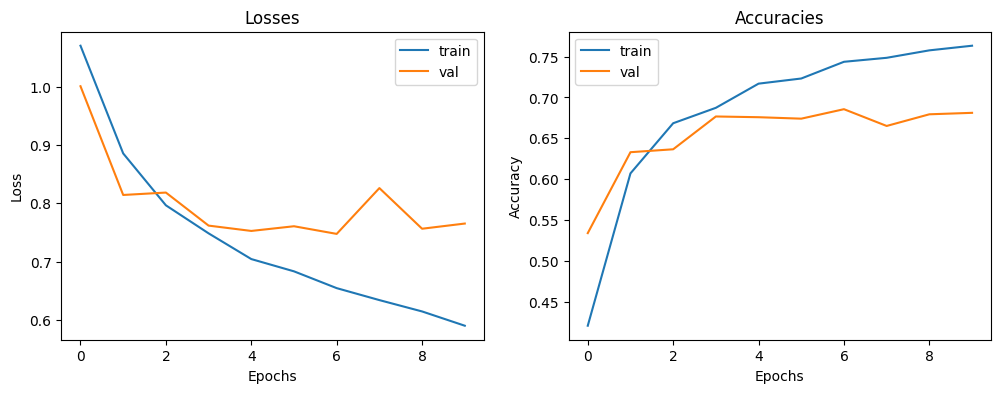

rnn_layers = 4
Test correct = 435

Test total dataitem = 750

Test Accuracy = 0.5799999833106995

              precision    recall  f1-score   support

    negative       0.67      0.49      0.56       250
     neutral       0.56      0.70      0.62       250
    positive       0.54      0.56      0.55       250

    accuracy                           0.58       750
   macro avg       0.59      0.58      0.58       750
weighted avg       0.59      0.58      0.58       750



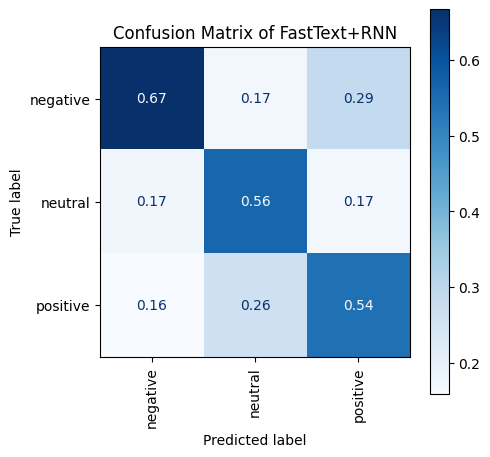

In [ ]:
bidirectional=True
rnn_layers=[1,2,3,4]
for rnn_layer in rnn_layers:
  model=RNN(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,rnn_layer,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+RNN'
  print(f'rnn_layers = {rnn_layer}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 156.31it/s]


loss = 1.0978039870131762, val_loss =1.0960959833869266, accuracy = 0.3498743772506714, val_accuracy = 0.3713268041610718


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 150.60it/s]


loss = 1.0917497327364982, val_loss =1.0907963289760998, accuracy = 0.3771984875202179, val_accuracy = 0.39626002311706543


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 152.29it/s]


loss = 1.0846609992068261, val_loss =1.083707924808065, accuracy = 0.40876254439353943, val_accuracy = 0.4300979673862457


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 158.65it/s]


loss = 1.0761695003230125, val_loss =1.0728505860526292, accuracy = 0.4279208481311798, val_accuracy = 0.43633127212524414


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 228.86it/s]


loss = 1.061092769820243, val_loss =1.0540550198080758, accuracy = 0.4510050117969513, val_accuracy = 0.44879788160324097


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 257.47it/s]


loss = 1.0332358245458453, val_loss =1.0209372961782808, accuracy = 0.49152010679244995, val_accuracy = 0.48619771003723145


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 238.78it/s]


loss = 0.9918879203824327, val_loss =0.9774782436456354, accuracy = 0.521513819694519, val_accuracy = 0.5289403796195984


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 247.24it/s]


loss = 0.9501307119301055, val_loss =0.9473705271750481, accuracy = 0.5549622774124146, val_accuracy = 0.5467497706413269


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 241.66it/s]


loss = 0.9211291696049738, val_loss =0.917778557033411, accuracy = 0.5717650651931763, val_accuracy = 0.5565449595451355


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 244.98it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.8876387154310942, val_loss =0.8926035176587498, accuracy = 0.5943781137466431, val_accuracy = 0.5681211352348328


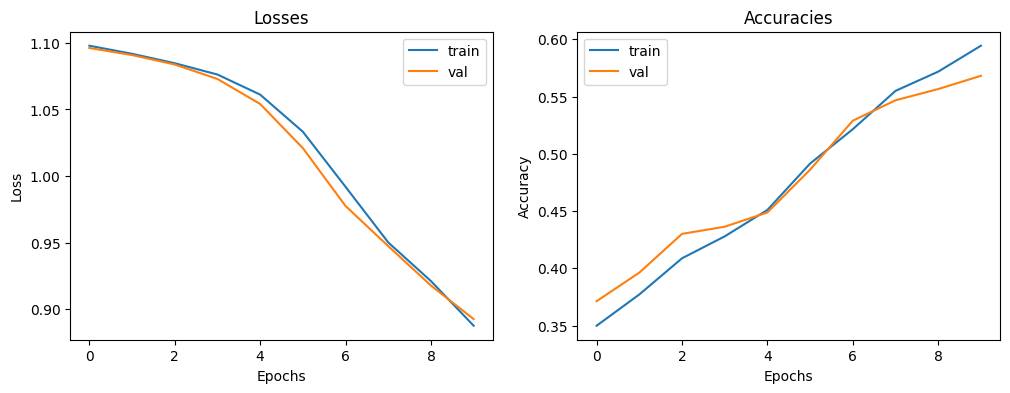

rnn_hidden = 32
Test correct = 431

Test total dataitem = 750

Test Accuracy = 0.5746666789054871

              precision    recall  f1-score   support

    negative       0.55      0.76      0.64       250
     neutral       0.59      0.62      0.60       250
    positive       0.60      0.35      0.44       250

    accuracy                           0.57       750
   macro avg       0.58      0.57      0.56       750
weighted avg       0.58      0.57      0.56       750



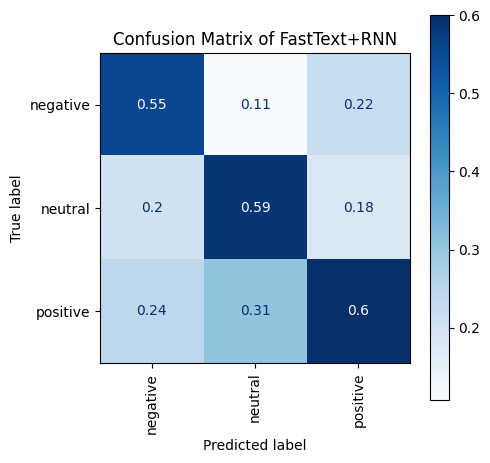

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 223.42it/s]


loss = 1.096229422800243, val_loss =1.0923672898894266, accuracy = 0.362908273935318, val_accuracy = 0.3615316152572632


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 231.50it/s]


loss = 1.0835147511027754, val_loss =1.0709964118602258, accuracy = 0.4049937129020691, val_accuracy = 0.48174533247947693


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 234.12it/s]


loss = 1.0338557032123208, val_loss =0.9985018528280928, accuracy = 0.49638819694519043, val_accuracy = 0.519145131111145


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 230.88it/s]


loss = 0.9433182028075681, val_loss =0.9008284147873167, accuracy = 0.5701947212219238, val_accuracy = 0.6224399209022522


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 175.02it/s]


loss = 0.8670605226955377, val_loss =0.8668868427726603, accuracy = 0.6196607947349548, val_accuracy = 0.6144256591796875


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 172.26it/s]


loss = 0.8253814422810684, val_loss =0.8179953025051555, accuracy = 0.6447864174842834, val_accuracy = 0.6509349942207336


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 168.93it/s]


loss = 0.7951410578614742, val_loss =0.7978286376444711, accuracy = 0.6648869514465332, val_accuracy = 0.6536064147949219


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 173.67it/s]


loss = 0.771614344001282, val_loss =0.8000112791660257, accuracy = 0.6746231317520142, val_accuracy = 0.651825487613678


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 155.45it/s]


loss = 0.749303570846605, val_loss =0.7648559341253344, accuracy = 0.6865577697753906, val_accuracy = 0.6714158654212952


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 164.85it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7354378252843162, val_loss =0.7637434878492809, accuracy = 0.6994346380233765, val_accuracy = 0.6785396337509155


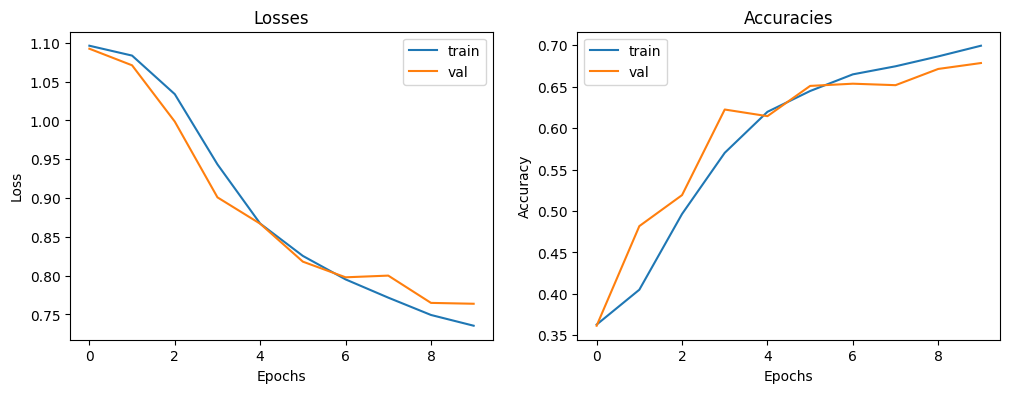

rnn_hidden = 64
Test correct = 467

Test total dataitem = 750

Test Accuracy = 0.6226666569709778

              precision    recall  f1-score   support

    negative       0.63      0.67      0.65       250
     neutral       0.65      0.61      0.63       250
    positive       0.59      0.59      0.59       250

    accuracy                           0.62       750
   macro avg       0.62      0.62      0.62       750
weighted avg       0.62      0.62      0.62       750



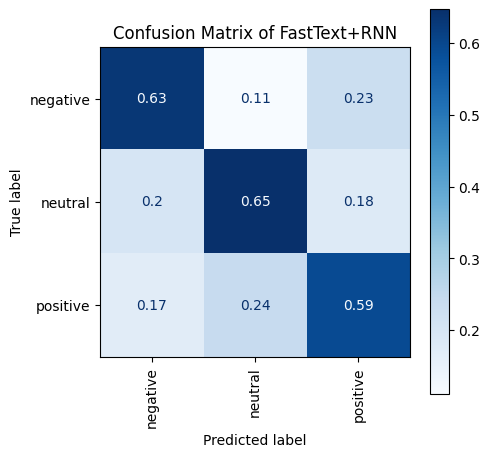

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 208.73it/s]


loss = 1.097248019967228, val_loss =1.0886190924305648, accuracy = 0.35489949584007263, val_accuracy = 0.4452359974384308


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 240.15it/s]


loss = 1.062625250616111, val_loss =1.0160033292964927, accuracy = 0.4513190984725952, val_accuracy = 0.5262689590454102


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 234.92it/s]


loss = 0.9412097485456615, val_loss =0.8711694405776345, accuracy = 0.5646984577178955, val_accuracy = 0.6099733114242554


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 246.50it/s]


loss = 0.8536147131817415, val_loss =0.8121221585694465, accuracy = 0.6309673190116882, val_accuracy = 0.6402493715286255


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 222.49it/s]


loss = 0.7976154470353504, val_loss =0.7754574379054016, accuracy = 0.6669284105300903, val_accuracy = 0.6598397493362427


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 235.51it/s]


loss = 0.7675134604917548, val_loss =0.7603185642595655, accuracy = 0.6780778765678406, val_accuracy = 0.658058762550354


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 224.90it/s]


loss = 0.7426074518736278, val_loss =0.7470990997340922, accuracy = 0.6956658363342285, val_accuracy = 0.6714158654212952


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 240.08it/s]


loss = 0.7241359731649937, val_loss =0.74967612018781, accuracy = 0.7068153023719788, val_accuracy = 0.6731967926025391


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 218.77it/s]


loss = 0.7105422524652386, val_loss =0.7384240657349842, accuracy = 0.7130967378616333, val_accuracy = 0.6803205609321594


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 242.77it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7000605504297346, val_loss =0.7395764054697734, accuracy = 0.7137248516082764, val_accuracy = 0.677649199962616


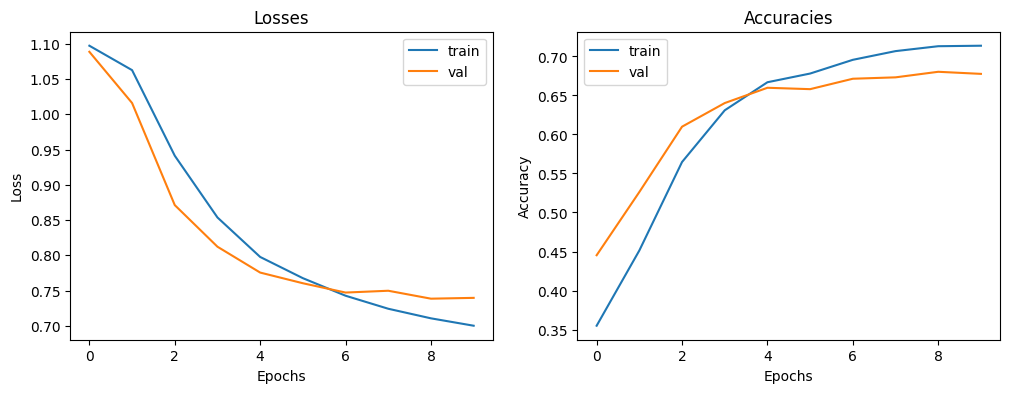

rnn_hidden = 128
Test correct = 460

Test total dataitem = 750

Test Accuracy = 0.6133333444595337

              precision    recall  f1-score   support

    negative       0.61      0.71      0.65       250
     neutral       0.58      0.65      0.61       250
    positive       0.69      0.48      0.56       250

    accuracy                           0.61       750
   macro avg       0.62      0.61      0.61       750
weighted avg       0.62      0.61      0.61       750



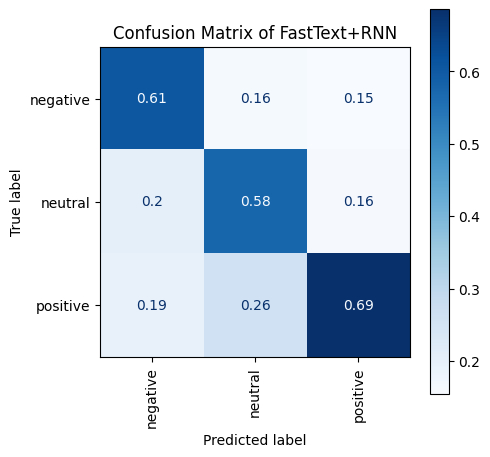

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 149.37it/s]


loss = 1.080847565215081, val_loss =1.0182655652275399, accuracy = 0.3983982503414154, val_accuracy = 0.4951024055480957


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 151.01it/s]


loss = 0.9496668719820446, val_loss =0.883053714131552, accuracy = 0.5423994660377502, val_accuracy = 0.5868210196495056


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 150.19it/s]


loss = 0.8400273794468376, val_loss =0.805014605584207, accuracy = 0.6226444840431213, val_accuracy = 0.6429207921028137


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 149.74it/s]


loss = 0.7713725615568546, val_loss =0.7738494123085513, accuracy = 0.6686557531356812, val_accuracy = 0.6642920970916748


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 149.64it/s]


loss = 0.7383184192969929, val_loss =0.7473767457934585, accuracy = 0.6923680901527405, val_accuracy = 0.6785396337509155


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 135.86it/s]


loss = 0.706205778393487, val_loss =0.7414083203990086, accuracy = 0.7050879597663879, val_accuracy = 0.6767587065696716


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 129.08it/s]


loss = 0.6898052298876973, val_loss =0.7406067997200316, accuracy = 0.7215766310691833, val_accuracy = 0.6883348226547241


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 133.45it/s]


loss = 0.6638741758454034, val_loss =0.7542564659569406, accuracy = 0.7278580069541931, val_accuracy = 0.6714158654212952


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 128.75it/s]


loss = 0.6544458668429707, val_loss =0.725499697876639, accuracy = 0.7309987545013428, val_accuracy = 0.6954585909843445


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 129.56it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6330845556875738, val_loss =0.7273857202806655, accuracy = 0.7489007711410522, val_accuracy = 0.6767587065696716


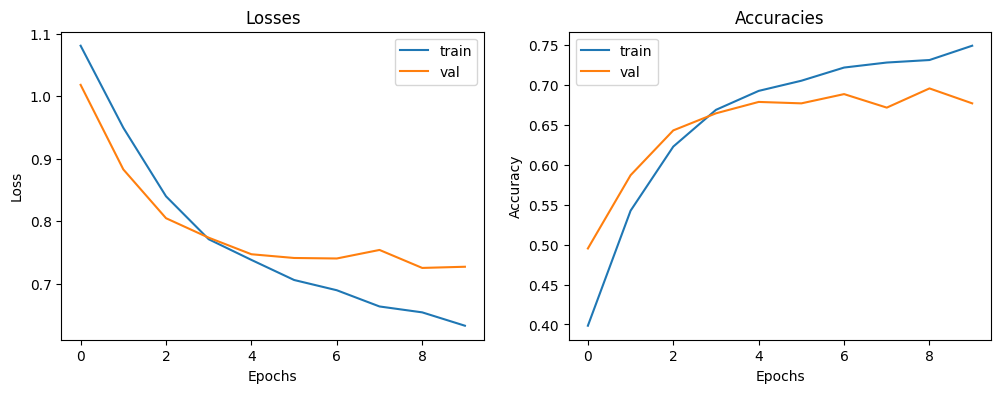

rnn_hidden = 256
Test correct = 464

Test total dataitem = 750

Test Accuracy = 0.6186666488647461

              precision    recall  f1-score   support

    negative       0.62      0.66      0.64       250
     neutral       0.57      0.70      0.63       250
    positive       0.71      0.50      0.58       250

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.62       750
weighted avg       0.63      0.62      0.62       750



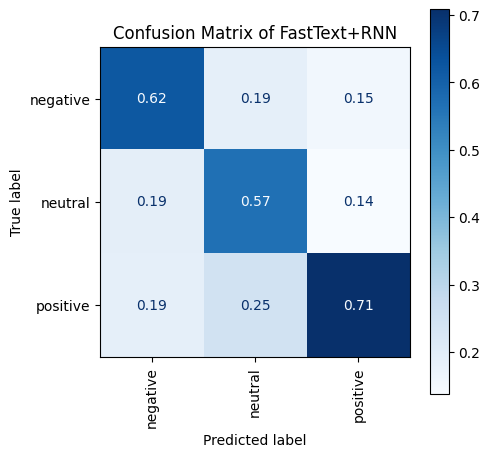

In [ ]:
bidirectional=True
num_layers=2
rnn_hidden_size=[32,64,128,256]
for rnn_hidden in rnn_hidden_size:
  model=RNN(fasttext_weights,rnn_hidden,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+RNN'
  print(f'rnn_hidden = {rnn_hidden}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 241.63it/s]


loss = 1.0990335129853337, val_loss =1.0968905293249658, accuracy = 0.3450062870979309, val_accuracy = 0.3677649199962616


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 239.95it/s]


loss = 1.0920593927334994, val_loss =1.0902474929342076, accuracy = 0.3900753855705261, val_accuracy = 0.40694570541381836


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 236.93it/s]


loss = 1.0793326410930604, val_loss =1.0757685936248256, accuracy = 0.42902010679244995, val_accuracy = 0.46215495467185974


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 247.63it/s]


loss = 1.0515982285607606, val_loss =1.0369768275354532, accuracy = 0.47675877809524536, val_accuracy = 0.463935911655426


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 238.57it/s]


loss = 0.9923335565149318, val_loss =0.974015225305976, accuracy = 0.5290514826774597, val_accuracy = 0.5494211912155151


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 238.80it/s]


loss = 0.9359228727174923, val_loss =0.9133581804592045, accuracy = 0.5673680901527405, val_accuracy = 0.5823686718940735


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 236.43it/s]


loss = 0.8850779774633701, val_loss =0.8766537506406801, accuracy = 0.6105527281761169, val_accuracy = 0.6046304702758789


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 240.67it/s]


loss = 0.8564861140650464, val_loss =0.8353781940064408, accuracy = 0.6226444840431213, val_accuracy = 0.6509349942207336


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 215.41it/s]


loss = 0.8262087492636055, val_loss =0.8248918576879309, accuracy = 0.6458856463432312, val_accuracy = 0.6322351098060608


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 174.77it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7991684970498318, val_loss =0.7987569007874717, accuracy = 0.6631595492362976, val_accuracy = 0.6527159810066223


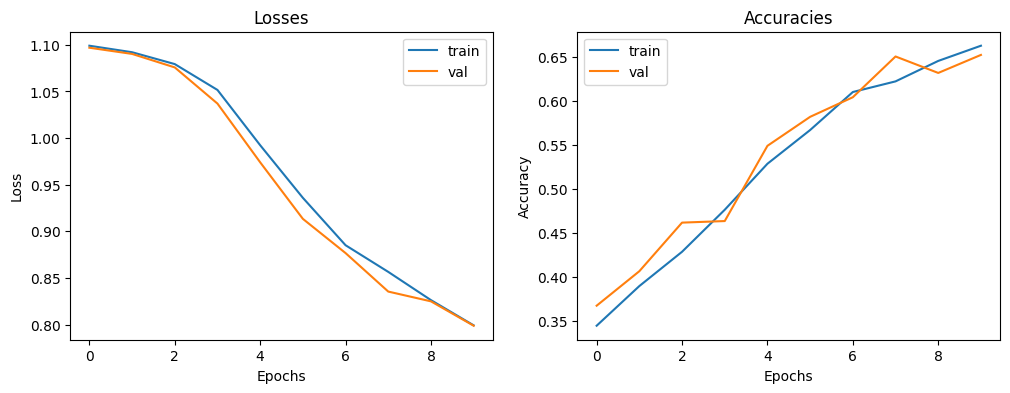

fc_hidden = 16
Test correct = 455

Test total dataitem = 750

Test Accuracy = 0.6066666841506958

              precision    recall  f1-score   support

    negative       0.64      0.63      0.64       250
     neutral       0.59      0.64      0.61       250
    positive       0.59      0.55      0.57       250

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



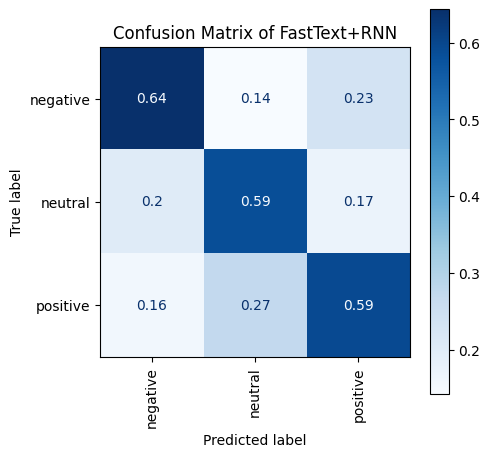

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 171.56it/s]


loss = 1.1005694293696433, val_loss =1.0950582922465864, accuracy = 0.3570979833602905, val_accuracy = 0.3401602804660797


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 164.25it/s]


loss = 1.08624204848893, val_loss =1.0803311348833615, accuracy = 0.39698493480682373, val_accuracy = 0.4318788945674896


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 167.39it/s]


loss = 1.0663593187602236, val_loss =1.0495613878607633, accuracy = 0.43420225381851196, val_accuracy = 0.44790738821029663


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 169.41it/s]


loss = 1.0059310959442518, val_loss =0.9669097800465626, accuracy = 0.4996859133243561, val_accuracy = 0.49421194195747375


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 235.70it/s]


loss = 0.9359919228637591, val_loss =0.8956772200922143, accuracy = 0.5427135825157166, val_accuracy = 0.5583259463310242


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 226.81it/s]


loss = 0.8896790501789655, val_loss =0.8539909523981993, accuracy = 0.5712939500808716, val_accuracy = 0.6153161525726318


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 246.61it/s]


loss = 0.8508385979518062, val_loss =0.8291186277813736, accuracy = 0.606783926486969, val_accuracy = 0.641139805316925


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 226.48it/s]


loss = 0.8106175926134165, val_loss =0.7951059612537926, accuracy = 0.641331672668457, val_accuracy = 0.6500445604324341


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 247.08it/s]


loss = 0.7784794854398933, val_loss =0.7858459761087221, accuracy = 0.6681846380233765, val_accuracy = 0.6598397493362427


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 228.22it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7520297989916435, val_loss =0.764098338277859, accuracy = 0.684202253818512, val_accuracy = 0.6589492559432983


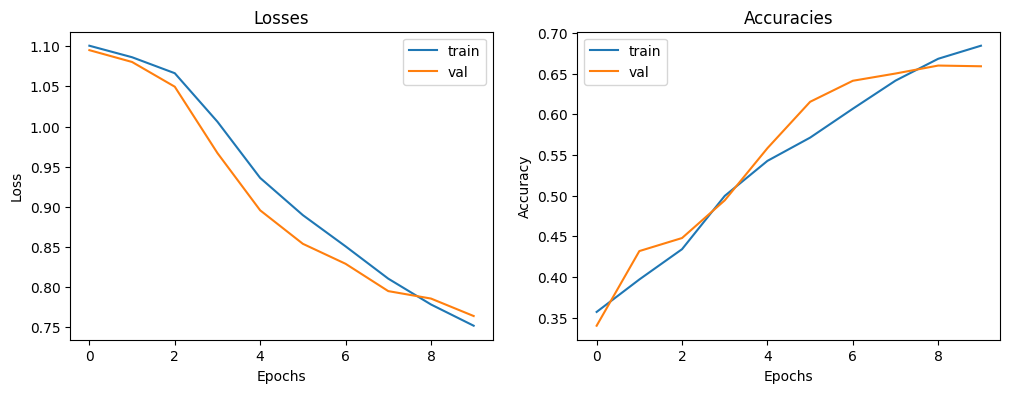

fc_hidden = 32
Test correct = 470

Test total dataitem = 750

Test Accuracy = 0.6266666650772095

              precision    recall  f1-score   support

    negative       0.65      0.66      0.65       250
     neutral       0.60      0.68      0.64       250
    positive       0.64      0.54      0.58       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.63       750
weighted avg       0.63      0.63      0.63       750



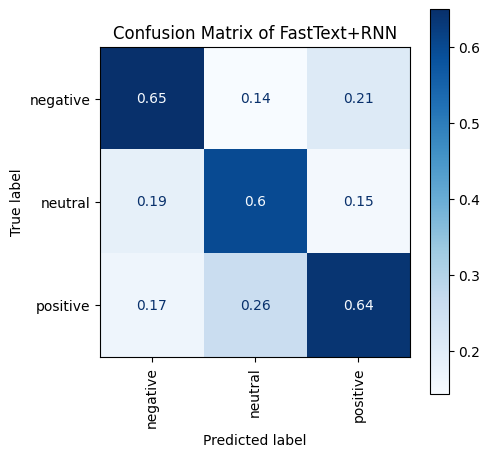

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 226.88it/s]


loss = 1.0952283177897335, val_loss =1.0907567187921987, accuracy = 0.3676193356513977, val_accuracy = 0.42297419905662537


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 237.50it/s]


loss = 1.0822450505197048, val_loss =1.0724207396752068, accuracy = 0.4345163404941559, val_accuracy = 0.4372217357158661


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 224.84it/s]


loss = 1.0296460821619258, val_loss =0.9872863799754885, accuracy = 0.4973303973674774, val_accuracy = 0.4995547831058502


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 240.39it/s]


loss = 0.9341819448338355, val_loss =0.892157137971593, accuracy = 0.5576319098472595, val_accuracy = 0.6073018908500671


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 207.08it/s]


loss = 0.865143696279265, val_loss =0.837927631447683, accuracy = 0.611966073513031, val_accuracy = 0.6224399209022522


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 242.15it/s]


loss = 0.8088914757629391, val_loss =0.8106242967747329, accuracy = 0.6408605575561523, val_accuracy = 0.6322351098060608


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 221.28it/s]


loss = 0.7838073848396016, val_loss =0.7839609365076906, accuracy = 0.6567211151123047, val_accuracy = 0.6589492559432983


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 239.03it/s]


loss = 0.7465827284449188, val_loss =0.7661307255749494, accuracy = 0.6838881969451904, val_accuracy = 0.6607301831245422


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 227.81it/s]


loss = 0.7321670244545385, val_loss =0.7553249606030202, accuracy = 0.6909547448158264, val_accuracy = 0.6705253720283508


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 230.83it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7210812322616402, val_loss =0.7604991153375031, accuracy = 0.6981784105300903, val_accuracy = 0.6651825904846191


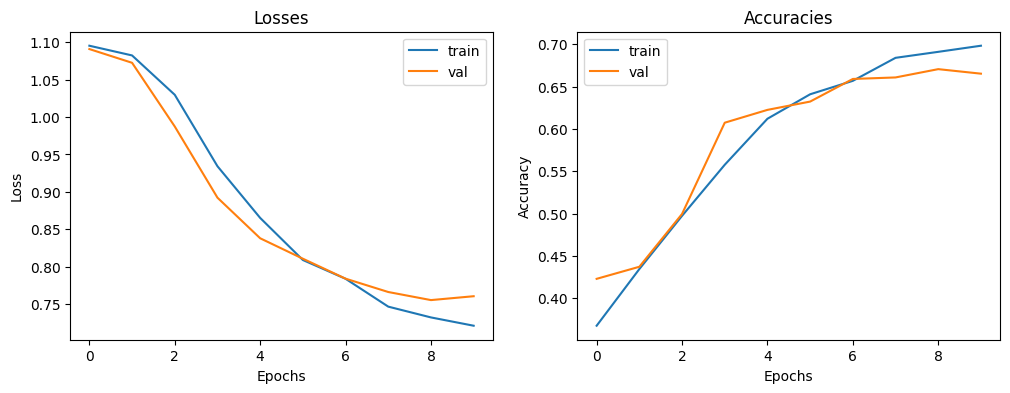

fc_hidden = 64
Test correct = 461

Test total dataitem = 750

Test Accuracy = 0.6146666407585144

              precision    recall  f1-score   support

    negative       0.66      0.64      0.65       250
     neutral       0.55      0.73      0.63       250
    positive       0.66      0.48      0.55       250

    accuracy                           0.61       750
   macro avg       0.63      0.61      0.61       750
weighted avg       0.63      0.61      0.61       750



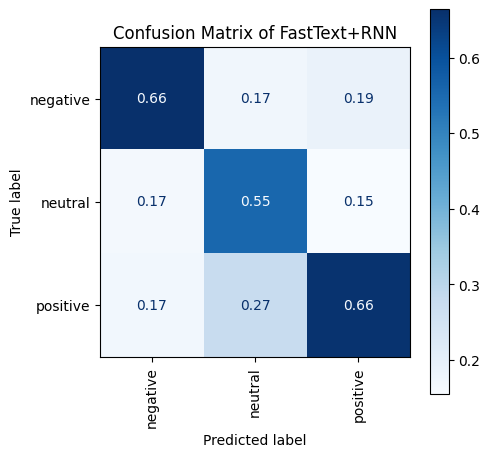

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 245.09it/s]


loss = 1.0940812659915538, val_loss =1.0886322895345826, accuracy = 0.36604899168014526, val_accuracy = 0.41050758957862854


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 216.11it/s]


loss = 1.07538160815835, val_loss =1.061628100141469, accuracy = 0.4409547746181488, val_accuracy = 0.4790739119052887


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 166.71it/s]


loss = 1.0191845448873937, val_loss =0.9763237621221277, accuracy = 0.5166457295417786, val_accuracy = 0.5120213627815247


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 175.16it/s]


loss = 0.9132050587586127, val_loss =0.8774066679345975, accuracy = 0.5739635825157166, val_accuracy = 0.5975067019462585


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 169.52it/s]


loss = 0.8297639501627418, val_loss =0.8218491871320155, accuracy = 0.6331658363342285, val_accuracy = 0.6295636892318726


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 170.95it/s]


loss = 0.7726967814992531, val_loss =0.7846002957839999, accuracy = 0.6619032621383667, val_accuracy = 0.6589492559432983


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 158.44it/s]


loss = 0.7427505037310767, val_loss =0.766807371184289, accuracy = 0.6783919334411621, val_accuracy = 0.6598397493362427


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 157.72it/s]


loss = 0.7256571023663128, val_loss =0.7643976695289547, accuracy = 0.692682147026062, val_accuracy = 0.6731967926025391


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 165.83it/s]


loss = 0.7066157909405593, val_loss =0.7417363930759685, accuracy = 0.6989635825157166, val_accuracy = 0.677649199962616


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 223.76it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6864031346927186, val_loss =0.7281755389295295, accuracy = 0.7134107947349548, val_accuracy = 0.6856634020805359


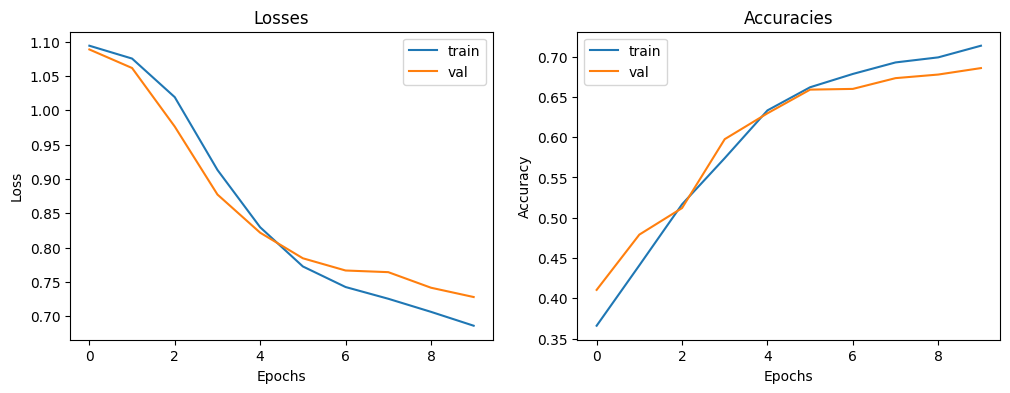

fc_hidden = 128
Test correct = 470

Test total dataitem = 750

Test Accuracy = 0.6266666650772095

              precision    recall  f1-score   support

    negative       0.65      0.64      0.65       250
     neutral       0.61      0.67      0.64       250
    positive       0.62      0.56      0.59       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.63       750
weighted avg       0.63      0.63      0.63       750



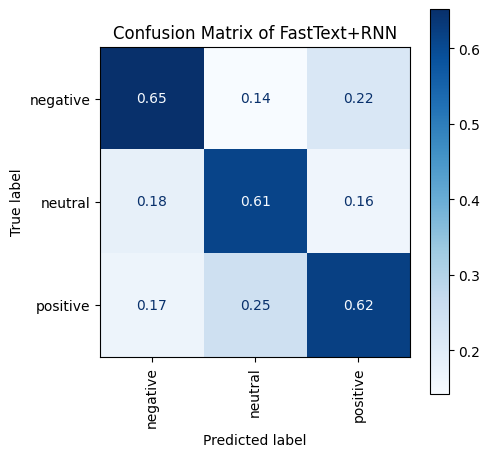

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 234.91it/s]


loss = 1.09418721659109, val_loss =1.090233352131373, accuracy = 0.3632223606109619, val_accuracy = 0.4176313579082489


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 233.70it/s]


loss = 1.0773176665231585, val_loss =1.063386039004203, accuracy = 0.44252511858940125, val_accuracy = 0.5111309289932251


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 218.85it/s]


loss = 1.003397323458921, val_loss =0.9325197281404621, accuracy = 0.5303077697753906, val_accuracy = 0.5681211352348328


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 237.33it/s]


loss = 0.8770889358222484, val_loss =0.8513666850239379, accuracy = 0.6020728349685669, val_accuracy = 0.6170970797538757


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 232.63it/s]


loss = 0.8048278535349528, val_loss =0.8114563144078212, accuracy = 0.6425879597663879, val_accuracy = 0.6455921530723572


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 224.27it/s]


loss = 0.7619024642738804, val_loss =0.7875101279602238, accuracy = 0.6708542704582214, val_accuracy = 0.651825487613678


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 225.21it/s]


loss = 0.7294616145378677, val_loss =0.7828366409154287, accuracy = 0.6912688612937927, val_accuracy = 0.6660730242729187


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 234.23it/s]


loss = 0.7161931775599077, val_loss =0.7793818590355046, accuracy = 0.6992776393890381, val_accuracy = 0.6589492559432983


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 226.54it/s]


loss = 0.6993348937456176, val_loss =0.7719624563905647, accuracy = 0.7082286477088928, val_accuracy = 0.6589492559432983


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 228.71it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6832798328340869, val_loss =0.7613906483818215, accuracy = 0.7156093120574951, val_accuracy = 0.6714158654212952


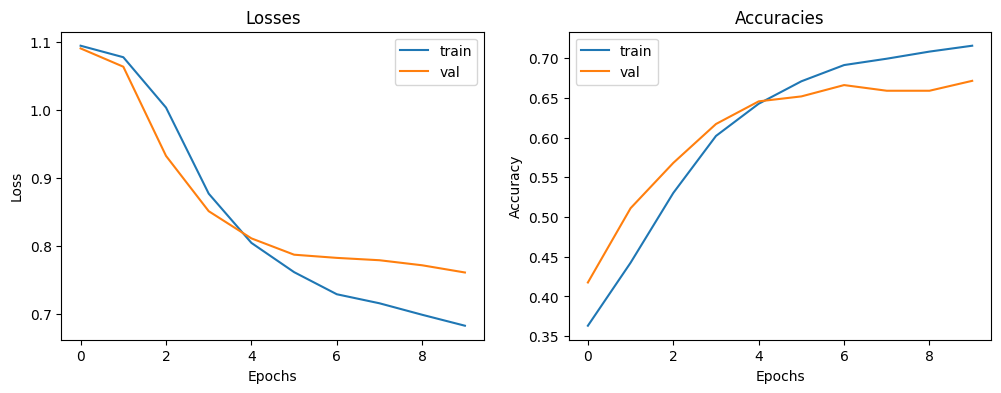

fc_hidden = 256
Test correct = 465

Test total dataitem = 750

Test Accuracy = 0.6200000047683716

              precision    recall  f1-score   support

    negative       0.64      0.69      0.66       250
     neutral       0.59      0.66      0.62       250
    positive       0.64      0.51      0.57       250

    accuracy                           0.62       750
   macro avg       0.62      0.62      0.62       750
weighted avg       0.62      0.62      0.62       750



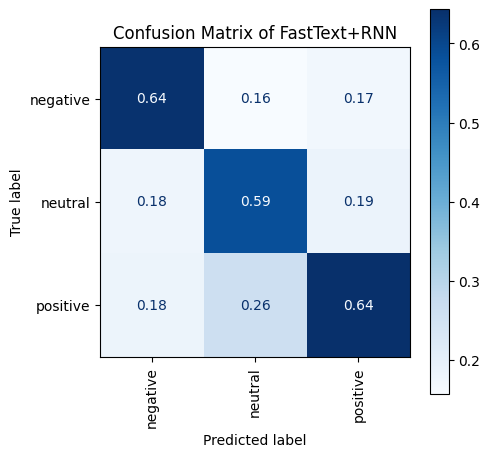

In [ ]:
bidirectional=True
num_layers=2
hidden_size1=64
fc_hidden_size=[16,32,64,128,256]
for fc_hidden in fc_hidden_size:
  model=RNN(fasttext_weights,hidden_size1,fc_hidden,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)

  model_name='FastText+RNN'
  print(f'fc_hidden = {fc_hidden}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 149.34it/s]


loss = 1.0922119914088397, val_loss =1.086887110460786, accuracy = 0.3900753855705261, val_accuracy = 0.44434550404548645


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 159.45it/s]


loss = 1.0613229925557972, val_loss =1.03820651839709, accuracy = 0.5023555159568787, val_accuracy = 0.5120213627815247


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 153.25it/s]


loss = 0.9501334006921388, val_loss =0.8956367855392663, accuracy = 0.5741205811500549, val_accuracy = 0.577025830745697


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 211.17it/s]


loss = 0.8390559320047032, val_loss =0.8386686502163121, accuracy = 0.6287688612937927, val_accuracy = 0.6206589937210083


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 231.61it/s]


loss = 0.7817398468940518, val_loss =0.8139540583085609, accuracy = 0.65625, val_accuracy = 0.634906530380249


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 237.99it/s]


loss = 0.7470249140472152, val_loss =0.7946533162844375, accuracy = 0.6787060499191284, val_accuracy = 0.6429207921028137


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 232.57it/s]


loss = 0.7263835674306028, val_loss =0.780046647077515, accuracy = 0.6879711151123047, val_accuracy = 0.6642920970916748


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 238.72it/s]


loss = 0.7057084127428243, val_loss =0.7722424261932564, accuracy = 0.700533926486969, val_accuracy = 0.6634016036987305


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 199.03it/s]


loss = 0.6864125206423342, val_loss =0.7607584603852408, accuracy = 0.7126256227493286, val_accuracy = 0.6625111699104309


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 179.67it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6736724121915176, val_loss =0.7578645078044493, accuracy = 0.7159233689308167, val_accuracy = 0.6740872859954834


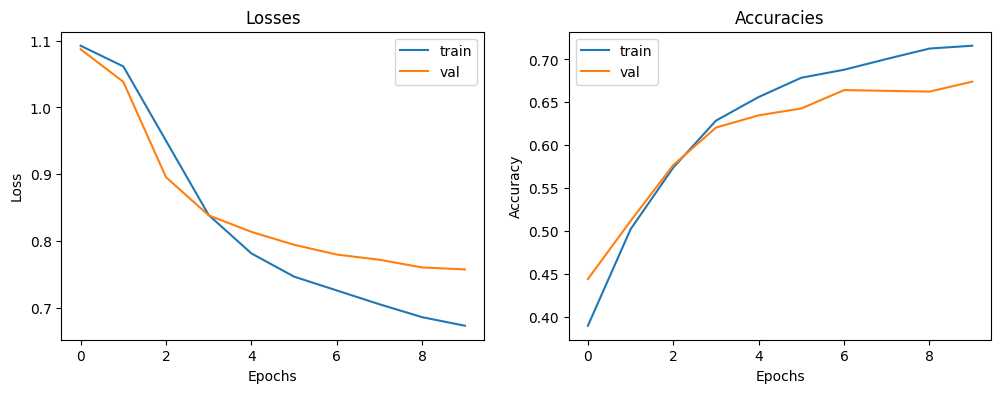

drop_rate = 0.1
Test correct = 471

Test total dataitem = 750

Test Accuracy = 0.628000020980835

              precision    recall  f1-score   support

    negative       0.64      0.68      0.66       250
     neutral       0.60      0.67      0.63       250
    positive       0.65      0.54      0.59       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.63       750
weighted avg       0.63      0.63      0.63       750



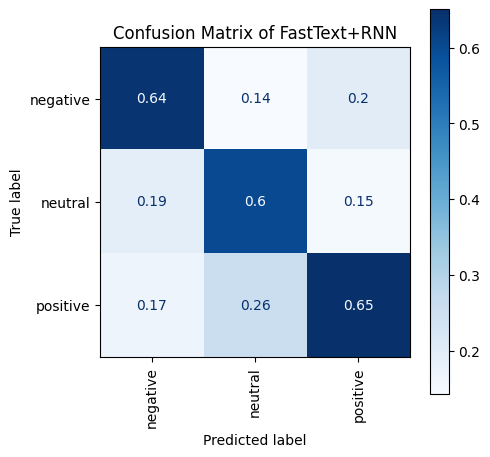

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 165.71it/s]


loss = 1.09286962646991, val_loss =1.0865902401432987, accuracy = 0.3831658363342285, val_accuracy = 0.4300979673862457


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 167.64it/s]


loss = 1.0640525987185538, val_loss =1.0355033947997505, accuracy = 0.4871231019496918, val_accuracy = 0.5120213627815247


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 165.49it/s]


loss = 0.9551558126229793, val_loss =0.9089315904577868, accuracy = 0.5651695728302002, val_accuracy = 0.5592163801193237


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 240.31it/s]


loss = 0.821025964099681, val_loss =0.8189209448798219, accuracy = 0.6381909251213074, val_accuracy = 0.6135351657867432


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 233.65it/s]


loss = 0.7669071497171536, val_loss =0.7930440778080892, accuracy = 0.6601758599281311, val_accuracy = 0.6491540670394897


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 242.47it/s]


loss = 0.7388094841726707, val_loss =0.7894380759006174, accuracy = 0.682317852973938, val_accuracy = 0.6420302987098694


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 246.72it/s]


loss = 0.7147338219991071, val_loss =0.7578696445535614, accuracy = 0.6925250887870789, val_accuracy = 0.6589492559432983


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 248.14it/s]


loss = 0.6957487369795854, val_loss =0.7603163972918761, accuracy = 0.7036746144294739, val_accuracy = 0.6660730242729187


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 251.45it/s]


loss = 0.6791464155317226, val_loss =0.7459000600553636, accuracy = 0.7104271054267883, val_accuracy = 0.6651825904846191


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 236.07it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6654250960600621, val_loss =0.7320117127705811, accuracy = 0.7209484577178955, val_accuracy = 0.6758682131767273


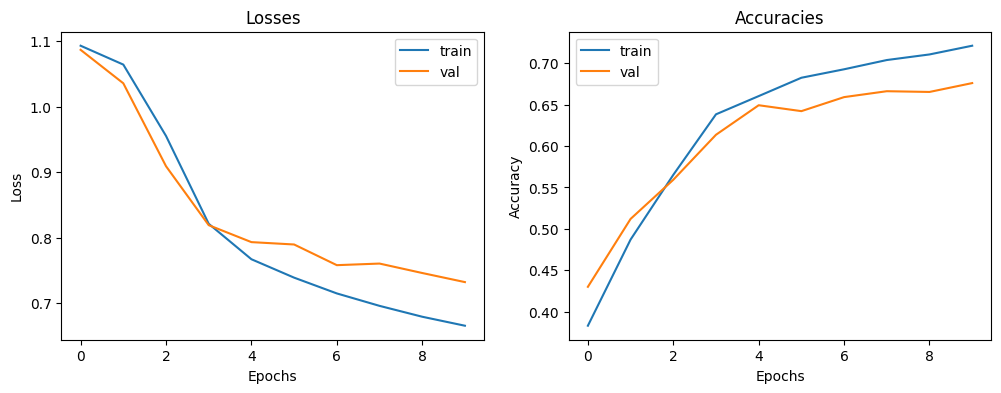

drop_rate = 0.2
Test correct = 451

Test total dataitem = 750

Test Accuracy = 0.6013333201408386

              precision    recall  f1-score   support

    negative       0.66      0.62      0.64       250
     neutral       0.57      0.62      0.59       250
    positive       0.58      0.56      0.57       250

    accuracy                           0.60       750
   macro avg       0.60      0.60      0.60       750
weighted avg       0.60      0.60      0.60       750



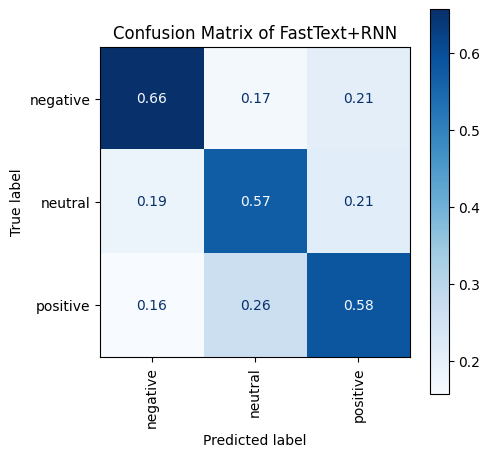

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 234.82it/s]


loss = 1.0911225866898895, val_loss =1.079589933723152, accuracy = 0.4001256227493286, val_accuracy = 0.4532502293586731


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 242.31it/s]


loss = 1.0393068795837461, val_loss =0.9924637641986861, accuracy = 0.48539572954177856, val_accuracy = 0.463935911655426


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 226.36it/s]


loss = 0.9326600348390639, val_loss =0.9025045505440276, accuracy = 0.5447550415992737, val_accuracy = 0.5672306418418884


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 241.69it/s]


loss = 0.8706616045278497, val_loss =0.8527402578808723, accuracy = 0.5972047448158264, val_accuracy = 0.6055209636688232


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 240.60it/s]


loss = 0.8222129804018187, val_loss =0.8292219880423213, accuracy = 0.6322236061096191, val_accuracy = 0.6153161525726318


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 234.25it/s]


loss = 0.7858112368170986, val_loss =0.818201515749873, accuracy = 0.6491833925247192, val_accuracy = 0.6322351098060608


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 226.65it/s]


loss = 0.7532552343577845, val_loss =0.8117019337252713, accuracy = 0.6664572954177856, val_accuracy = 0.6233303546905518


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 233.82it/s]


loss = 0.7347697592692566, val_loss =0.7790341810069217, accuracy = 0.6754083037376404, val_accuracy = 0.6447017192840576


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 240.50it/s]


loss = 0.7114712897216668, val_loss =0.7806514985667216, accuracy = 0.6917399168014526, val_accuracy = 0.6447017192840576


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 241.28it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6939685243052373, val_loss =0.7526935636532486, accuracy = 0.7052449584007263, val_accuracy = 0.6696349382400513


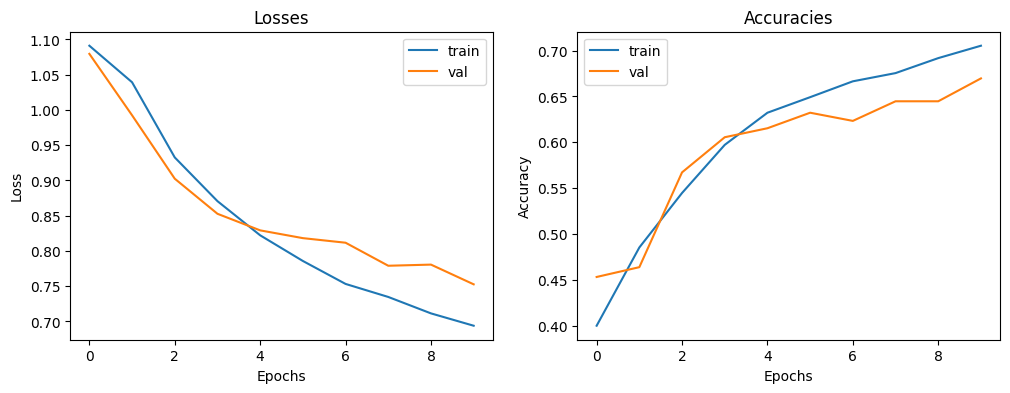

drop_rate = 0.3
Test correct = 454

Test total dataitem = 750

Test Accuracy = 0.6053333282470703

              precision    recall  f1-score   support

    negative       0.62      0.65      0.63       250
     neutral       0.60      0.64      0.62       250
    positive       0.59      0.53      0.56       250

    accuracy                           0.61       750
   macro avg       0.60      0.61      0.60       750
weighted avg       0.60      0.61      0.60       750



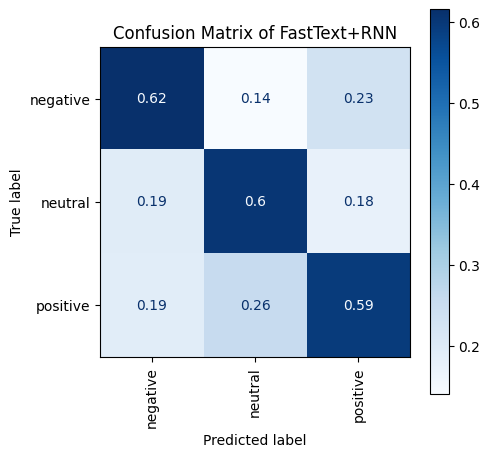

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 228.49it/s]


loss = 1.0938187285792083, val_loss =1.0881794701433845, accuracy = 0.36966079473495483, val_accuracy = 0.42208370566368103


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 213.25it/s]


loss = 1.0755442562140525, val_loss =1.0621914788016251, accuracy = 0.4588567912578583, val_accuracy = 0.47195014357566833


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 171.51it/s]


loss = 1.0048152388143352, val_loss =0.9451816725411586, accuracy = 0.5493090152740479, val_accuracy = 0.5743544101715088


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 180.32it/s]


loss = 0.8635711114521837, val_loss =0.869333201520411, accuracy = 0.6212311387062073, val_accuracy = 0.6135351657867432


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 173.85it/s]


loss = 0.7959525946405483, val_loss =0.8145606016229269, accuracy = 0.6565640568733215, val_accuracy = 0.641139805316925


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 167.72it/s]


loss = 0.7541190344419738, val_loss =0.7866166709583171, accuracy = 0.679648220539093, val_accuracy = 0.6509349942207336


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 166.92it/s]


loss = 0.7321289175868151, val_loss =0.7803732890307733, accuracy = 0.6881281137466431, val_accuracy = 0.658058762550354


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 161.50it/s]


loss = 0.7126341276531457, val_loss =0.7666106751742995, accuracy = 0.6975502371788025, val_accuracy = 0.6616206765174866


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 170.26it/s]


loss = 0.6982878658597474, val_loss =0.7602371932586215, accuracy = 0.7074434757232666, val_accuracy = 0.6714158654212952


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 196.74it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6931015258913976, val_loss =0.778237943973906, accuracy = 0.7086997628211975, val_accuracy = 0.6616206765174866


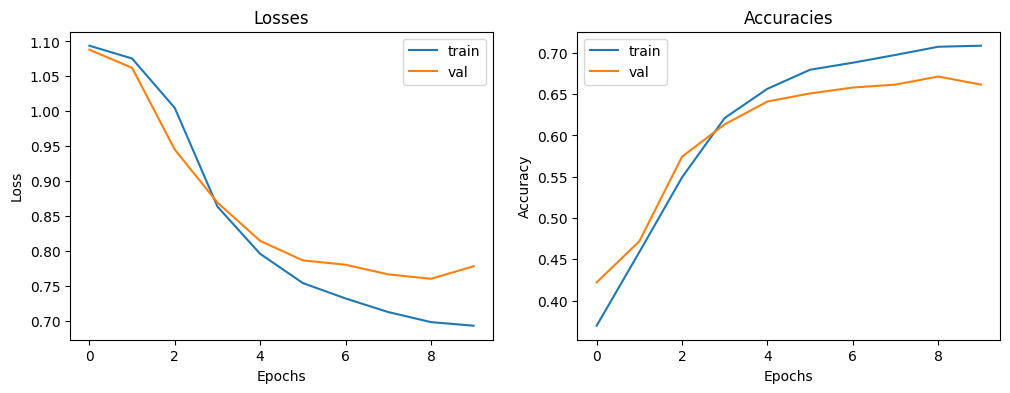

drop_rate = 0.4
Test correct = 442

Test total dataitem = 750

Test Accuracy = 0.5893333554267883

              precision    recall  f1-score   support

    negative       0.73      0.49      0.58       250
     neutral       0.52      0.78      0.63       250
    positive       0.60      0.50      0.54       250

    accuracy                           0.59       750
   macro avg       0.62      0.59      0.58       750
weighted avg       0.62      0.59      0.58       750



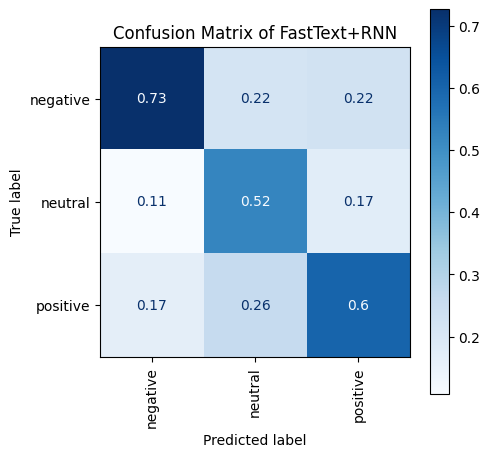

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 246.64it/s]


loss = 1.0942364033591003, val_loss =1.0877974766809198, accuracy = 0.3693467378616333, val_accuracy = 0.4131789803504944


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 225.53it/s]


loss = 1.0751356163527817, val_loss =1.059161724405925, accuracy = 0.43938443064689636, val_accuracy = 0.49243101477622986


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 244.64it/s]


loss = 1.004100397406146, val_loss =0.9431556298981406, accuracy = 0.5301507711410522, val_accuracy = 0.5520926117897034


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 234.80it/s]


loss = 0.8843457875982859, val_loss =0.8443931244310021, accuracy = 0.6000313758850098, val_accuracy = 0.6153161525726318


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 229.08it/s]


loss = 0.8019948253958137, val_loss =0.826639256666189, accuracy = 0.64777010679245, val_accuracy = 0.6224399209022522


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 244.88it/s]


loss = 0.7662703582781251, val_loss =0.7810971713458588, accuracy = 0.674466073513031, val_accuracy = 0.6429207921028137


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 233.67it/s]


loss = 0.740719625269121, val_loss =0.7673241664167672, accuracy = 0.685615599155426, val_accuracy = 0.6464826464653015


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 234.18it/s]


loss = 0.7214889687593677, val_loss =0.7575919052481094, accuracy = 0.6961369514465332, val_accuracy = 0.6589492559432983


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 227.15it/s]


loss = 0.7043584693566664, val_loss =0.7450799922726306, accuracy = 0.7054020166397095, val_accuracy = 0.6598397493362427


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 230.37it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6924293011418194, val_loss =0.7521709033045991, accuracy = 0.7104271054267883, val_accuracy = 0.666963517665863


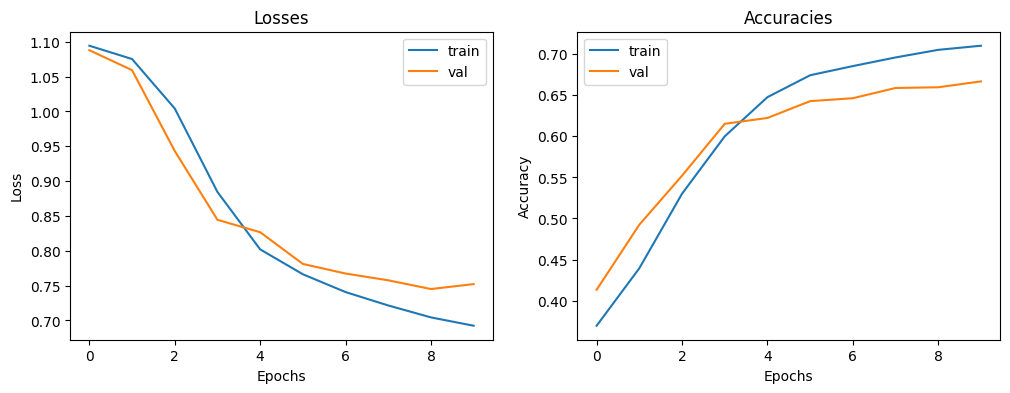

drop_rate = 0.5
Test correct = 465

Test total dataitem = 750

Test Accuracy = 0.6200000047683716

              precision    recall  f1-score   support

    negative       0.65      0.64      0.65       250
     neutral       0.56      0.73      0.63       250
    positive       0.70      0.48      0.57       250

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.62       750
weighted avg       0.63      0.62      0.62       750



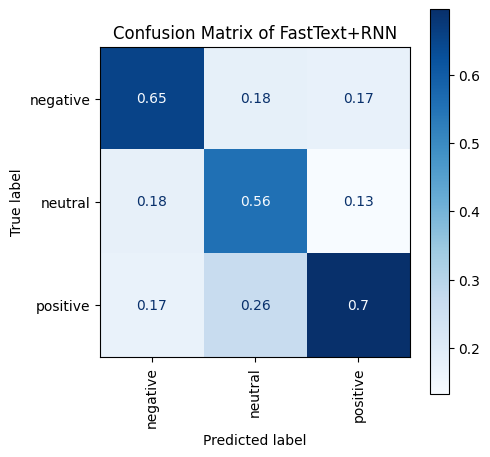

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 228.94it/s]


loss = 1.0963880929816514, val_loss =1.0900337272072358, accuracy = 0.35662686824798584, val_accuracy = 0.3918076753616333


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 236.21it/s]


loss = 1.08042330769822, val_loss =1.0687632032832692, accuracy = 0.425408273935318, val_accuracy = 0.4657168388366699


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 235.84it/s]


loss = 1.030206134947948, val_loss =1.0033337601504866, accuracy = 0.48979270458221436, val_accuracy = 0.48797863721847534


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 224.72it/s]


loss = 0.9341773951856885, val_loss =0.8916494199721556, accuracy = 0.5588881969451904, val_accuracy = 0.5814781785011292


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 237.11it/s]


loss = 0.86295779519598, val_loss =0.8458566659928433, accuracy = 0.6108668446540833, val_accuracy = 0.6179875731468201


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 225.91it/s]


loss = 0.7944721684447722, val_loss =0.8025850881548924, accuracy = 0.6578203439712524, val_accuracy = 0.641139805316925


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 236.26it/s]


loss = 0.7601527385078952, val_loss =0.7720116634929871, accuracy = 0.6721105575561523, val_accuracy = 0.6598397493362427


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 193.09it/s]


loss = 0.7296966511181381, val_loss =0.7745153844558877, accuracy = 0.6944095492362976, val_accuracy = 0.6651825904846191


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 178.81it/s]


loss = 0.7181903915375005, val_loss =0.7517103231257005, accuracy = 0.6966080069541931, val_accuracy = 0.6856634020805359


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 182.21it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.702452446869429, val_loss =0.7487881683473778, accuracy = 0.7074434757232666, val_accuracy = 0.6812110543251038


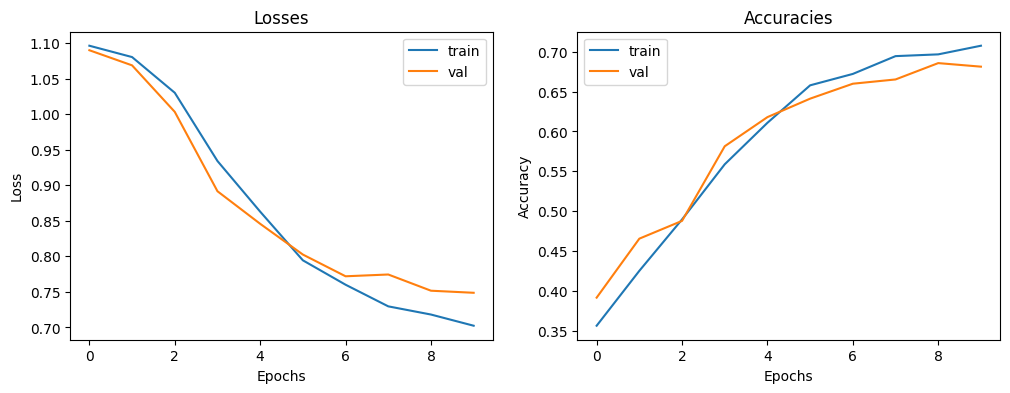

drop_rate = 0.6
Test correct = 456

Test total dataitem = 750

Test Accuracy = 0.6079999804496765

              precision    recall  f1-score   support

    negative       0.67      0.62      0.64       250
     neutral       0.62      0.60      0.61       250
    positive       0.55      0.60      0.57       250

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



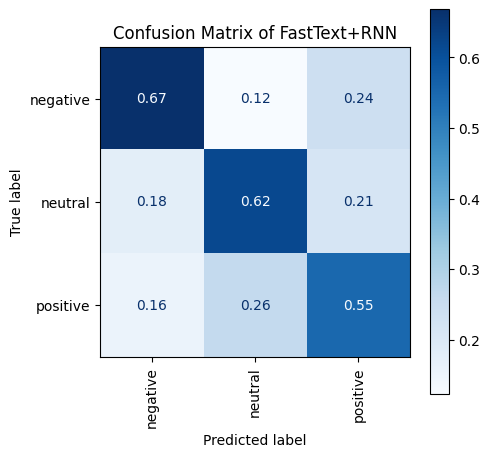

In [ ]:
bidirectional=True
num_layers=2
hidden_size1=64
hidden_size2=128
drop_rates=[0.1,0.2,0.3,0.4,0.5,0.6]
for drop_rate in drop_rates:
  model=RNN(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,drop_rate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+RNN'
  print(f'drop_rate = {drop_rate}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 81.49it/s]


loss = 1.0929212668538093, val_loss =1.0860342583160787, accuracy = 0.3814384341239929, val_accuracy = 0.4336598515510559


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 141.01it/s]


loss = 1.0709213561285287, val_loss =1.055512269914505, accuracy = 0.4761306345462799, val_accuracy = 0.464826375246048


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 106.89it/s]


loss = 0.9959113816241734, val_loss =0.9496093887891176, accuracy = 0.539101779460907, val_accuracy = 0.5218165516853333


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 125.31it/s]


loss = 0.8596189373941161, val_loss =0.8512221000366105, accuracy = 0.6147927045822144, val_accuracy = 0.6081923842430115


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 131.48it/s]


loss = 0.7859239629597868, val_loss =0.7946793125162552, accuracy = 0.6537374258041382, val_accuracy = 0.658058762550354


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 138.99it/s]


loss = 0.7498443693452281, val_loss =0.7862433410004809, accuracy = 0.6741520166397095, val_accuracy = 0.6527159810066223


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 161.90it/s]


loss = 0.7261369081214071, val_loss =0.7729460404269279, accuracy = 0.6853014826774597, val_accuracy = 0.6634016036987305


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 244.76it/s]


loss = 0.703631566670374, val_loss =0.7517567345919179, accuracy = 0.7014760971069336, val_accuracy = 0.6803205609321594


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 241.77it/s]


loss = 0.6867288405695581, val_loss =0.7482973818378504, accuracy = 0.7138819098472595, val_accuracy = 0.6740872859954834


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 229.10it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6751054216604098, val_loss =0.7489276947404188, accuracy = 0.7217336893081665, val_accuracy = 0.677649199962616


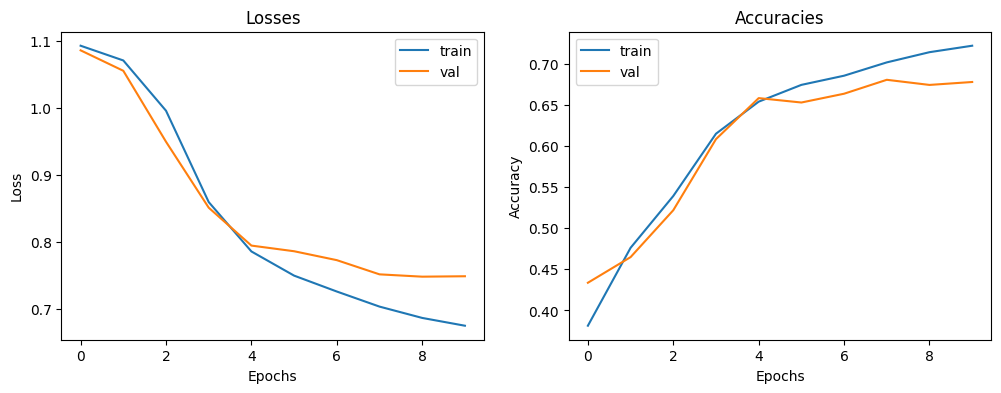

freeze_embedding = True
Test correct = 463

Test total dataitem = 750

Test Accuracy = 0.6173333525657654

              precision    recall  f1-score   support

    negative       0.62      0.68      0.65       250
     neutral       0.57      0.69      0.63       250
    positive       0.70      0.48      0.57       250

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.61       750
weighted avg       0.63      0.62      0.61       750



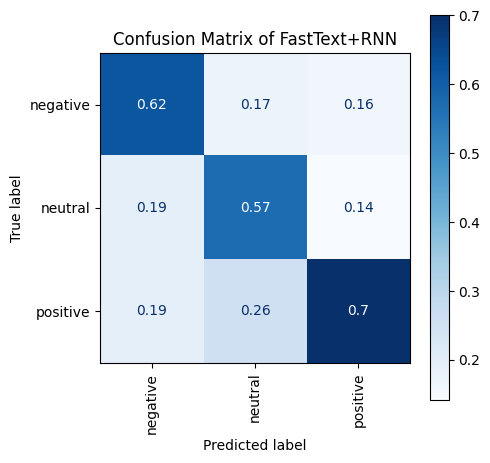

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 181.21it/s]


loss = 1.0878789820242674, val_loss =1.0729796322993934, accuracy = 0.4119032621383667, val_accuracy = 0.4594835340976715


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 183.73it/s]


loss = 0.9887944067502394, val_loss =0.9251291853989224, accuracy = 0.5577889680862427, val_accuracy = 0.5235975384712219


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 186.68it/s]


loss = 0.7645153448352358, val_loss =0.7434550176965007, accuracy = 0.6686557531356812, val_accuracy = 0.6714158654212952


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 176.55it/s]


loss = 0.6122928767440317, val_loss =0.6620383045658753, accuracy = 0.7396356463432312, val_accuracy = 0.7105966210365295


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 180.02it/s]


loss = 0.5241597707485198, val_loss =0.6388586980639264, accuracy = 0.7836055159568787, val_accuracy = 0.7230632305145264


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 156.21it/s]


loss = 0.4480372617677858, val_loss =0.6376178169991434, accuracy = 0.8172110319137573, val_accuracy = 0.7310774922370911


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 151.85it/s]


loss = 0.3999298129951239, val_loss =0.6245452627779973, accuracy = 0.8421796560287476, val_accuracy = 0.741763174533844


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 147.69it/s]


loss = 0.36036478288539003, val_loss =0.6297640093130284, accuracy = 0.8578831553459167, val_accuracy = 0.741763174533844


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 141.37it/s]


loss = 0.3266809651439962, val_loss =0.6649784157923427, accuracy = 0.8739007711410522, val_accuracy = 0.7355298399925232


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 150.12it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.3029767639996953, val_loss =0.694569308541081, accuracy = 0.8823806643486023, val_accuracy = 0.7301869988441467


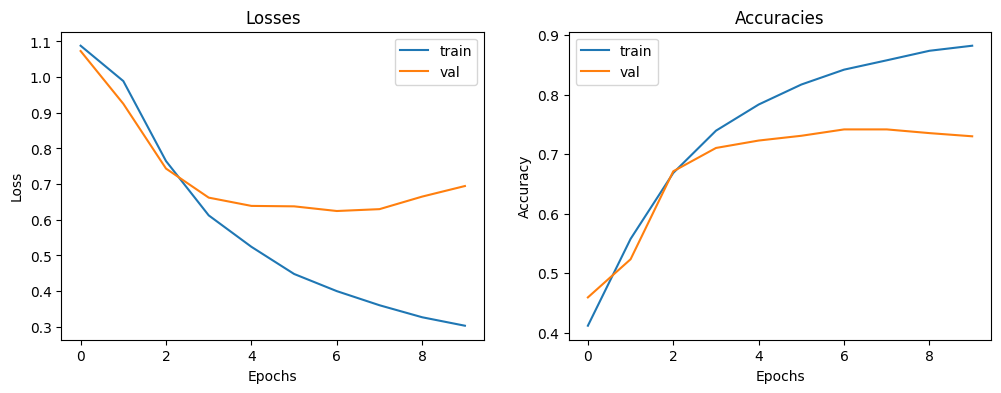

freeze_embedding = False
Test correct = 486

Test total dataitem = 750

Test Accuracy = 0.6480000019073486

              precision    recall  f1-score   support

    negative       0.69      0.62      0.66       250
     neutral       0.61      0.68      0.65       250
    positive       0.65      0.64      0.64       250

    accuracy                           0.65       750
   macro avg       0.65      0.65      0.65       750
weighted avg       0.65      0.65      0.65       750



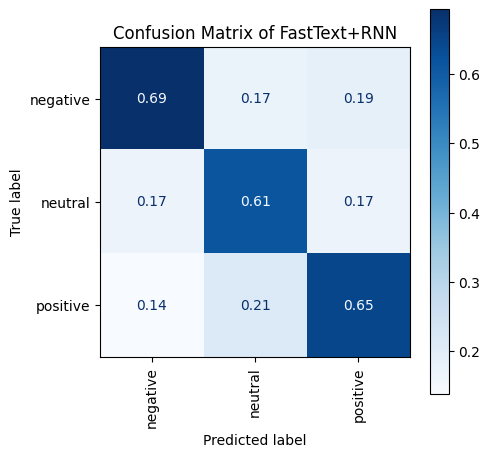

In [ ]:
bidirectional=True
num_layers=2
hidden_size1=64
hidden_size2=128
droprate=0.1
freeze_options=[True,False]
for freeze in freeze_options:
  model=RNN(fasttext_weights,hidden_size1,hidden_size2,freeze,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+RNN'
  print(f'freeze_embedding = {freeze}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 180.19it/s]


loss = 3.3828220589906977, val_loss =1.101414410849028, accuracy = 0.34924623370170593, val_accuracy = 0.35084596276283264


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 183.78it/s]


loss = 1.084705440129619, val_loss =1.1024661281975798, accuracy = 0.370760053396225, val_accuracy = 0.3339269757270813


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 182.34it/s]


loss = 1.0994367147912272, val_loss =1.1075572222855594, accuracy = 0.33605527877807617, val_accuracy = 0.3357079327106476


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 189.52it/s]


loss = 1.0951081657077884, val_loss =1.0900383542343561, accuracy = 0.3632223606109619, val_accuracy = 0.36331257224082947


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 182.47it/s]


loss = 1.1145050354829267, val_loss =1.0995658653509242, accuracy = 0.36997488141059875, val_accuracy = 0.3677649199962616


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 188.19it/s]


loss = 1.1190696290452615, val_loss =1.0937493073406614, accuracy = 0.356783926486969, val_accuracy = 0.34105077385902405


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 177.80it/s]


loss = 1.1063219310669228, val_loss =1.0894339825359305, accuracy = 0.34013819694519043, val_accuracy = 0.3517364263534546


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 184.56it/s]


loss = 1.1005637282889802, val_loss =1.106811526701564, accuracy = 0.3393530249595642, val_accuracy = 0.3205699026584625


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 174.63it/s]


loss = 1.097778807700961, val_loss =1.1002760939994856, accuracy = 0.34170854091644287, val_accuracy = 0.32324132323265076


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 155.65it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 1.0972165273770225, val_loss =1.1694140062194378, accuracy = 0.3528580367565155, val_accuracy = 0.35529831051826477


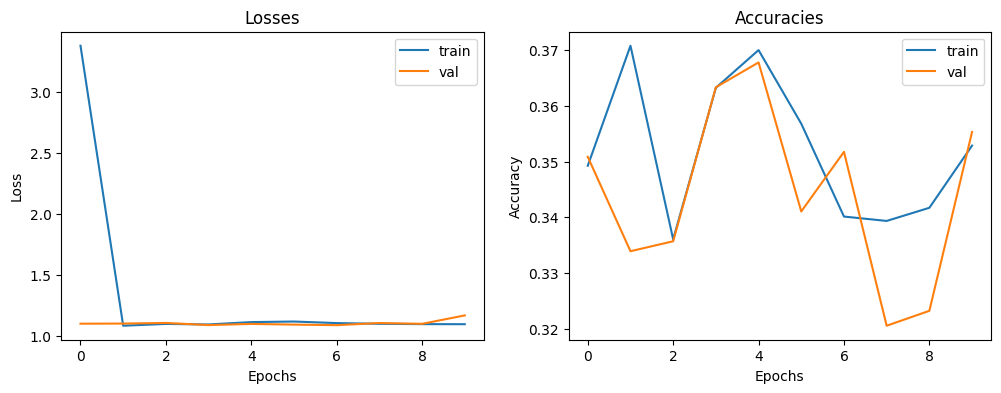

learning_rate = 0.1
Test correct = 261

Test total dataitem = 750

Test Accuracy = 0.3479999899864197

              precision    recall  f1-score   support

    negative       0.67      0.07      0.13       250
     neutral       0.00      0.00      0.00       250
    positive       0.34      0.97      0.50       250

    accuracy                           0.35       750
   macro avg       0.33      0.35      0.21       750
weighted avg       0.33      0.35      0.21       750



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


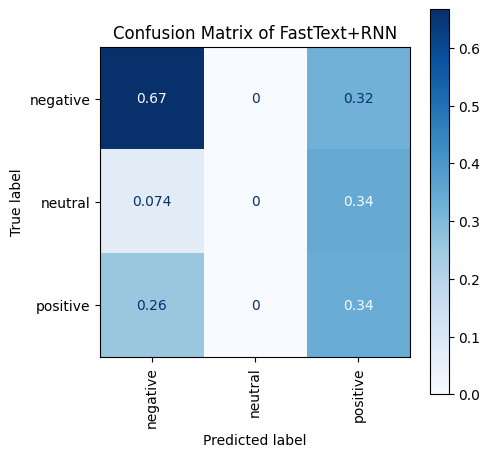

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 152.39it/s]


loss = 0.9222431974005303, val_loss =0.818116188003143, accuracy = 0.5590451955795288, val_accuracy = 0.6322351098060608


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 146.73it/s]


loss = 0.6904322422871519, val_loss =0.7872653045738208, accuracy = 0.7134107947349548, val_accuracy = 0.651825487613678


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 143.61it/s]


loss = 0.5845655319641969, val_loss =0.8699858584406597, accuracy = 0.7561243772506714, val_accuracy = 0.6553874015808105


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 190.23it/s]


loss = 0.5083920871729325, val_loss =0.8714629640382536, accuracy = 0.7982097864151001, val_accuracy = 0.6767587065696716


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 182.20it/s]


loss = 0.4509177804381158, val_loss =0.844662807372417, accuracy = 0.8211369514465332, val_accuracy = 0.6847729682922363


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 180.98it/s]


loss = 0.39757985159398024, val_loss =0.8761383602586997, accuracy = 0.8421796560287476, val_accuracy = 0.6910062432289124


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 186.48it/s]


loss = 0.37883424030282037, val_loss =0.9458982246928963, accuracy = 0.8520728349685669, val_accuracy = 0.6981300115585327


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 179.86it/s]


loss = 0.3558110539308978, val_loss =0.9496692948053518, accuracy = 0.8581972122192383, val_accuracy = 0.6927871704101562


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 185.53it/s]


loss = 0.33810434369429987, val_loss =1.0247234998666732, accuracy = 0.8647927045822144, val_accuracy = 0.7105966210365295


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 179.90it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.34991145878306384, val_loss =0.9326774950938612, accuracy = 0.8583542704582214, val_accuracy = 0.7025823593139648


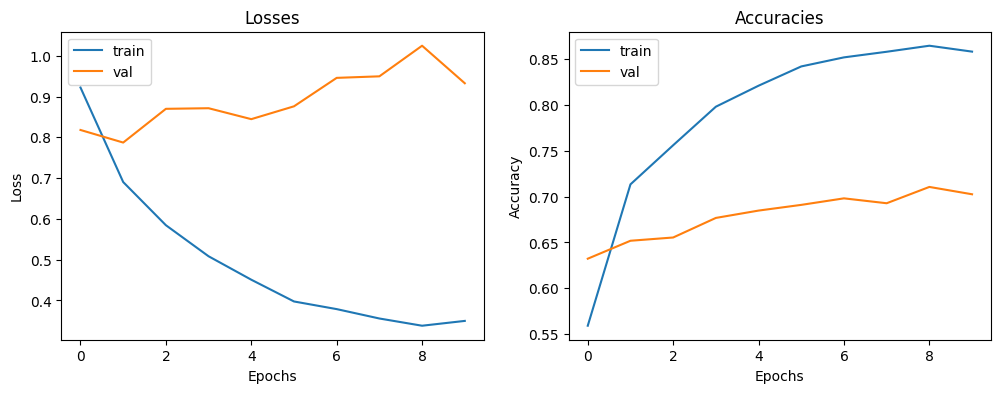

learning_rate = 0.01
Test correct = 432

Test total dataitem = 750

Test Accuracy = 0.5759999752044678

              precision    recall  f1-score   support

    negative       0.63      0.56      0.59       250
     neutral       0.51      0.67      0.58       250
    positive       0.62      0.49      0.55       250

    accuracy                           0.58       750
   macro avg       0.59      0.58      0.58       750
weighted avg       0.59      0.58      0.58       750



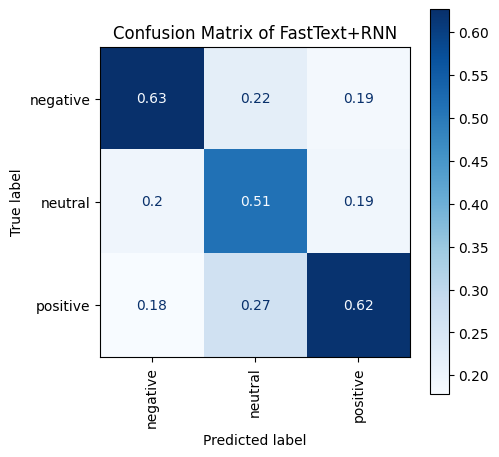

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 181.85it/s]


loss = 0.8745616600633366, val_loss =0.6920119003382593, accuracy = 0.5833856463432312, val_accuracy = 0.7052537798881531


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 176.78it/s]


loss = 0.5328688067475378, val_loss =0.6283197950137759, accuracy = 0.7768530249595642, val_accuracy = 0.7399821877479553


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 185.28it/s]


loss = 0.3703687113079059, val_loss =0.6323742459513177, accuracy = 0.8517587780952454, val_accuracy = 0.7462155222892761


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 181.01it/s]


loss = 0.267643881313081, val_loss =0.7416175534522715, accuracy = 0.8957286477088928, val_accuracy = 0.7337489128112793


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 183.07it/s]


loss = 0.20763882136104556, val_loss =0.8336255180765991, accuracy = 0.9202260971069336, val_accuracy = 0.7141585350036621


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 186.44it/s]


loss = 0.15782331029835248, val_loss =0.9218962426797037, accuracy = 0.9423680901527405, val_accuracy = 0.7070347666740417


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 183.80it/s]


loss = 0.14273685299654867, val_loss =1.0948013394164628, accuracy = 0.9447236061096191, val_accuracy = 0.7275155782699585


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 184.31it/s]


loss = 0.12834528272545756, val_loss =1.2020802134331054, accuracy = 0.9495916962623596, val_accuracy = 0.7088156938552856


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 180.53it/s]


loss = 0.10542242114395955, val_loss =1.179294350960899, accuracy = 0.9585427045822144, val_accuracy = 0.7292965650558472


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 157.19it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.08208769212846491, val_loss =1.2660476804444007, accuracy = 0.965452253818512, val_accuracy = 0.7061442732810974


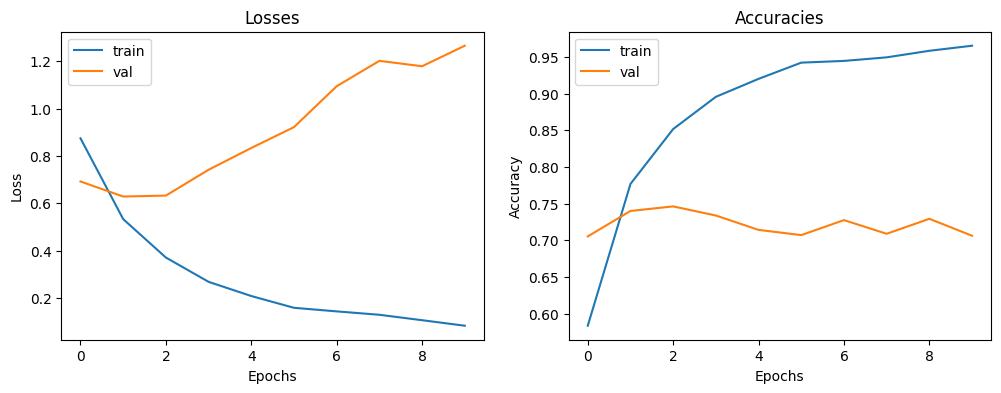

learning_rate = 0.001
Test correct = 445

Test total dataitem = 750

Test Accuracy = 0.5933333039283752

              precision    recall  f1-score   support

    negative       0.77      0.42      0.55       250
     neutral       0.53      0.75      0.62       250
    positive       0.58      0.61      0.60       250

    accuracy                           0.59       750
   macro avg       0.63      0.59      0.59       750
weighted avg       0.63      0.59      0.59       750



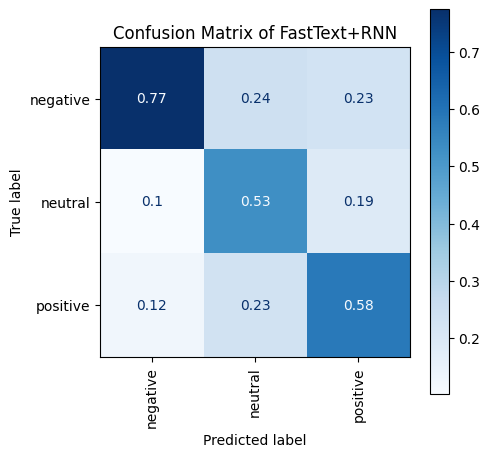

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 153.32it/s]


loss = 0.8333955112972763, val_loss =0.6562076276603399, accuracy = 0.595634400844574, val_accuracy = 0.7079252004623413


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 143.64it/s]


loss = 0.5151175375603225, val_loss =0.6814295919796721, accuracy = 0.7861180901527405, val_accuracy = 0.7132680416107178


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 141.01it/s]


loss = 0.39309278473890574, val_loss =0.7733338991271069, accuracy = 0.8467336297035217, val_accuracy = 0.7043633460998535


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 148.29it/s]


loss = 0.30585992619648833, val_loss =0.833280421442732, accuracy = 0.882066547870636, val_accuracy = 0.70970618724823


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 181.83it/s]


loss = 0.2224161032715798, val_loss =0.8851602403647834, accuracy = 0.9153580069541931, val_accuracy = 0.6892253160476685


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 173.05it/s]


loss = 0.16858905894338214, val_loss =1.0867258104420279, accuracy = 0.934202253818512, val_accuracy = 0.7052537798881531


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 184.83it/s]


loss = 0.14644227841025284, val_loss =1.2671705398319446, accuracy = 0.9425250887870789, val_accuracy = 0.6821015477180481


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 183.83it/s]


loss = 0.13192889932136898, val_loss =1.2501991681778284, accuracy = 0.9500628113746643, val_accuracy = 0.7025823593139648


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 181.76it/s]


loss = 0.10861830285170755, val_loss =1.318230121946471, accuracy = 0.9543027281761169, val_accuracy = 0.7088156938552856


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 179.50it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.10148342307612734, val_loss =1.4856814150926878, accuracy = 0.9601130485534668, val_accuracy = 0.700801432132721


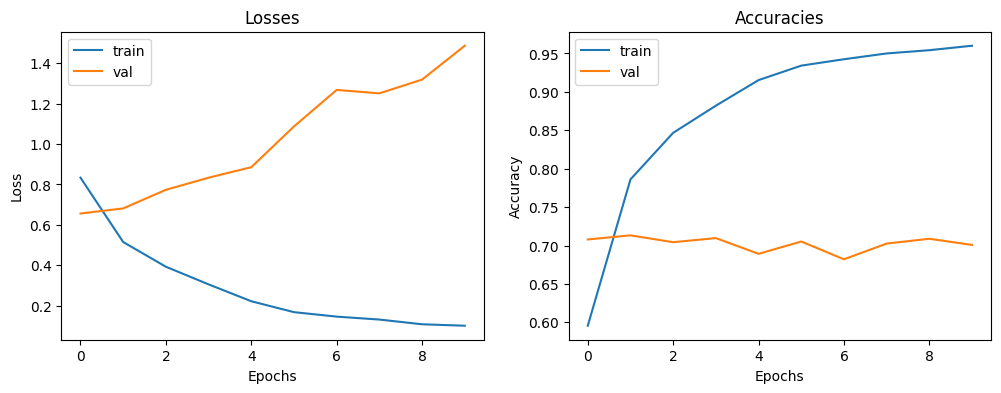

learning_rate = 0.002
Test correct = 447

Test total dataitem = 750

Test Accuracy = 0.5960000157356262

              precision    recall  f1-score   support

    negative       0.72      0.52      0.61       250
     neutral       0.55      0.68      0.61       250
    positive       0.56      0.59      0.57       250

    accuracy                           0.60       750
   macro avg       0.61      0.60      0.60       750
weighted avg       0.61      0.60      0.60       750



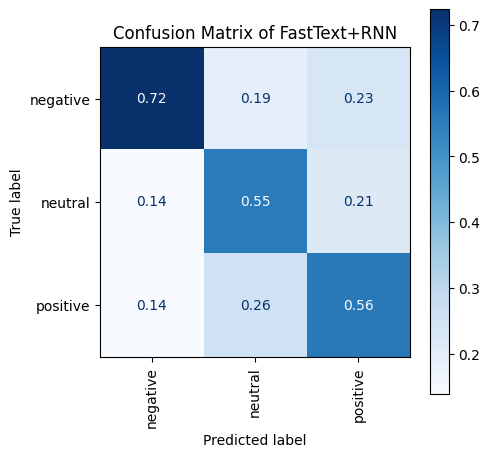

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 178.90it/s]


loss = 0.8379960395643138, val_loss =0.6844916585554731, accuracy = 0.5986180901527405, val_accuracy = 0.6999109983444214


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 181.41it/s]


loss = 0.5390426340291015, val_loss =0.6652209596826102, accuracy = 0.778580367565155, val_accuracy = 0.7123775482177734


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 182.92it/s]


loss = 0.4181066538597793, val_loss =0.7825412827868359, accuracy = 0.835898220539093, val_accuracy = 0.70970618724823


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 181.54it/s]


loss = 0.2809655209430187, val_loss =0.8314896274139294, accuracy = 0.8867776393890381, val_accuracy = 0.7052537798881531


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 181.05it/s]


loss = 0.2168690805479585, val_loss =0.9932138458604308, accuracy = 0.9150439500808716, val_accuracy = 0.6945681571960449


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 185.84it/s]


loss = 0.15013259595356782, val_loss =1.0438184359443738, accuracy = 0.9370288848876953, val_accuracy = 0.6936776638031006


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 178.48it/s]


loss = 0.13832802284508758, val_loss =1.2485941842693564, accuracy = 0.9436243772506714, val_accuracy = 0.666963517665863


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 186.42it/s]


loss = 0.13576303947923513, val_loss =1.3376689945259501, accuracy = 0.9464510083198547, val_accuracy = 0.7016919255256653


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 180.65it/s]


loss = 0.1183157784963227, val_loss =1.5413775022913327, accuracy = 0.9514760971069336, val_accuracy = 0.6740872859954834


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 180.49it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.10264705457785465, val_loss =1.5711790936732717, accuracy = 0.9571293592453003, val_accuracy = 0.6829919815063477


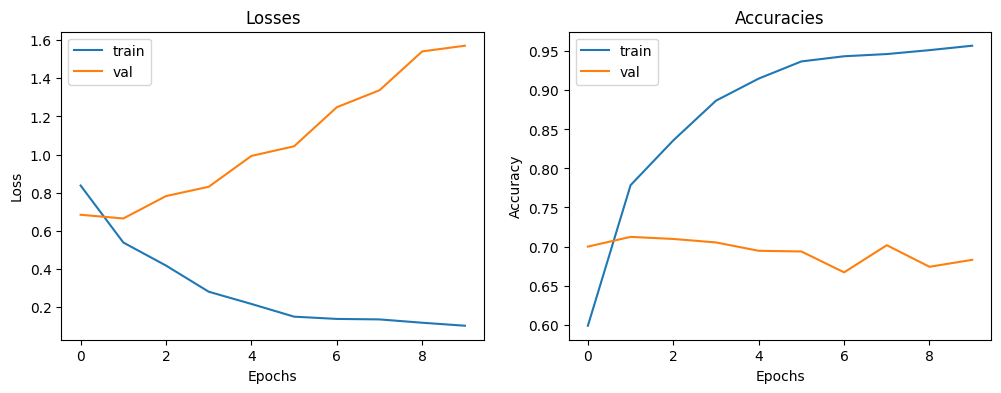

learning_rate = 0.003
Test correct = 425

Test total dataitem = 750

Test Accuracy = 0.5666666626930237

              precision    recall  f1-score   support

    negative       0.70      0.44      0.54       250
     neutral       0.52      0.63      0.57       250
    positive       0.54      0.63      0.58       250

    accuracy                           0.57       750
   macro avg       0.59      0.57      0.56       750
weighted avg       0.59      0.57      0.56       750



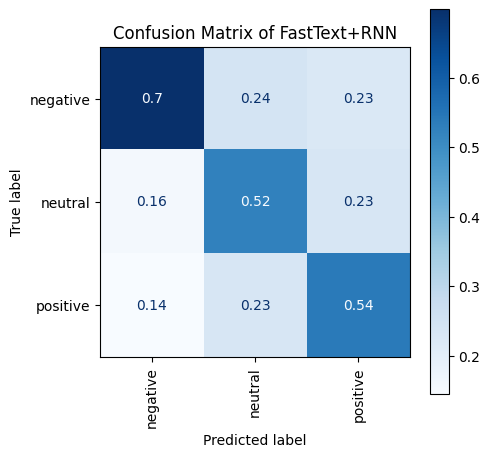

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 150.47it/s]


loss = 1.0883606716711074, val_loss =1.0727870494082925, accuracy = 0.4145728647708893, val_accuracy = 0.4657168388366699


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 156.72it/s]


loss = 0.9897022240236402, val_loss =0.8919560622486714, accuracy = 0.541614294052124, val_accuracy = 0.561887800693512


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 145.09it/s]


loss = 0.7811083471559687, val_loss =0.7592165588486259, accuracy = 0.6472989916801453, val_accuracy = 0.651825487613678


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 147.46it/s]


loss = 0.6365181313619541, val_loss =0.6581913515268031, accuracy = 0.7281721234321594, val_accuracy = 0.7212823033332825


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 151.77it/s]


loss = 0.5235220034551458, val_loss =0.6237895037950707, accuracy = 0.7754396796226501, val_accuracy = 0.7301869988441467


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 178.58it/s]


loss = 0.4542776006375061, val_loss =0.6180107703045198, accuracy = 0.8150125741958618, val_accuracy = 0.7382012605667114


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 186.14it/s]


loss = 0.40205279846007214, val_loss =0.6201041811680365, accuracy = 0.838567852973938, val_accuracy = 0.7426536083221436


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 178.71it/s]


loss = 0.35508578148381276, val_loss =0.6279926427637047, accuracy = 0.8561557531356812, val_accuracy = 0.7435441017150879


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 183.62it/s]


loss = 0.31956842696894455, val_loss =0.6601324580573888, accuracy = 0.8721733689308167, val_accuracy = 0.7488869428634644


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 181.28it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.2973625423585645, val_loss =0.676191775034501, accuracy = 0.8823806643486023, val_accuracy = 0.7488869428634644


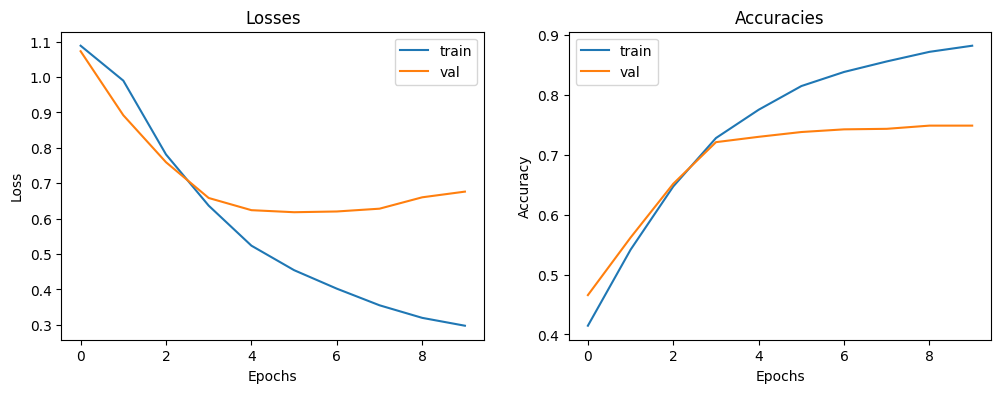

learning_rate = 0.0001
Test correct = 465

Test total dataitem = 750

Test Accuracy = 0.6200000047683716

              precision    recall  f1-score   support

    negative       0.73      0.54      0.62       250
     neutral       0.61      0.60      0.60       250
    positive       0.57      0.72      0.63       250

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.62       750
weighted avg       0.63      0.62      0.62       750



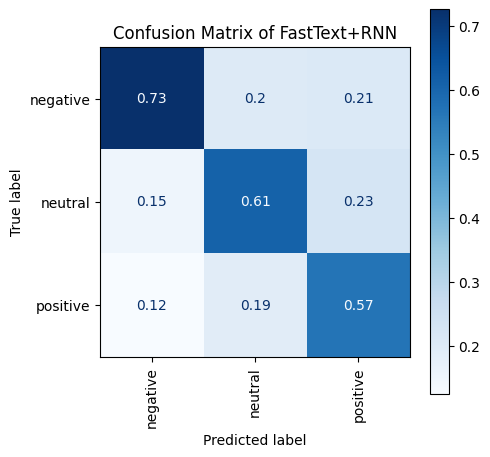

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 183.94it/s]


loss = 1.0591775606619194, val_loss =0.9403688780327756, accuracy = 0.45901381969451904, val_accuracy = 0.5841495990753174


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 176.78it/s]


loss = 0.7578827044466743, val_loss =0.6816871474605581, accuracy = 0.6683416962623596, val_accuracy = 0.6981300115585327


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 185.20it/s]


loss = 0.5382103685395486, val_loss =0.6409861234149301, accuracy = 0.7748115658760071, val_accuracy = 0.7301869988441467


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 177.49it/s]


loss = 0.4327946177189551, val_loss =0.6395202006010622, accuracy = 0.8297738432884216, val_accuracy = 0.7266251444816589


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 180.21it/s]


loss = 0.3649020055249184, val_loss =0.6430817444123051, accuracy = 0.8575690984725952, val_accuracy = 0.7319679856300354


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 179.83it/s]


loss = 0.31278857253809744, val_loss =0.6724208621730221, accuracy = 0.8817524909973145, val_accuracy = 0.7319679856300354


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 176.14it/s]


loss = 0.28148788180194173, val_loss =0.7225170807745781, accuracy = 0.893216073513031, val_accuracy = 0.7319679856300354


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 183.85it/s]


loss = 0.25881893303060705, val_loss =0.7409785480331109, accuracy = 0.9027951955795288, val_accuracy = 0.7382012605667114


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 177.42it/s]


loss = 0.22182880635014157, val_loss =0.8240266037431181, accuracy = 0.9181846380233765, val_accuracy = 0.7284060716629028


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 180.80it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.20055476105211675, val_loss =0.845200809980843, accuracy = 0.9272927045822144, val_accuracy = 0.7203918099403381


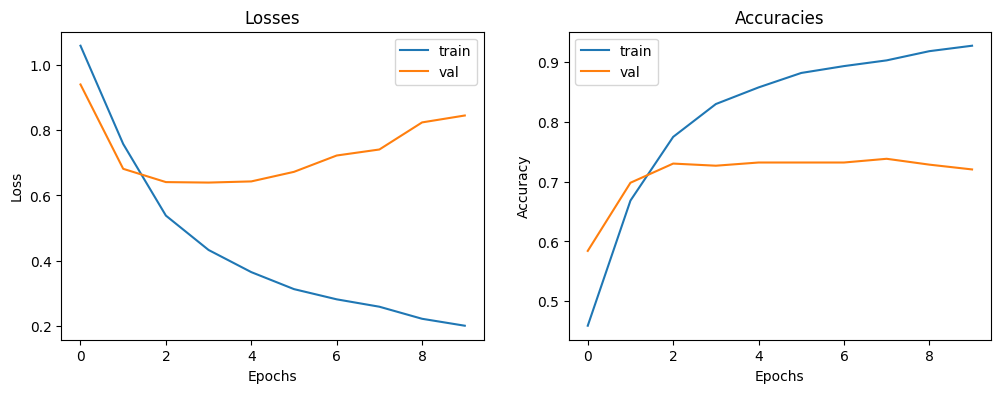

learning_rate = 0.0002
Test correct = 467

Test total dataitem = 750

Test Accuracy = 0.6226666569709778

              precision    recall  f1-score   support

    negative       0.81      0.46      0.59       250
     neutral       0.61      0.67      0.64       250
    positive       0.55      0.73      0.63       250

    accuracy                           0.62       750
   macro avg       0.66      0.62      0.62       750
weighted avg       0.66      0.62      0.62       750



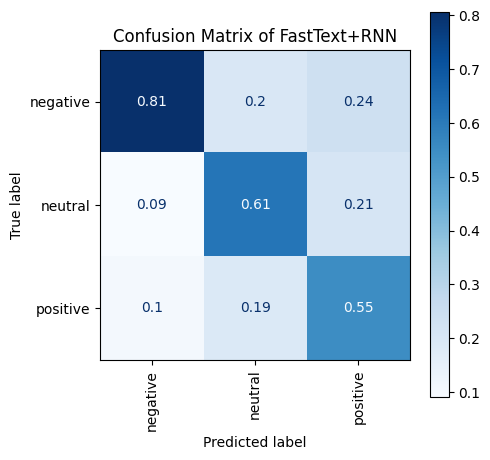

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 154.90it/s]


loss = 1.029134566541761, val_loss =0.8507095329341523, accuracy = 0.49544596672058105, val_accuracy = 0.619768500328064


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 151.44it/s]


loss = 0.6524277778924443, val_loss =0.6406214365489884, accuracy = 0.7259736061096191, val_accuracy = 0.732858419418335


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 148.06it/s]


loss = 0.4630016953061931, val_loss =0.6470356292274305, accuracy = 0.8148555159568787, val_accuracy = 0.7382012605667114


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 147.57it/s]


loss = 0.36777567548767365, val_loss =0.6271452406829624, accuracy = 0.853486180305481, val_accuracy = 0.7373107671737671


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 145.73it/s]


loss = 0.30976095841454254, val_loss =0.6702786905279438, accuracy = 0.8831658363342285, val_accuracy = 0.7444345951080322


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 141.42it/s]


loss = 0.25013600951058834, val_loss =0.7145275822397302, accuracy = 0.9056218266487122, val_accuracy = 0.7426536083221436


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 174.79it/s]


loss = 0.2075954011114132, val_loss =0.7825898996432883, accuracy = 0.9230527281761169, val_accuracy = 0.7453250288963318


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 179.03it/s]


loss = 0.17078444703448845, val_loss =0.8656015044737759, accuracy = 0.942054033279419, val_accuracy = 0.7239537239074707


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 179.28it/s]


loss = 0.13383604126916582, val_loss =0.9802831966178602, accuracy = 0.9510050415992737, val_accuracy = 0.7248441576957703


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 181.19it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.11707945858910335, val_loss =1.0575871798730225, accuracy = 0.9583856463432312, val_accuracy = 0.7239537239074707


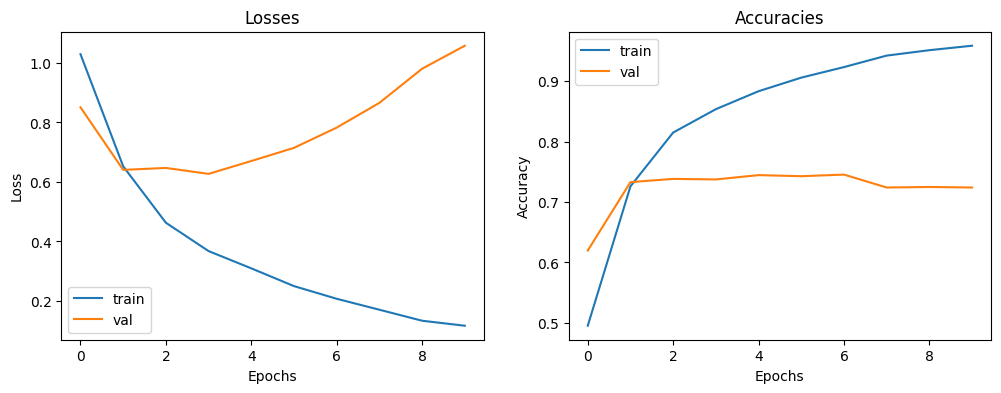

learning_rate = 0.0003
Test correct = 448

Test total dataitem = 750

Test Accuracy = 0.5973333120346069

              precision    recall  f1-score   support

    negative       0.75      0.46      0.57       250
     neutral       0.56      0.70      0.62       250
    positive       0.56      0.63      0.59       250

    accuracy                           0.60       750
   macro avg       0.62      0.60      0.59       750
weighted avg       0.62      0.60      0.59       750



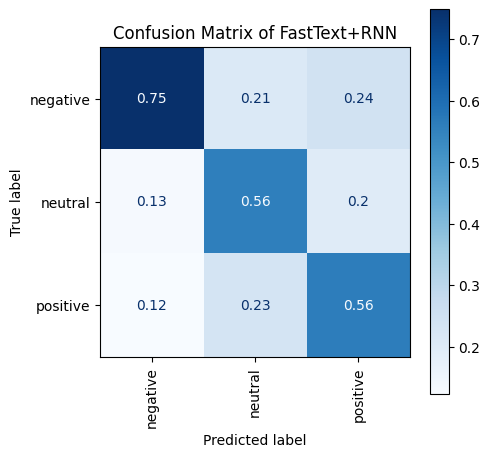

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 175.92it/s]


loss = 1.0988796439860016, val_loss =1.0989013792739974, accuracy = 0.3376256227493286, val_accuracy = 0.3401602804660797


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 182.24it/s]


loss = 1.0971526731085033, val_loss =1.0971943399514117, accuracy = 0.35835427045822144, val_accuracy = 0.35886019468307495


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 177.44it/s]


loss = 1.0950587041210382, val_loss =1.0953298383229781, accuracy = 0.3831658363342285, val_accuracy = 0.39091718196868896


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 185.05it/s]


loss = 1.0927027271408587, val_loss =1.0934753069639322, accuracy = 0.4170854091644287, val_accuracy = 0.4078361690044403


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 176.52it/s]


loss = 1.0898836327437311, val_loss =1.0912596942472552, accuracy = 0.4439384341239929, val_accuracy = 0.42297419905662537


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 181.22it/s]


loss = 1.087210685322061, val_loss =1.0888580421636265, accuracy = 0.4657663404941559, val_accuracy = 0.4416741132736206


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 174.80it/s]


loss = 1.0841976448241621, val_loss =1.0860928385577622, accuracy = 0.47848618030548096, val_accuracy = 0.4532502293586731


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 175.29it/s]


loss = 1.0795894071180374, val_loss =1.0827445621513538, accuracy = 0.4929334223270416, val_accuracy = 0.47016918659210205


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 178.59it/s]


loss = 1.0754594135284423, val_loss =1.0786485109980852, accuracy = 0.5087939500808716, val_accuracy = 0.48174533247947693


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 174.57it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 1.070320777380839, val_loss =1.0736503368554016, accuracy = 0.5202575325965881, val_accuracy = 0.4870881736278534


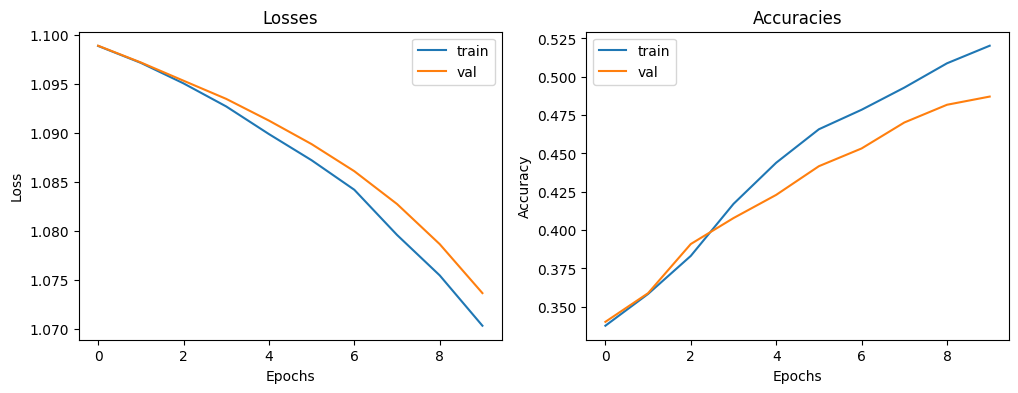

learning_rate = 1e-05
Test correct = 361

Test total dataitem = 750

Test Accuracy = 0.48133331537246704

              precision    recall  f1-score   support

    negative       0.53      0.42      0.47       250
     neutral       0.46      0.55      0.50       250
    positive       0.47      0.48      0.47       250

    accuracy                           0.48       750
   macro avg       0.49      0.48      0.48       750
weighted avg       0.49      0.48      0.48       750



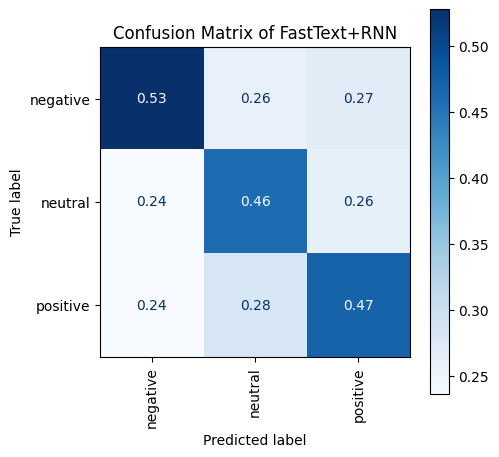

In [ ]:
bidirectional=True
num_layers=2
hidden_size1=64
hidden_size2=128
droprate=0.1
freeze_embedding=False
learning_rates=[0.1,0.01,0.001,0.002,0.003,0.0001,0.0002,0.0003,0.00001]
for learning_rate1 in learning_rates:
  model=RNN(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate1)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+RNN'
  print(f'learning_rate = {learning_rate1}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:02<00:00, 43.78it/s]


loss = 1.0878184942062945, val_loss =1.0736715048655041, accuracy = 0.4161432087421417, val_accuracy = 0.47996440529823303


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 93.14it/s]


loss = 0.9988014741241932, val_loss =0.9301201227509106, accuracy = 0.5444409251213074, val_accuracy = 0.544968843460083


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 144.62it/s]


loss = 0.8030301173322368, val_loss =0.7740617528912567, accuracy = 0.6314384341239929, val_accuracy = 0.6491540670394897


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 155.18it/s]


loss = 0.6584888017772755, val_loss =0.6859865325804715, accuracy = 0.7192211151123047, val_accuracy = 0.6954585909843445


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 183.52it/s]


loss = 0.5399873572914657, val_loss =0.6716699002534456, accuracy = 0.777952253818512, val_accuracy = 0.690115749835968


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 186.88it/s]


loss = 0.4581644832941674, val_loss =0.6316290607319157, accuracy = 0.8120288848876953, val_accuracy = 0.7310774922370911


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 187.69it/s]


loss = 0.4086517782160263, val_loss =0.6252747582724335, accuracy = 0.8330715894699097, val_accuracy = 0.7462155222892761


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 182.89it/s]


loss = 0.36492625779968874, val_loss =0.6323404466405168, accuracy = 0.8570979833602905, val_accuracy = 0.7390917539596558


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 186.98it/s]


loss = 0.3235313340481207, val_loss =0.6446074824771203, accuracy = 0.875, val_accuracy = 0.7364203333854675


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 183.61it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.2981629305597744, val_loss =0.6703043437200471, accuracy = 0.8867776393890381, val_accuracy = 0.7471059560775757


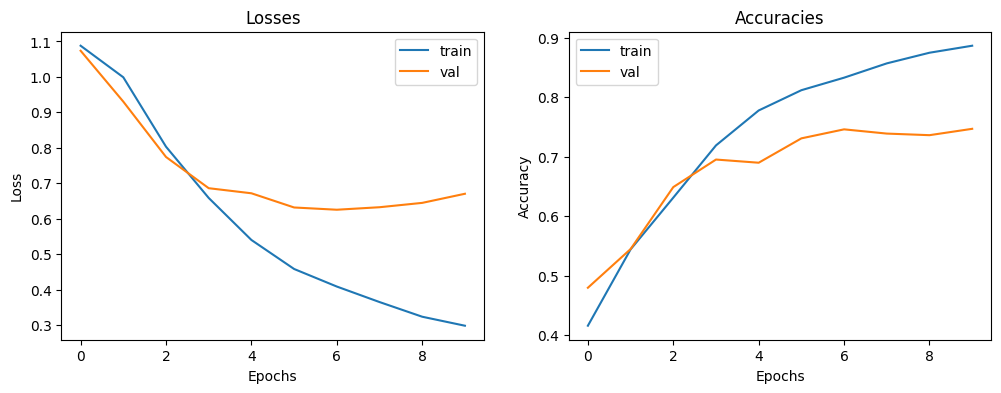

num_epochs = 2
Test correct = 498

Test total dataitem = 750

Test Accuracy = 0.6639999747276306

              precision    recall  f1-score   support

    negative       0.71      0.63      0.67       250
     neutral       0.62      0.73      0.67       250
    positive       0.68      0.63      0.65       250

    accuracy                           0.66       750
   macro avg       0.67      0.66      0.66       750
weighted avg       0.67      0.66      0.66       750



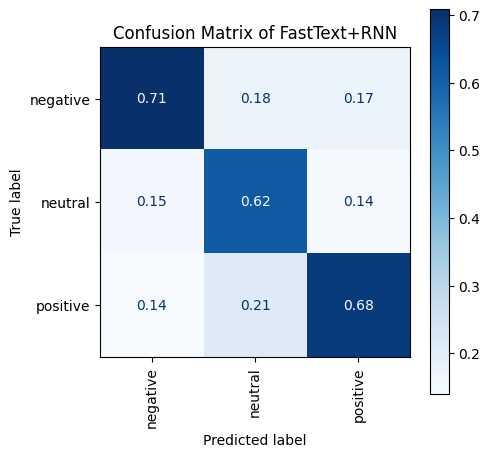

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 183.92it/s]


loss = 1.0885156609583646, val_loss =1.072090218145223, accuracy = 0.4213253855705261, val_accuracy = 0.4728406071662903


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 183.60it/s]


loss = 0.9781652136845514, val_loss =0.8934215001388645, accuracy = 0.5467965006828308, val_accuracy = 0.5316117405891418


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 180.56it/s]


loss = 0.7769691569998395, val_loss =0.7760650506304089, accuracy = 0.6400753855705261, val_accuracy = 0.6188780069351196


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 181.80it/s]


loss = 0.6626566644084232, val_loss =0.688844791008991, accuracy = 0.7115263938903809, val_accuracy = 0.6794301271438599


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 181.34it/s]


loss = 0.5686704946218378, val_loss =0.645810700905482, accuracy = 0.757066547870636, val_accuracy = 0.7088156938552856


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 188.28it/s]


loss = 0.4722976993844168, val_loss =0.6301156423420166, accuracy = 0.8052763938903809, val_accuracy = 0.7275155782699585


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 177.21it/s]


loss = 0.41170693129161007, val_loss =0.6314491609543597, accuracy = 0.8319723606109619, val_accuracy = 0.7435441017150879


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 182.85it/s]


loss = 0.3617863722591301, val_loss =0.645990722031615, accuracy = 0.8544284105300903, val_accuracy = 0.7399821877479553


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 188.21it/s]


loss = 0.3310328152074703, val_loss =0.6631514290896683, accuracy = 0.8685615658760071, val_accuracy = 0.7497773766517639


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 148.16it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.304006216305238, val_loss =0.6715598384553615, accuracy = 0.8804962038993835, val_accuracy = 0.7399821877479553


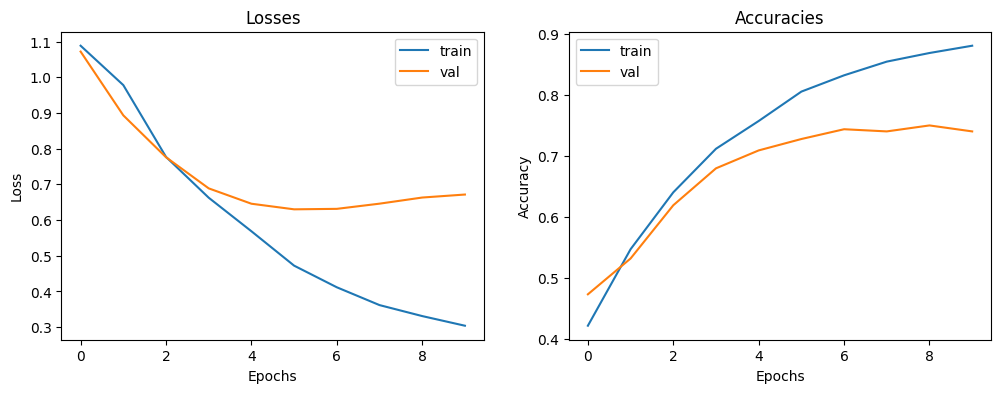

num_epochs = 3
Test correct = 478

Test total dataitem = 750

Test Accuracy = 0.637333333492279

              precision    recall  f1-score   support

    negative       0.72      0.54      0.62       250
     neutral       0.57      0.77      0.66       250
    positive       0.67      0.60      0.63       250

    accuracy                           0.64       750
   macro avg       0.65      0.64      0.64       750
weighted avg       0.65      0.64      0.64       750



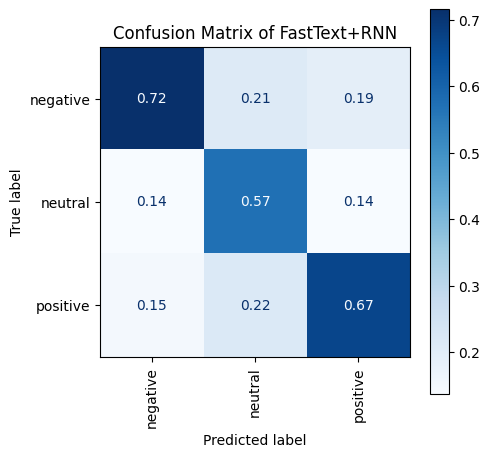

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 157.31it/s]


loss = 1.0920208722539246, val_loss =1.0803096272406123, accuracy = 0.4015389382839203, val_accuracy = 0.4933214783668518


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 87.93it/s]


loss = 1.022734162355773, val_loss =0.9258571172583966, accuracy = 0.5766331553459167, val_accuracy = 0.5966162085533142


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 71.59it/s]


loss = 0.7542980017838999, val_loss =0.7064239916398138, accuracy = 0.6915829181671143, val_accuracy = 0.6865538954734802


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 98.25it/s]


loss = 0.5727814928010048, val_loss =0.6450046943535748, accuracy = 0.770100474357605, val_accuracy = 0.7212823033332825


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 100.11it/s]


loss = 0.4737279418155231, val_loss =0.6244623360664322, accuracy = 0.8112437129020691, val_accuracy = 0.7390917539596558


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 95.26it/s]


loss = 0.4189295363469682, val_loss =0.5987685526980862, accuracy = 0.8373115658760071, val_accuracy = 0.7577916383743286


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 110.77it/s]


loss = 0.3716899822186042, val_loss =0.6002072724319453, accuracy = 0.8544284105300903, val_accuracy = 0.7551202178001404


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 87.98it/s]


loss = 0.3297291853318939, val_loss =0.609772796874466, accuracy = 0.8710741400718689, val_accuracy = 0.7542297840118408


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 181.97it/s]


loss = 0.2989519033469537, val_loss =0.654928824853833, accuracy = 0.8883479833602905, val_accuracy = 0.7462155222892761


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 179.32it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.2686614788120306, val_loss =0.666202807552442, accuracy = 0.8993404507637024, val_accuracy = 0.7471059560775757


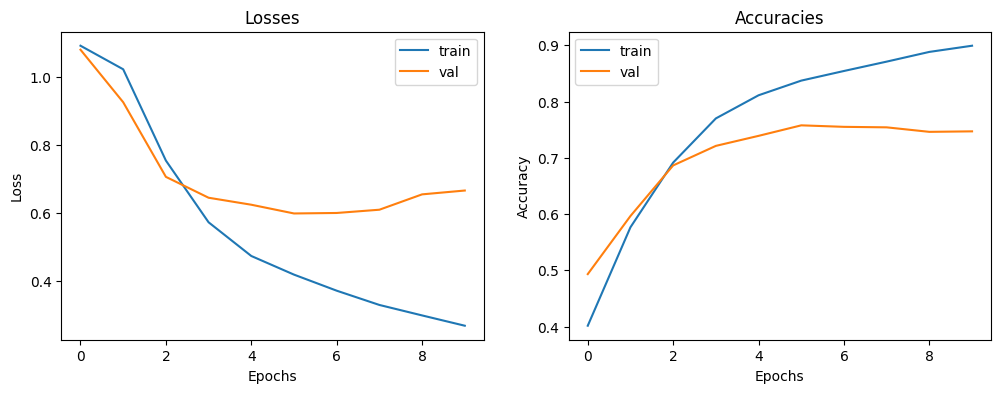

num_epochs = 4
Test correct = 487

Test total dataitem = 750

Test Accuracy = 0.6493332982063293

              precision    recall  f1-score   support

    negative       0.71      0.61      0.66       250
     neutral       0.58      0.74      0.65       250
    positive       0.69      0.59      0.64       250

    accuracy                           0.65       750
   macro avg       0.66      0.65      0.65       750
weighted avg       0.66      0.65      0.65       750



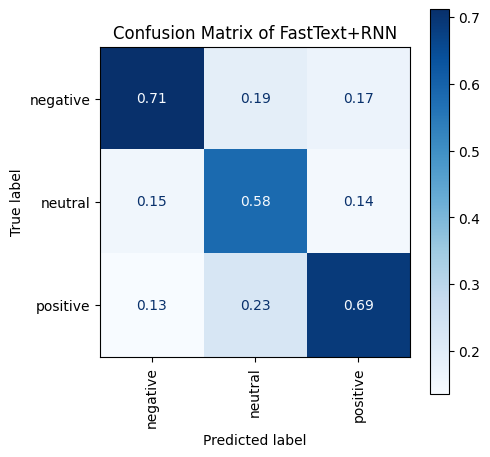

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 182.71it/s]


loss = 1.0889648274332284, val_loss =1.0771388111502995, accuracy = 0.4188128113746643, val_accuracy = 0.4826357960700989


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 179.80it/s]


loss = 1.002804632517509, val_loss =0.9317838526042621, accuracy = 0.5422424674034119, val_accuracy = 0.5529831051826477


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 184.73it/s]


loss = 0.7776852843689267, val_loss =0.7326660836575597, accuracy = 0.6623743772506714, val_accuracy = 0.6821015477180481


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 180.80it/s]


loss = 0.5837165021120745, val_loss =0.6521121165639857, accuracy = 0.759736180305481, val_accuracy = 0.7292965650558472


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 159.53it/s]


loss = 0.49159023752610664, val_loss =0.6445002540643535, accuracy = 0.8007223606109619, val_accuracy = 0.7168299555778503


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 155.98it/s]


loss = 0.4311864584215255, val_loss =0.6287412687520416, accuracy = 0.8245916962623596, val_accuracy = 0.741763174533844


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 152.09it/s]


loss = 0.3835296825374644, val_loss =0.6436673792614437, accuracy = 0.8536431789398193, val_accuracy = 0.7301869988441467


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 151.23it/s]


loss = 0.3442042998183297, val_loss =0.6543497813943601, accuracy = 0.870445966720581, val_accuracy = 0.732858419418335


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 144.01it/s]


loss = 0.3139772362015015, val_loss =0.6684479858510785, accuracy = 0.8803392052650452, val_accuracy = 0.741763174533844


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 147.23it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.2890693550721983, val_loss =0.6838935237124422, accuracy = 0.8896042704582214, val_accuracy = 0.7337489128112793


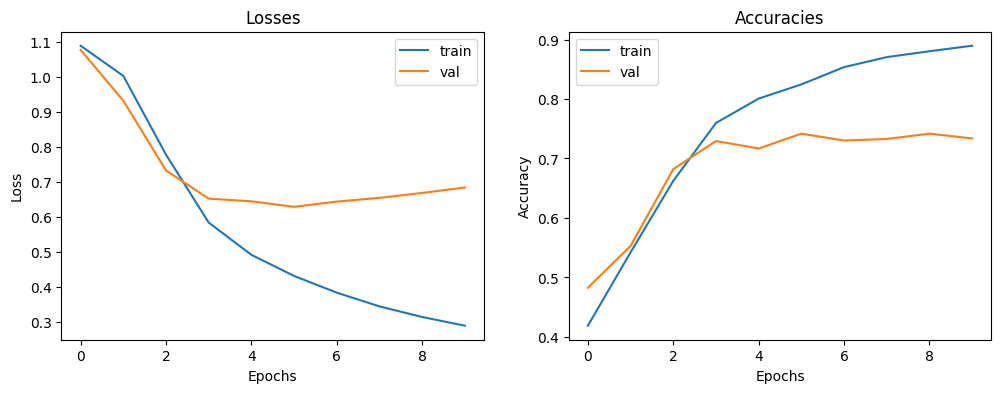

num_epochs = 5
Test correct = 475

Test total dataitem = 750

Test Accuracy = 0.6333333253860474

              precision    recall  f1-score   support

    negative       0.73      0.54      0.62       250
     neutral       0.61      0.68      0.64       250
    positive       0.59      0.68      0.64       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.64      0.63      0.63       750



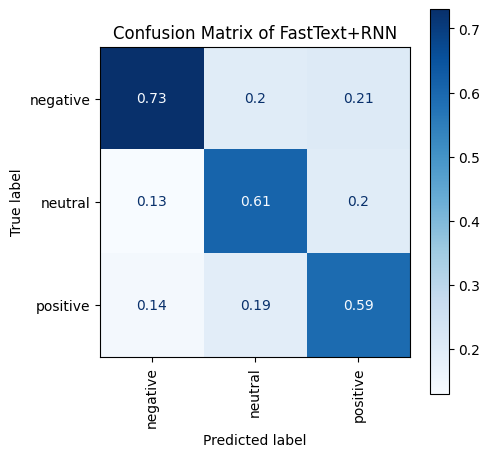

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 182.10it/s]


loss = 1.0813874648232014, val_loss =1.0434251056762323, accuracy = 0.40609297156333923, val_accuracy = 0.4692787230014801


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 180.18it/s]


loss = 0.93273580143461, val_loss =0.8184960658107663, accuracy = 0.5599874258041382, val_accuracy = 0.6215494275093079


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 180.13it/s]


loss = 0.724781146060559, val_loss =0.7155877178806501, accuracy = 0.6807475090026855, val_accuracy = 0.677649199962616


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 182.87it/s]


loss = 0.5852054944408883, val_loss =0.6517818800710042, accuracy = 0.7556532621383667, val_accuracy = 0.7034728527069092


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 176.15it/s]


loss = 0.48917919760984657, val_loss =0.6338305274258706, accuracy = 0.7974246144294739, val_accuracy = 0.7186108827590942


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 182.40it/s]


loss = 0.41824605217474525, val_loss =0.6265675297640031, accuracy = 0.8319723606109619, val_accuracy = 0.7355298399925232


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 184.16it/s]


loss = 0.3695615908728723, val_loss =0.6223189233341304, accuracy = 0.8525439500808716, val_accuracy = 0.7364203333854675


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 181.11it/s]


loss = 0.3333322857486155, val_loss =0.6332286284925879, accuracy = 0.8712311387062073, val_accuracy = 0.7595725655555725


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 183.71it/s]


loss = 0.3011477342248565, val_loss =0.653061207524557, accuracy = 0.8863065242767334, val_accuracy = 0.74799644947052


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 176.24it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.2710147666928293, val_loss =0.6779041545420013, accuracy = 0.8940012454986572, val_accuracy = 0.7551202178001404


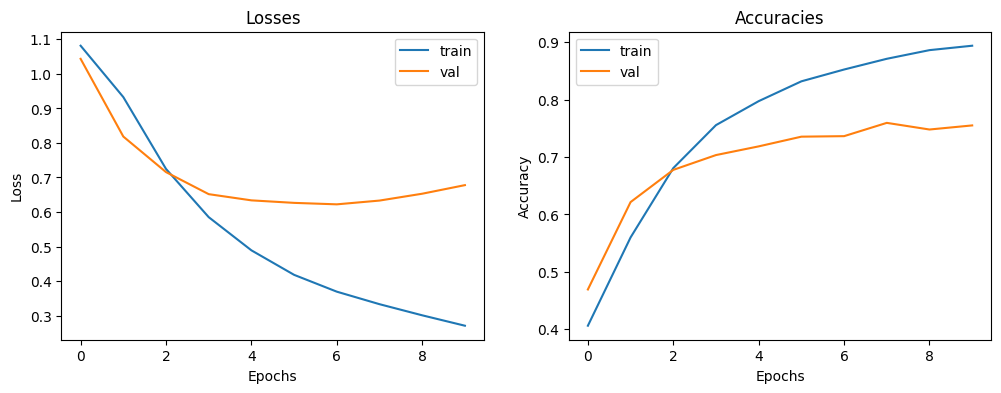

num_epochs = 6
Test correct = 469

Test total dataitem = 750

Test Accuracy = 0.625333309173584

              precision    recall  f1-score   support

    negative       0.77      0.49      0.60       250
     neutral       0.59      0.70      0.64       250
    positive       0.58      0.69      0.63       250

    accuracy                           0.63       750
   macro avg       0.65      0.63      0.62       750
weighted avg       0.65      0.63      0.62       750



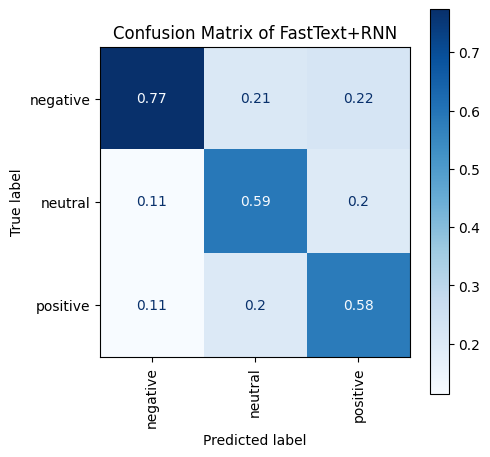

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 182.99it/s]


loss = 1.0910403919033707, val_loss =1.077913196344993, accuracy = 0.3933731019496918, val_accuracy = 0.480854868888855


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 176.56it/s]


loss = 0.9941966744465753, val_loss =0.864778704039516, accuracy = 0.5452260971069336, val_accuracy = 0.6073018908500671


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 180.26it/s]


loss = 0.7487728951065219, val_loss =0.7085805315912391, accuracy = 0.6724246144294739, val_accuracy = 0.6723063588142395


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 176.11it/s]


loss = 0.6042243311855419, val_loss =0.6679496124409654, accuracy = 0.7438756227493286, val_accuracy = 0.7079252004623413


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 168.83it/s]


loss = 0.5051417168990155, val_loss =0.6699031479533352, accuracy = 0.7938128113746643, val_accuracy = 0.7123775482177734


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 152.75it/s]


loss = 0.4438533199831363, val_loss =0.6243804520121702, accuracy = 0.8198806643486023, val_accuracy = 0.7364203333854675


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 143.67it/s]


loss = 0.39646058393462225, val_loss =0.6395038287416196, accuracy = 0.8445351719856262, val_accuracy = 0.7390917539596558


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 150.65it/s]


loss = 0.36330460287433425, val_loss =0.6682040758816626, accuracy = 0.8597675561904907, val_accuracy = 0.7382012605667114


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 140.99it/s]


loss = 0.32753253327856785, val_loss =0.6889255473690521, accuracy = 0.8764132857322693, val_accuracy = 0.7275155782699585


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 142.31it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.30490837829425116, val_loss =0.7329010506400714, accuracy = 0.8823806643486023, val_accuracy = 0.732858419418335


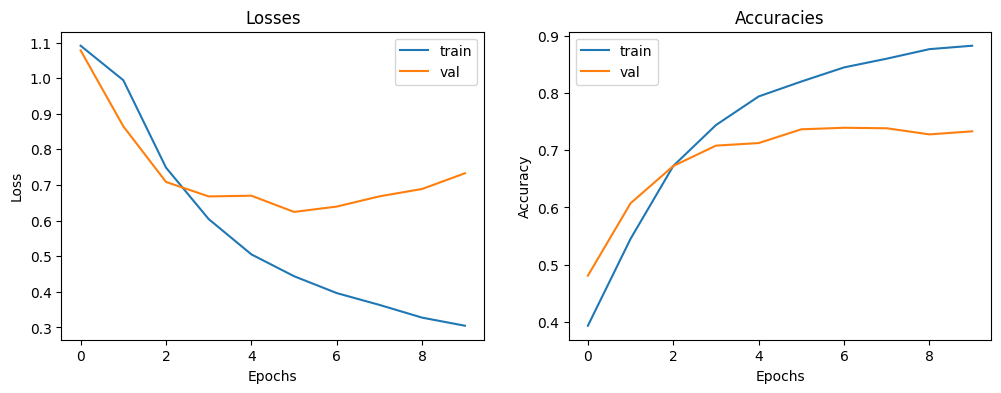

num_epochs = 7
Test correct = 451

Test total dataitem = 750

Test Accuracy = 0.6013333201408386

              precision    recall  f1-score   support

    negative       0.82      0.44      0.57       250
     neutral       0.58      0.65      0.61       250
    positive       0.53      0.71      0.61       250

    accuracy                           0.60       750
   macro avg       0.64      0.60      0.60       750
weighted avg       0.64      0.60      0.60       750



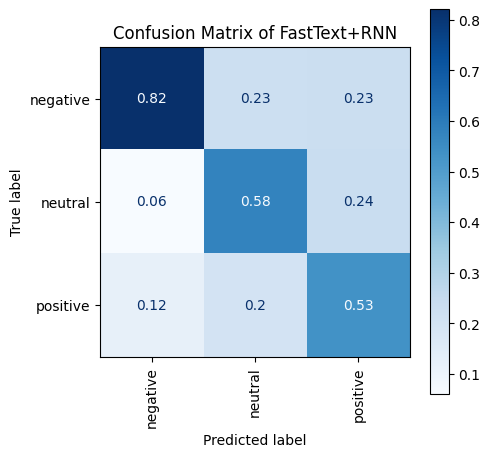

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 179.43it/s]


loss = 1.0888834774307907, val_loss =1.0776782821183877, accuracy = 0.40829145908355713, val_accuracy = 0.4933214783668518


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 183.82it/s]


loss = 1.0088344372669236, val_loss =0.9448924440166189, accuracy = 0.5741205811500549, val_accuracy = 0.5752449035644531


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 182.29it/s]


loss = 0.7951336907106452, val_loss =0.7701502454855169, accuracy = 0.6669284105300903, val_accuracy = 0.6829919815063477


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 181.24it/s]


loss = 0.6068916787773196, val_loss =0.686725047254327, accuracy = 0.759736180305481, val_accuracy = 0.7061442732810974


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 181.52it/s]


loss = 0.496679691994359, val_loss =0.6642746133836991, accuracy = 0.8057474493980408, val_accuracy = 0.7337489128112793


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 176.40it/s]


loss = 0.4339743762543003, val_loss =0.637906487170611, accuracy = 0.8269472122192383, val_accuracy = 0.7471059560775757


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 182.21it/s]


loss = 0.37374005120927906, val_loss =0.6320779797470701, accuracy = 0.8591394424438477, val_accuracy = 0.7471059560775757


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 178.13it/s]


loss = 0.3338539529659738, val_loss =0.6460070788412389, accuracy = 0.8720163106918335, val_accuracy = 0.7453250288963318


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 180.47it/s]


loss = 0.3075673352565627, val_loss =0.6485832046603185, accuracy = 0.8861494660377502, val_accuracy = 0.74799644947052


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 179.26it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.289473055858889, val_loss =0.6705127989482107, accuracy = 0.8936871886253357, val_accuracy = 0.7462155222892761


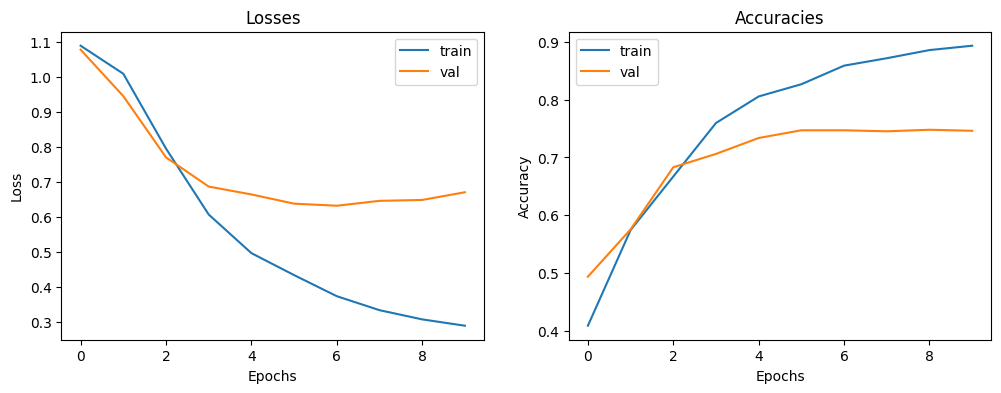

num_epochs = 8
Test correct = 483

Test total dataitem = 750

Test Accuracy = 0.6439999938011169

              precision    recall  f1-score   support

    negative       0.73      0.55      0.63       250
     neutral       0.59      0.75      0.66       250
    positive       0.65      0.64      0.64       250

    accuracy                           0.64       750
   macro avg       0.66      0.64      0.64       750
weighted avg       0.66      0.64      0.64       750



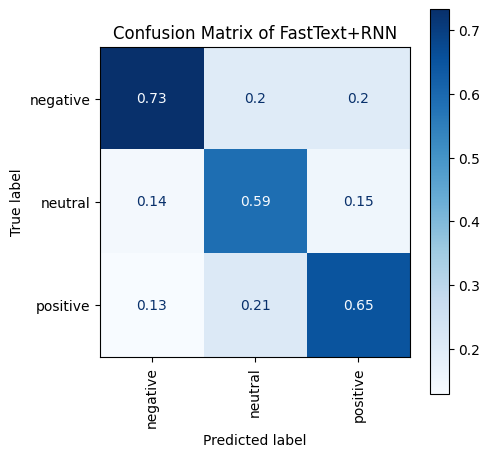

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 174.87it/s]


loss = 1.090502657936886, val_loss =1.0804950625783514, accuracy = 0.4035803973674774, val_accuracy = 0.4772929847240448


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 179.90it/s]


loss = 1.009938657595776, val_loss =0.9113369883052886, accuracy = 0.5532349348068237, val_accuracy = 0.6170970797538757


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 172.33it/s]


loss = 0.7663319725438487, val_loss =0.7135771673937727, accuracy = 0.6780778765678406, val_accuracy = 0.6821015477180481


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 183.68it/s]


loss = 0.6017174460052047, val_loss =0.6538747028385784, accuracy = 0.7559673190116882, val_accuracy = 0.7177203893661499


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 172.89it/s]


loss = 0.5132806869620982, val_loss =0.6414615545012307, accuracy = 0.7933416962623596, val_accuracy = 0.7266251444816589


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 143.05it/s]


loss = 0.4423698977263848, val_loss =0.6277936836770903, accuracy = 0.8299309015274048, val_accuracy = 0.732858419418335


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 152.50it/s]


loss = 0.39165382039529506, val_loss =0.6307424956713982, accuracy = 0.8479899168014526, val_accuracy = 0.7284060716629028


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 155.84it/s]


loss = 0.36102987952977855, val_loss =0.6524064055448853, accuracy = 0.8594534993171692, val_accuracy = 0.732858419418335


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 146.27it/s]


loss = 0.32619308421973076, val_loss =0.6531345259781423, accuracy = 0.8789258599281311, val_accuracy = 0.7390917539596558


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 150.97it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.29635090908718664, val_loss =0.6661386416155265, accuracy = 0.8883479833602905, val_accuracy = 0.7390917539596558


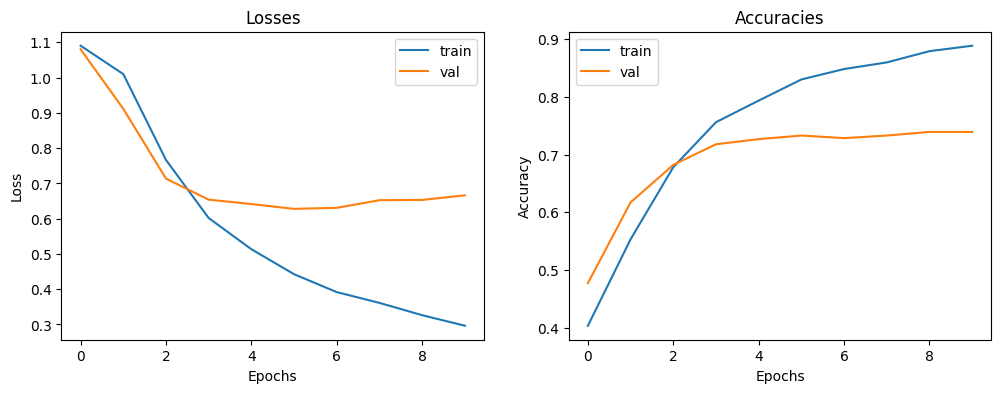

num_epochs = 10
Test correct = 474

Test total dataitem = 750

Test Accuracy = 0.6319999694824219

              precision    recall  f1-score   support

    negative       0.72      0.56      0.63       250
     neutral       0.58      0.70      0.63       250
    positive       0.63      0.64      0.63       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.64      0.63      0.63       750



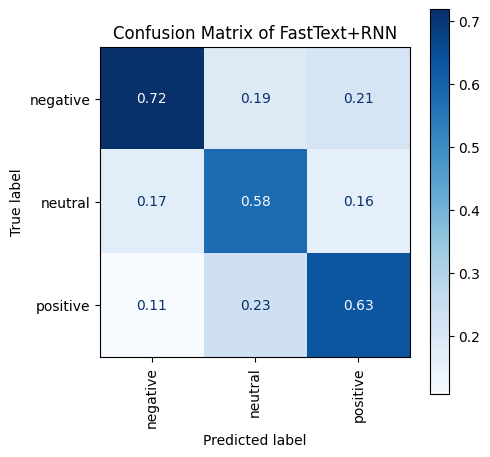

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 178.72it/s]


loss = 1.0872726682573557, val_loss =1.075159349691655, accuracy = 0.4167713522911072, val_accuracy = 0.4710596799850464


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 176.29it/s]


loss = 1.010363068152219, val_loss =0.9454389144703451, accuracy = 0.5549622774124146, val_accuracy = 0.5503116846084595


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 178.77it/s]


loss = 0.7964125505066477, val_loss =0.7557688750103042, accuracy = 0.6622173190116882, val_accuracy = 0.6598397493362427


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 176.01it/s]


loss = 0.6125080665636051, val_loss =0.669969437898521, accuracy = 0.7510992288589478, val_accuracy = 0.6999109983444214


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 178.28it/s]


loss = 0.4992628149672964, val_loss =0.6335107296719567, accuracy = 0.7993090152740479, val_accuracy = 0.7301869988441467


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 176.01it/s]


loss = 0.42863109797126525, val_loss =0.6117665408885624, accuracy = 0.8308731317520142, val_accuracy = 0.7435441017150879


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 156.95it/s]


loss = 0.37615112028487147, val_loss =0.618337191140381, accuracy = 0.8530150651931763, val_accuracy = 0.7364203333854675


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 151.34it/s]


loss = 0.3357241232164222, val_loss =0.6415029879547157, accuracy = 0.8724874258041382, val_accuracy = 0.7444345951080322


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 148.74it/s]


loss = 0.30407451399207275, val_loss =0.6642158452521781, accuracy = 0.8833228349685669, val_accuracy = 0.7390917539596558


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 157.57it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.273682471047411, val_loss =0.6597131136214857, accuracy = 0.8974560499191284, val_accuracy = 0.7471059560775757


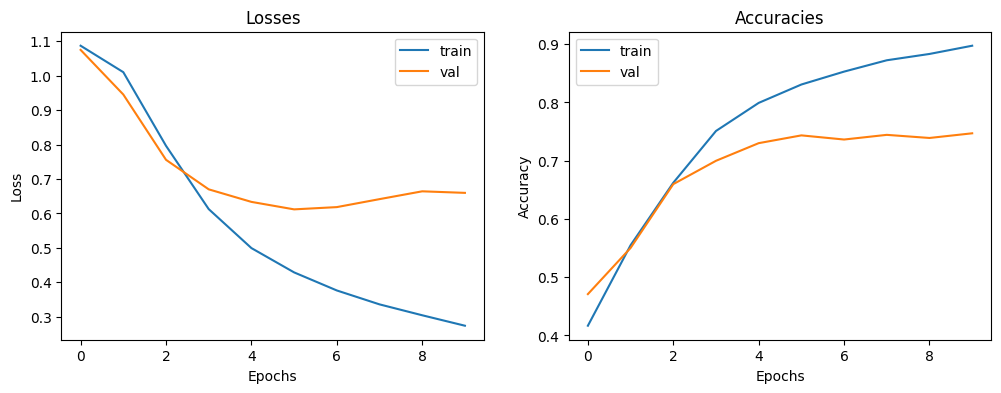

num_epochs = 12
Test correct = 490

Test total dataitem = 750

Test Accuracy = 0.653333306312561

              precision    recall  f1-score   support

    negative       0.74      0.61      0.67       250
     neutral       0.61      0.72      0.66       250
    positive       0.64      0.63      0.64       250

    accuracy                           0.65       750
   macro avg       0.66      0.65      0.65       750
weighted avg       0.66      0.65      0.65       750



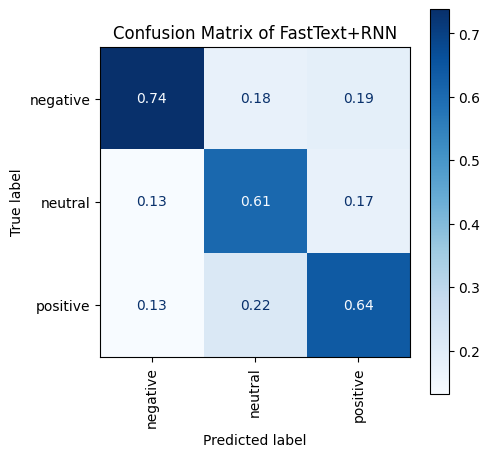

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 141.12it/s]


loss = 1.0883815173245965, val_loss =1.0735958428890813, accuracy = 0.4097047746181488, val_accuracy = 0.4692787230014801


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 180.78it/s]


loss = 1.0006131384707988, val_loss =0.9095414168356607, accuracy = 0.5406721234321594, val_accuracy = 0.5699020624160767


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 173.39it/s]


loss = 0.7837710291502299, val_loss =0.7494891698535953, accuracy = 0.6496545076370239, val_accuracy = 0.6402493715286255


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 171.32it/s]


loss = 0.6405281061530695, val_loss =0.6728189428754304, accuracy = 0.7189069986343384, val_accuracy = 0.690115749835968


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 144.47it/s]


loss = 0.524275104194021, val_loss =0.6329224279424197, accuracy = 0.776695966720581, val_accuracy = 0.7239537239074707


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 144.29it/s]


loss = 0.4523208622104903, val_loss =0.6286258408058601, accuracy = 0.8131281137466431, val_accuracy = 0.7284060716629028


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 149.46it/s]


loss = 0.40032931144206485, val_loss =0.6402571700215871, accuracy = 0.8363693356513977, val_accuracy = 0.732858419418335


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 148.98it/s]


loss = 0.3590774367551967, val_loss =0.6449966091979208, accuracy = 0.8577260971069336, val_accuracy = 0.7212823033332825


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 144.48it/s]


loss = 0.32585925281728806, val_loss =0.6569308786113139, accuracy = 0.8732725977897644, val_accuracy = 0.7373107671737671


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 149.35it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.30122772773164913, val_loss =0.6856448159995208, accuracy = 0.8852072954177856, val_accuracy = 0.7248441576957703


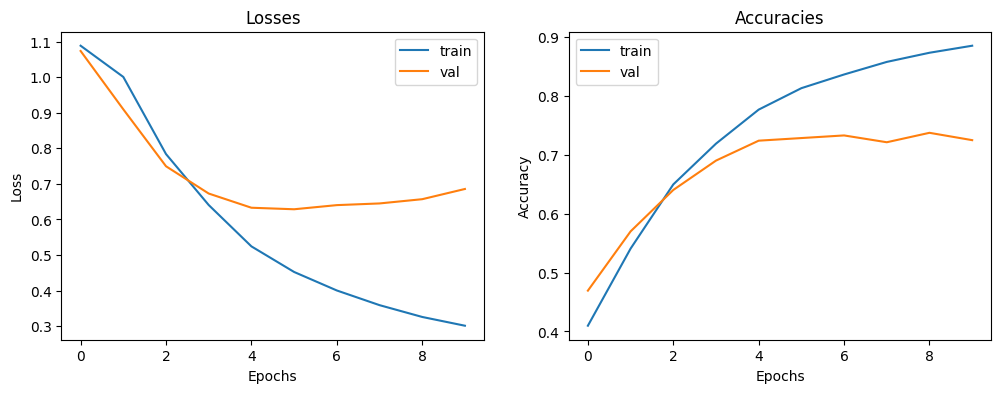

num_epochs = 15
Test correct = 453

Test total dataitem = 750

Test Accuracy = 0.6039999723434448

              precision    recall  f1-score   support

    negative       0.75      0.46      0.57       250
     neutral       0.59      0.66      0.62       250
    positive       0.55      0.69      0.61       250

    accuracy                           0.60       750
   macro avg       0.63      0.60      0.60       750
weighted avg       0.63      0.60      0.60       750



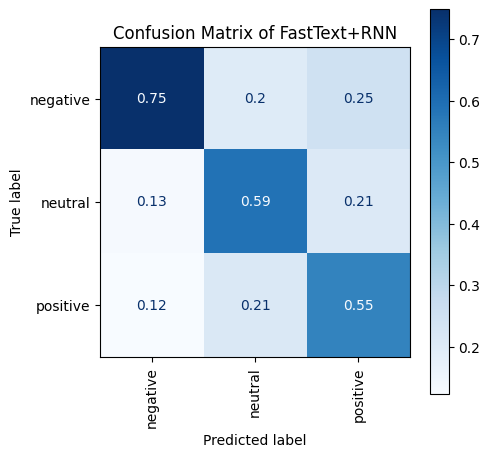

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 182.04it/s]


loss = 1.0919605514686554, val_loss =1.0816206189626385, accuracy = 0.3980841636657715, val_accuracy = 0.48174533247947693


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 177.21it/s]


loss = 1.015516356858425, val_loss =0.9106870743209525, accuracy = 0.5697236061096191, val_accuracy = 0.6081923842430115


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 179.18it/s]


loss = 0.8035237172595225, val_loss =0.7586762261453144, accuracy = 0.6658291220664978, val_accuracy = 0.6705253720283508


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 179.15it/s]


loss = 0.6246399286139058, val_loss =0.7027035305141619, accuracy = 0.7452889084815979, val_accuracy = 0.7034728527069092


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 174.37it/s]


loss = 0.5217032127093989, val_loss =0.673898271057618, accuracy = 0.7949120402336121, val_accuracy = 0.7310774922370911


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 181.21it/s]


loss = 0.45039828968314394, val_loss =0.636584856007262, accuracy = 0.827418327331543, val_accuracy = 0.7364203333854675


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 175.78it/s]


loss = 0.3996326000436966, val_loss =0.6550742620541964, accuracy = 0.8475188612937927, val_accuracy = 0.7346394062042236


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 178.65it/s]


loss = 0.36736411092420895, val_loss =0.6695914158501037, accuracy = 0.8603957295417786, val_accuracy = 0.7408726811408997


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 175.50it/s]


loss = 0.3311193605506469, val_loss =0.6827601372640365, accuracy = 0.872330367565155, val_accuracy = 0.7275155782699585


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 169.26it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.3077981030868614, val_loss =0.6775741782629117, accuracy = 0.8872487545013428, val_accuracy = 0.7408726811408997


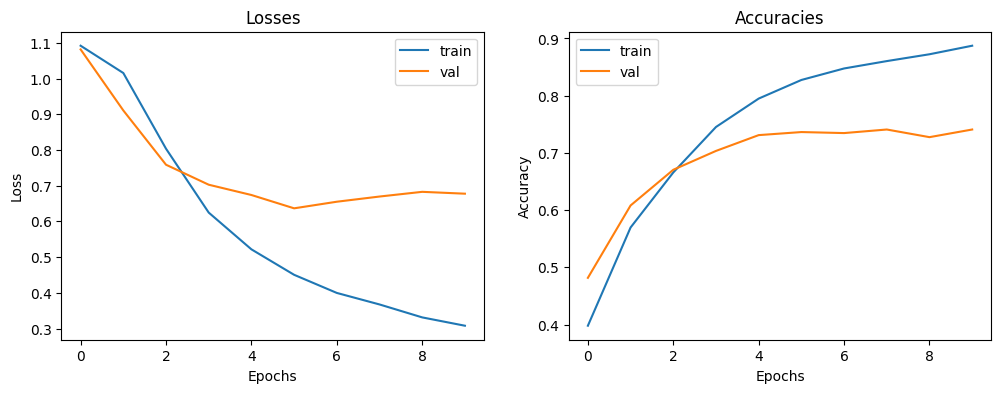

num_epochs = 18
Test correct = 492

Test total dataitem = 750

Test Accuracy = 0.656000018119812

              precision    recall  f1-score   support

    negative       0.73      0.58      0.64       250
     neutral       0.60      0.76      0.67       250
    positive       0.68      0.63      0.65       250

    accuracy                           0.66       750
   macro avg       0.67      0.66      0.66       750
weighted avg       0.67      0.66      0.66       750



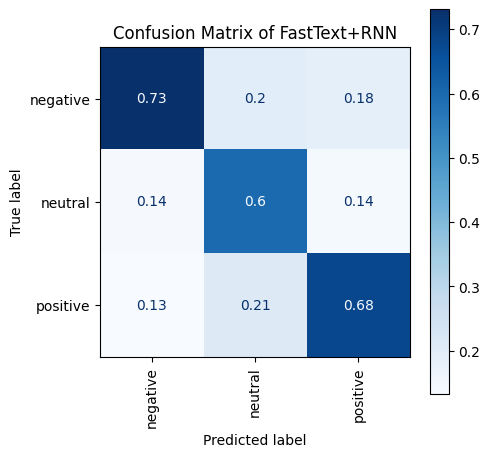

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 176.75it/s]


loss = 1.0930870578344911, val_loss =1.0841191367763612, accuracy = 0.3883479833602905, val_accuracy = 0.46215495467185974


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 177.65it/s]


loss = 1.0393324109027162, val_loss =0.9569718537349549, accuracy = 0.5434987545013428, val_accuracy = 0.5734639763832092


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 170.39it/s]


loss = 0.8124204681185074, val_loss =0.7407491587952431, accuracy = 0.6507537364959717, val_accuracy = 0.6651825904846191


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 171.05it/s]


loss = 0.6202740495910984, val_loss =0.665693660693877, accuracy = 0.7434045076370239, val_accuracy = 0.7319679856300354


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 151.24it/s]


loss = 0.5110818884684705, val_loss =0.6334858767192586, accuracy = 0.7953831553459167, val_accuracy = 0.7212823033332825


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 156.73it/s]


loss = 0.432295172759259, val_loss =0.6306821071208337, accuracy = 0.8282034993171692, val_accuracy = 0.74799644947052


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 135.45it/s]


loss = 0.3837376975998268, val_loss =0.6238880248797484, accuracy = 0.8527010083198547, val_accuracy = 0.7444345951080322


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 148.04it/s]


loss = 0.3457370830654645, val_loss =0.632026860464258, accuracy = 0.8680904507637024, val_accuracy = 0.758682131767273


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 146.38it/s]


loss = 0.3061532741215569, val_loss =0.6486080826240451, accuracy = 0.8822236061096191, val_accuracy = 0.7542297840118408


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 140.40it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.28038750198444634, val_loss =0.6702234685349039, accuracy = 0.8922738432884216, val_accuracy = 0.7444345951080322


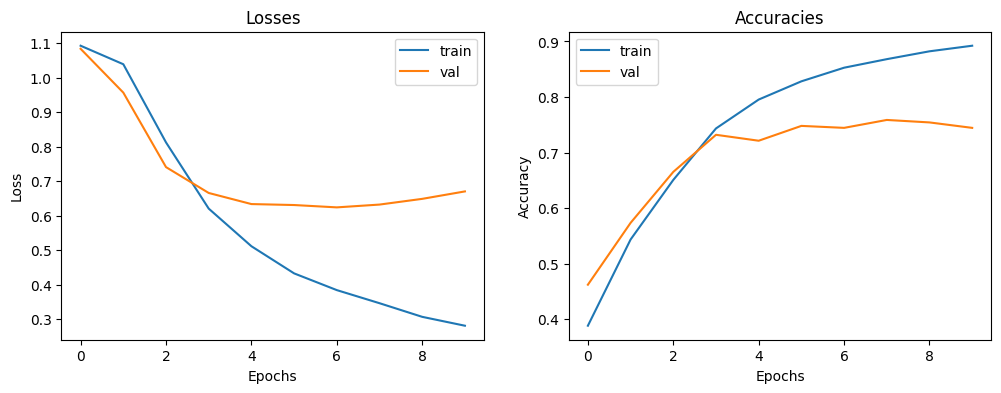

num_epochs = 20
Test correct = 494

Test total dataitem = 750

Test Accuracy = 0.6586666703224182

              precision    recall  f1-score   support

    negative       0.75      0.56      0.65       250
     neutral       0.62      0.76      0.68       250
    positive       0.63      0.65      0.64       250

    accuracy                           0.66       750
   macro avg       0.67      0.66      0.66       750
weighted avg       0.67      0.66      0.66       750



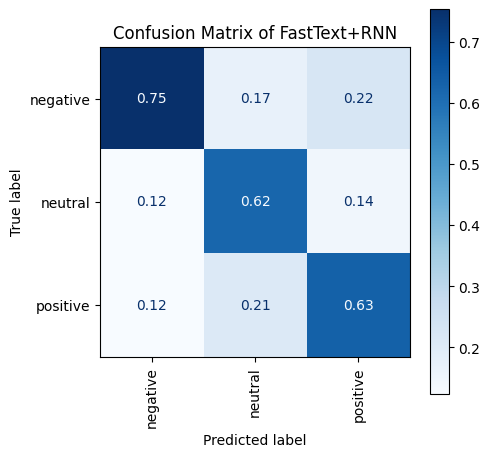

In [ ]:
bidirectional=True
num_layers=2
hidden_size1=64
hidden_size2=128
droprate=0.1
freeze_embedding=False
learning_rate=0.0001
bidirectional_options=[True,False]
num_epochs=[2,3,4,5,6,7,8,10,12,15,18,20]
for num_epoch in num_epochs:
  model=RNN(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+RNN'
  print(f'num_epochs = {num_epoch}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 118/118 [00:00<00:00, 150.49it/s]


loss = 1.0867368779487192, accuracy = 0.43972766399383545


Epoch 2: 100%|██████████| 118/118 [00:00<00:00, 156.19it/s]


loss = 0.950378375811276, accuracy = 0.5896409153938293


Epoch 3: 100%|██████████| 118/118 [00:00<00:00, 144.63it/s]


loss = 0.6941528329482674, accuracy = 0.7059137225151062


Epoch 4: 100%|██████████| 118/118 [00:00<00:00, 147.54it/s]


loss = 0.5498985503070973, accuracy = 0.769456684589386


Epoch 5: 100%|██████████| 118/118 [00:00<00:00, 168.80it/s]


loss = 0.47650664818905114, accuracy = 0.806834876537323


Epoch 6: 100%|██████████| 118/118 [00:00<00:00, 185.51it/s]


loss = 0.4167862738600878, accuracy = 0.8323321342468262


Epoch 7: 100%|██████████| 118/118 [00:00<00:00, 179.52it/s]


loss = 0.37329422273804513, accuracy = 0.8486183285713196


Epoch 8: 100%|██████████| 118/118 [00:00<00:00, 183.92it/s]


loss = 0.33981184053724417, accuracy = 0.8665064573287964


Epoch 9: 100%|██████████| 118/118 [00:00<00:00, 186.21it/s]


loss = 0.3078867793769089, accuracy = 0.8779869079589844


Epoch 10: 100%|██████████| 118/118 [00:00<00:00, 182.09it/s]


loss = 0.28828184910012195, accuracy = 0.8871979713439941


Epoch 11: 100%|██████████| 118/118 [00:00<00:00, 184.16it/s]


loss = 0.26683096693558567, accuracy = 0.8960085511207581


Epoch 12: 100%|██████████| 118/118 [00:00<00:00, 181.94it/s]


loss = 0.24302032026018056, accuracy = 0.9073554873466492


Epoch 13: 100%|██████████| 118/118 [00:00<00:00, 183.16it/s]


loss = 0.23092709654860247, accuracy = 0.9148311018943787


Epoch 14: 100%|██████████| 118/118 [00:00<00:00, 184.39it/s]


loss = 0.21944006294921262, accuracy = 0.9153650999069214


Epoch 15: 100%|██████████| 118/118 [00:00<00:00, 187.11it/s]


loss = 0.20730917480464514, accuracy = 0.9257775545120239


Epoch 16: 100%|██████████| 118/118 [00:00<00:00, 182.50it/s]


loss = 0.19194645248541176, accuracy = 0.9303163290023804


Epoch 17: 100%|██████████| 118/118 [00:00<00:00, 185.90it/s]


loss = 0.17730016749326802, accuracy = 0.9349886178970337


Epoch 18: 100%|██████████| 118/118 [00:00<00:00, 183.73it/s]


loss = 0.16556772244953408, accuracy = 0.9368575215339661


Epoch 19: 100%|██████████| 118/118 [00:00<00:00, 187.07it/s]


loss = 0.1530092317543296, accuracy = 0.945401132106781


Epoch 20: 100%|██████████| 118/118 [00:00<00:00, 177.58it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.14693613181782175, accuracy = 0.945134162902832


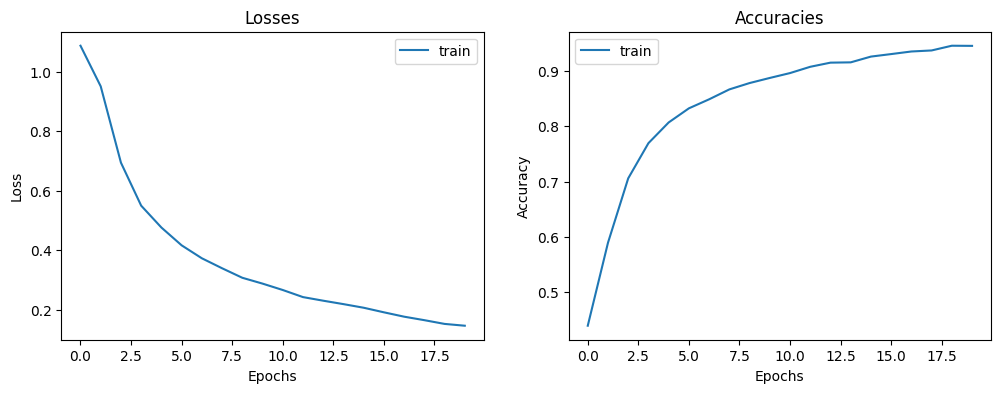

Test correct = 470

Test total dataitem = 750

Test Accuracy = 0.6266666650772095

              precision    recall  f1-score   support

    negative       0.70      0.53      0.60       250
     neutral       0.58      0.72      0.64       250
    positive       0.62      0.63      0.63       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.62       750
weighted avg       0.64      0.63      0.62       750



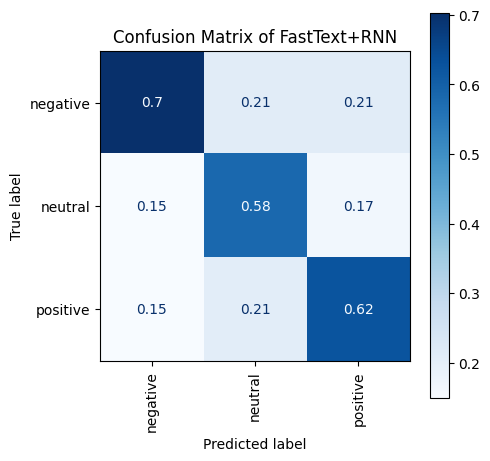

In [ ]:
bidirectional=True
num_layers=2
hidden_size1=64
hidden_size2=128
droprate=0.1
freeze_embedding=False
learning_rate=0.0001
epoch=20
model=RNN(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
train(model,epoch,optimizer,criterion,full_dataloader)
model_name='FastText+RNN'
test_and_report(model,test_loader,model_name)

# **Attention**

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, rnn_size):
        super(AttentionLayer, self).__init__()
        self.U = nn.Linear(rnn_size, 1,bias=False) # for the learnable paramter u
        torch.nn.init.xavier_normal_(self.U.weight)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden_states):
        # α = softmax(u_t^T U)
        attention_weights = self.U(hidden_states) # (batch_size, seq_len ,1)
        attention_weights = self.softmax(attention_weights.squeeze(2))  # (batch_size, seq_len)

        # eq.11: v = sum( α * hidden_states )
        attention_output = hidden_states * attention_weights.unsqueeze(2)  # (batch_size, seq_len, rnn_size)
        attention_output = attention_output.sum(dim = 1)  # (batch_size, rnn_size)

        return attention_output, attention_weights

In [ ]:
class AttentionRNN(nn.Module):
  def __init__(self,fasttext_weights,hidden_size1,hidden_size2,freeze_embedding=True,droprate=0.5,num_layers=1,num_classes=3,dider=True):
    super(AttentionRNN,self).__init__()
    self.embedding=nn.Embedding.from_pretrained(torch.FloatTensor(fasttext_weights),freeze=freeze_embedding)
    self.rnn=nn.RNN(self.embedding.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    self.dropout=nn.Dropout(droprate)
    self.d=2 if dider else 1
    self.attention=AttentionLayer(hidden_size1*self.d)
    self.fc1=nn.Linear(hidden_size1*self.d,hidden_size2)
    self.fc2=nn.Linear(hidden_size2,num_classes)

    #torch.nn.init.xavier_uniform_(self.fc1.weight)
    #torch.nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self,x):
    x=self.embedding(x)
    x,h=self.rnn(x)
    x,attention_weights=self.attention(x)
    x=self.fc1(x)
    x=F.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    return x,attention_weights

You're on a cuda


Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 125.44it/s]


loss = 1.0951523096859455, val_loss =1.0834440984511895, accuracy = 0.37264445424079895, val_accuracy = 0.4300979673862457


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 113.97it/s]


loss = 0.9429242958605755, val_loss =0.7905651025862123, accuracy = 0.5760050415992737, val_accuracy = 0.6500445604324341


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 101.32it/s]


loss = 0.6807363537536003, val_loss =0.7059393568055904, accuracy = 0.7091708183288574, val_accuracy = 0.6927871704101562


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 82.23it/s]


loss = 0.5543402484964463, val_loss =0.6160101178123445, accuracy = 0.7710427045822144, val_accuracy = 0.7301869988441467


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 138.48it/s]


loss = 0.48213439559593096, val_loss =0.5934961430190246, accuracy = 0.8088881969451904, val_accuracy = 0.7604630589485168


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 145.28it/s]


loss = 0.4256713737215614, val_loss =0.5950638420028669, accuracy = 0.8396670818328857, val_accuracy = 0.7595725655555725


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 141.59it/s]


loss = 0.38615823487089074, val_loss =0.624877593712835, accuracy = 0.8566268682479858, val_accuracy = 0.7560107111930847


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 139.42it/s]


loss = 0.35940895105593884, val_loss =0.608571375128835, accuracy = 0.86652010679245, val_accuracy = 0.7560107111930847


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 159.90it/s]


loss = 0.32850104121831464, val_loss =0.6168884344626956, accuracy = 0.8806532621383667, val_accuracy = 0.7613535523414612


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 177.01it/s]


loss = 0.30998528266301034, val_loss =0.6749522496520541, accuracy = 0.8892902135848999, val_accuracy = 0.7533392906188965


Epoch 11: 100%|██████████| 100/100 [00:00<00:00, 178.21it/s]


loss = 0.2836793521500931, val_loss =0.6832032708133998, accuracy = 0.9001256227493286, val_accuracy = 0.756901204586029


Epoch 12: 100%|██████████| 100/100 [00:00<00:00, 175.34it/s]


loss = 0.2672149182297835, val_loss =0.7255968447431451, accuracy = 0.9053077697753906, val_accuracy = 0.7497773766517639


Epoch 13: 100%|██████████| 100/100 [00:00<00:00, 175.89it/s]


loss = 0.2549046651718186, val_loss =0.7258683966555798, accuracy = 0.9090766310691833, val_accuracy = 0.7462155222892761


Epoch 14: 100%|██████████| 100/100 [00:00<00:00, 170.77it/s]


loss = 0.24290958314263889, val_loss =0.8064416535489626, accuracy = 0.9137876629829407, val_accuracy = 0.7292965650558472


Epoch 15: 100%|██████████| 100/100 [00:00<00:00, 172.82it/s]


loss = 0.23384951665940548, val_loss =0.7936352190845932, accuracy = 0.9175565242767334, val_accuracy = 0.7390917539596558


Epoch 16: 100%|██████████| 100/100 [00:00<00:00, 176.43it/s]


loss = 0.21990783143893056, val_loss =0.8012232731430488, accuracy = 0.9205402135848999, val_accuracy = 0.7390917539596558


Epoch 17: 100%|██████████| 100/100 [00:00<00:00, 169.52it/s]


loss = 0.20545721244568085, val_loss =0.8460053211983443, accuracy = 0.9276067614555359, val_accuracy = 0.7355298399925232


Epoch 18: 100%|██████████| 100/100 [00:00<00:00, 179.36it/s]


loss = 0.1998809886952779, val_loss =0.8569083348294635, accuracy = 0.929648220539093, val_accuracy = 0.7453250288963318


Epoch 19: 100%|██████████| 100/100 [00:00<00:00, 175.24it/s]


loss = 0.19653849522343136, val_loss =0.8588398364370788, accuracy = 0.9294912219047546, val_accuracy = 0.7382012605667114


Epoch 20: 100%|██████████| 100/100 [00:00<00:00, 175.94it/s]
<ipython-input-23-2085c407a0b8>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.18431127755399984, val_loss =0.9018831602549111, accuracy = 0.9353014826774597, val_accuracy = 0.732858419418335


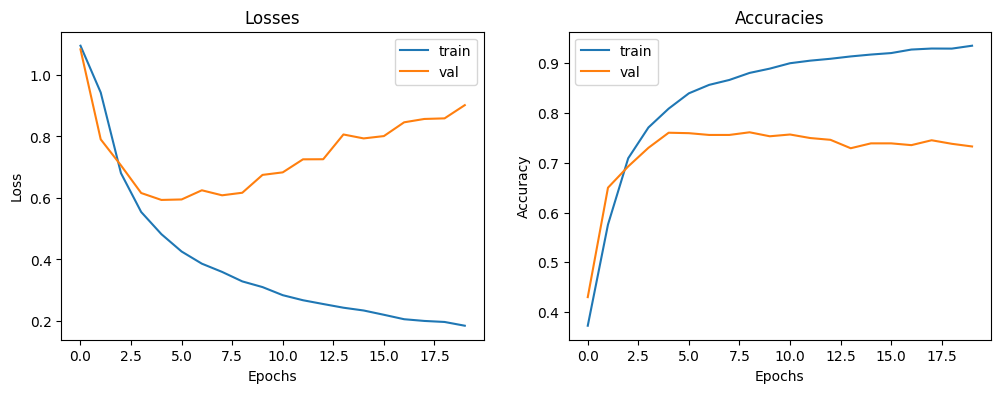

Test correct = 481

Test total dataitem = 750

Test Accuracy = 0.6413333415985107

              precision    recall  f1-score   support

    negative       0.71      0.57      0.63       250
     neutral       0.60      0.73      0.66       250
    positive       0.64      0.63      0.64       250

    accuracy                           0.64       750
   macro avg       0.65      0.64      0.64       750
weighted avg       0.65      0.64      0.64       750



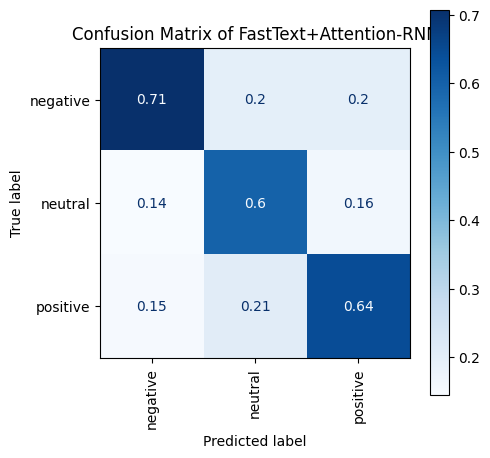

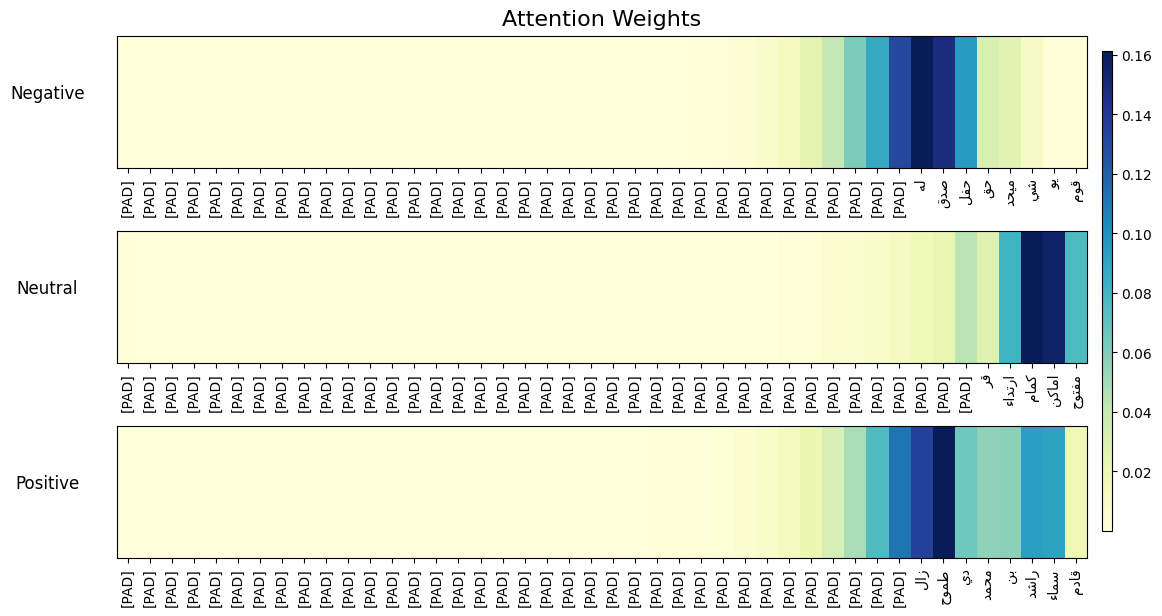

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You're on a {device}")
bidirectional=True
num_layers=2
hidden_size1=64
hidden_size2=128
droprate=0.1
freeze_embedding=False
learning_rate=0.0001
epoch=20

model=AttentionRNN(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
optimizer=optim.Adam(model.parameters(),lr=learning_rate) # play around this also
criterion=nn.CrossEntropyLoss()
train(model,epoch,optimizer,criterion,train_loader,val_loader,attention_added=True)
model_name='FastText+Attention-RNN'
test_and_report(model,test_loader,model_name,attention_added=True)

In [ ]:
torch.save(model.state_dict(),'model_name.pth')